In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

In [ ]:
import wandb
import random
from types import SimpleNamespace
wandb.finish()
wandb.login(key = "b5d1fbca9d5170f54415e9c5a70ef09cee7a0aec")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Ques 1:

Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use from keras.datasets import fashion_mnist for getting the fashion mnist dataset.

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


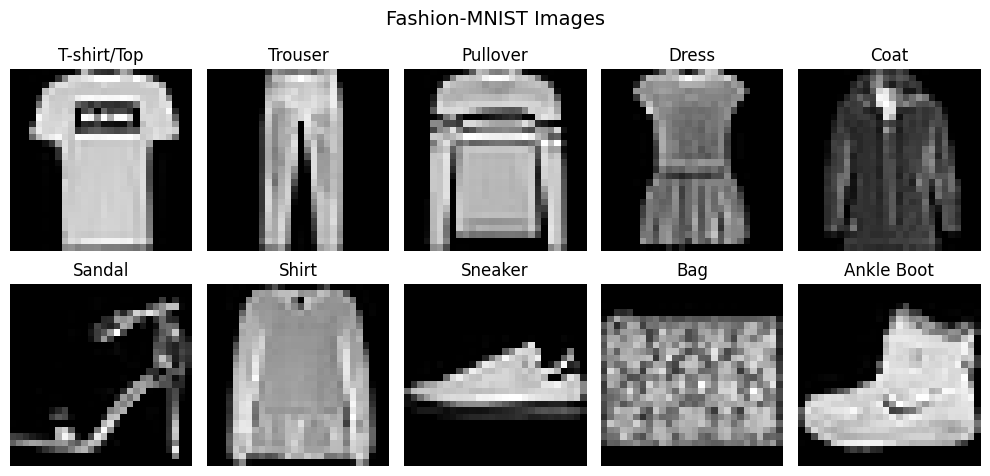

In [ ]:
wandb.init(project="MA23M021_A1", reinit = True)

# Loading the dataset..................................
(x_train, y_train), (_, _) = fashion_mnist.load_data()

# showing class labels.....................................
class_labels = [
    "T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"
]

# To plot the sample image from each class................................
sample_images = []
for i in range(10):
    sample_images.append(x_train[np.where(y_train == i)][0])

wandb.log({
    "Fashion-MNIST Samples": [wandb.Image(img, caption=label) for img, label in zip(sample_images, class_labels)],
})

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("Fashion-MNIST Images", fontsize=14)

for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[i], cmap='gray')
    ax.set_title(class_labels[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

wandb.finish()

# Ques (2)

Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.

Your code should be flexible such that it is easy to change the number of hidden layers and the number of neurons in each hidden layer.

In [ ]:
# fashion-MNIST dataset..................
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# normalizing input data...............
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# One-hot encoding function.............................
def onehot_encoding(y, num_classes=10):
    return np.eye(num_classes)[y]

# Activation functions................
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

# Define activation function derivatives.........................
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def sigmoid_derivative(x):
    sig = 1 / (1 + np.exp(-x))
    return sig * (1 - sig)

def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2

# initializing weights and biases.......................................
def param_init(input_size, num_hidden_layers, num_neurons, output_size=10, init_method='xavier'):
    layers = [input_size] + [num_neurons] * num_hidden_layers + [output_size]
    weights = {}
    biases = {}

    # initialization choices.......................................
    for i in range(1, len(layers)):
        if init_method == 'xavier':
            weights[f'W{i}'] = np.random.randn(layers[i - 1], layers[i]) * np.sqrt(2 / layers[i - 1])
        elif init_method == 'random':
            weights[f'W{i}'] = np.random.randn(layers[i - 1], layers[i]) * 0.01
        else:
            raise ValueError("Invalid init_method! Use 'xavier' or 'random'.")

        biases[f'b{i}'] = np.zeros((1, layers[i]))

    return weights, biases

# forward propagation........................................
def forwardd_propagation_(x, num_hidden_layers, num_neurons, weights=None, biases=None, output_size=10, activation_func='sigmoid'):
    input_size = x.shape[1]
    # initializing the parameters that is weights and bias.........................
    if weights is None or biases is None:
        weights, biases = param_init(input_size, num_hidden_layers, num_neurons, output_size)

    activations = {0: x}
    z_values = {}
# updation loop.......................................
    for i in range(1, len(weights) + 1):
        z_values[i] = np.dot(activations[i - 1], weights[f'W{i}']) + biases[f'b{i}']
        if i < len(weights):
            if activation_func == 'relu':
                activations[i] = relu(z_values[i])
            elif activation_func == 'tanh':
                activations[i] = tanh(z_values[i])
            else:
                activations[i] = sigmoid(z_values[i])
        else:
            activations[i] = softmax(z_values[i])

    return activations[len(weights)], activations, z_values, weights, biases


# Updated backward propagation....................................
def backwardd_propagation_(y, activations, z_values, weights, activation_function):
    grads = {}
    m = y.shape[0]

    def get_derivative(activation_func):
        if activation_func == 'relu':
            return relu_derivative
        elif activation_func == 'sigmoid':
            return sigmoid_derivative
        elif activation_func == 'tanh':
            return tanh_derivative

    hidden_derivative = get_derivative(activation_function)

    dz = activations[len(weights)] - y

    # Gradient calculation loop.................................
    for i in reversed(range(1, len(weights) + 1)):
        grads[f"dW{i}"] = np.dot(activations[i-1].T, dz) / m
        grads[f"db{i}"] = np.sum(dz, axis=0, keepdims=True) / m
        if i > 1:
            dz = np.dot(dz, weights[f'W{i}'].T) * hidden_derivative(z_values[i-1])

    return grads


# Update weights and bias using gradient descent..............................
def update_paramss_(weights, biases, grads, learningg_rate_):
    for i in range(1, len(weights) + 1):
        weights[f'W{i}'] -= learningg_rate_ * grads[f"dW{i}"]
        biases[f'b{i}'] -= learningg_rate_ * grads[f"db{i}"]
    return weights, biases

y_hat, _, _, _, _ = forwardd_propagation_(
    x=x_train,
    num_hidden_layers=3,
    num_neurons=128,
    activation_func='relu'
)


# printing probabilities and shape......................................
print("Probabilities:\n", y_hat[0])
print("Shape:", y_hat.shape)



# Full-batch training function ....................................
def train_(x_train, y_train, num_hidden_layers, num_neurons, epochs, learningg_rate_, activation_func='sigmoid'):
    weights, biases = param_init(x_train.shape[1], num_hidden_layers, num_neurons, 10)
    y_train_encoded = onehot_encoding(y_train)

    for epoch in range(epochs):
        y_hat, activations, z_values, weights, biases = forwardd_propagation_(
            x=x_train,
            num_hidden_layers=num_hidden_layers,
            num_neurons=num_neurons,
            weights=weights,
            biases=biases,
            output_size=10,
            activation_func=activation_func
        )

        # Calculate loss with one-hot encoded labels
        loss = -np.mean(y_train_encoded * np.log(y_hat + 1e-8))

        grads = backwardd_propagation_(y_train_encoded, activations, z_values, weights, activation_func)

        for i in range(1, len(weights) + 1):
            weights[f'W{i}'] -= learningg_rate_ * grads[f'dW{i}']
            biases[f'b{i}'] -= learningg_rate_ * grads[f'db{i}']
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

    return weights, biases



# Prediction function...........................
def predict(x, num_hidden_layers, num_neurons, weights, biases):
    y_hat,activations, _, _, _ = forwardd_propagation_(x, num_hidden_layers, num_neurons, weights, biases)
    return np.argmax(activations[len(weights)], axis=1)

# Training model using full-batch gradient descent........................................
num_hidden_layers = 2
num_neurons = 128
weights, biases = train_(x_train, y_train, num_hidden_layers=num_hidden_layers, num_neurons=num_neurons, epochs=20, learningg_rate_=0.005)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Probabilities:
 [0.15471762 0.06131931 0.06748403 0.09350854 0.27920522 0.09833357
 0.04720627 0.07197506 0.07564893 0.05060145]
Shape: (48000, 10)
Epoch 1/20, Loss: 0.2623
Epoch 2/20, Loss: 0.2613
Epoch 3/20, Loss: 0.2604
Epoch 4/20, Loss: 0.2595
Epoch 5/20, Loss: 0.2586
Epoch 6/20, Loss: 0.2578
Epoch 7/20, Loss: 0.2570
Epoch 8/20, Loss: 0.2563
Epoch 9/20, Loss: 0.2555
Epoch 10/20, Loss: 0.2549
Epoch 11/20, Loss: 0.2542
Epoch 12/20, Loss: 0.2535
Epoch 13/20, Loss: 0.2529
Epoch 14/20, Loss: 0.2523
Epoch 15/20, Loss: 0.2517
Epoch 16/20, Loss: 0.2512
Epoch 17/20, Loss: 0.2506
Epoch 18/20, Loss: 0.2501
Epoch 19/20, Loss: 0.2496
Epoch 20/20, Loss: 0.2491


# Ques 3

Implement the backpropagation algorithm with support for the following optimisation functions

sgd

momentum based gradient descent

nesterov accelerated gradient descent

rmsprop

adam

nadam


We will check the code for implementation and ease of use (e.g., how easy it is to add a new optimisation algorithm such as Eve). Note that the code should be flexible enough to work with different batch sizes.

In [ ]:

# fashion-MNIST dataset...............................
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalize pixel values.........................
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

# flattening images.................................
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# One-hot encode labels.........................
y_train = onehot_encoding(y_train)
y_test = onehot_encoding(y_test)
'''
y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))'''

# Split data.................................
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)



# function for stochastic gradient optimizer .........................
def sgd(weights, biases, gradients, params):
    lr = params.get("learningg_rate_", 0.01)
    for i in range(1, len(weights) + 1):
        weights[f"W{i}"] -= lr * gradients[f"dW{i}"]
        biases[f"b{i}"] -= lr * gradients[f"db{i}"]
    return weights, biases



# function for Adam optimizer ..............................
def adam(weights, biases, gradients, params):
    lr, beta1, beta2, epsilon = params.get("learningg_rate_", 0.001), 0.9, 0.999, 1e-8

    # Initializing momentum and velocity dictionaries.............................
    m_w = params.setdefault("m_w", {f"W{i}": np.zeros_like(weights[f"W{i}"]) for i in range(1, len(weights) + 1)})
    v_w = params.setdefault("v_w", {f"W{i}": np.zeros_like(weights[f"W{i}"]) for i in range(1, len(weights) + 1)})
    m_b = params.setdefault("m_b", {f"b{i}": np.zeros_like(biases[f"b{i}"]) for i in range(1, len(biases) + 1)})
    v_b = params.setdefault("v_b", {f"b{i}": np.zeros_like(biases[f"b{i}"]) for i in range(1, len(biases) + 1)})
    t = params.setdefault("t", 0) + 1

    for i in range(1, len(weights) + 1):
        w_key, b_key = f"W{i}", f"b{i}"

        m_w[w_key] = beta1 * m_w[w_key] + (1 - beta1) * gradients[f'd{w_key}']
        v_w[w_key] = beta2 * v_w[w_key] + (1 - beta2) * (gradients[f'd{w_key}'] ** 2)
        m_b[b_key] = beta1 * m_b[b_key] + (1 - beta1) * gradients[f'd{b_key}']
        v_b[b_key] = beta2 * v_b[b_key] + (1 - beta2) * (gradients[f'd{b_key}'] ** 2)

        m_w_hat, v_w_hat = m_w[w_key] / (1 - beta1**t), v_w[w_key] / (1 - beta2**t)
        m_b_hat, v_b_hat = m_b[b_key] / (1 - beta1**t), v_b[b_key] / (1 - beta2**t)

        # Updateing  weights and biases...............................
        weights[w_key] -= lr * m_w_hat / (np.sqrt(v_w_hat) + epsilon)
        biases[b_key] -= lr * m_b_hat / (np.sqrt(v_b_hat) + epsilon)

    params["t"] = t  # Update timestep
    return weights, biases

#function for momentum optimizer ..............................
def momentum(weights, biases, gradients, params):
    lr, beta = params.get("learningg_rate_", 0.01), params.get("beta", 0.9)
    v_w = params.setdefault("v_w", {f"W{i}": np.zeros_like(weights[f"W{i}"]) for i in range(1, len(weights) + 1)})
    v_b = params.setdefault("v_b", {f"b{i}": np.zeros_like(biases[f"b{i}"]) for i in range(1, len(biases) + 1)})
    for i in range(1, len(weights) + 1):
        w_key_, b_key_ = f"W{i}", f"b{i}"
        v_w[w_key_] = beta * v_w[w_key_] + (1 - beta) * gradients[f"dW{i}"]
        v_b[b_key_] = beta * v_b[b_key_] + (1 - beta) * gradients[f"db{i}"]
        weights[w_key_] -= lr * v_w[w_key_]
        biases[b_key_] -= lr * v_b[b_key_]
    return weights, biases


# function for neaterov optimizer ..............................
def nesterov(weights, biases, gradients, params):
    lr, mu = params.get("learningg_rate_", 0.01), 0.9
    v_w = params.setdefault("v_w", {f"W{i}": np.zeros_like(weights[f"W{i}"]) for i in range(1, len(weights) + 1)})
    v_b = params.setdefault("v_b", {f"b{i}": np.zeros_like(biases[f"b{i}"]) for i in range(1, len(biases) + 1)})

    for i in range(1, len(weights) + 1):
        v_w[f"W{i}"] = mu * v_w[f"W{i}"] + lr * gradients[f"dW{i}"]
        v_b[f"b{i}"] = mu * v_b[f"b{i}"] + lr * gradients[f"db{i}"]
        weights[f"W{i}"] -= v_w[f"W{i}"]   # updating weights
        biases[f"b{i}"] -= v_b[f"b{i}"]
    return weights, biases

#function for rmsprop optimizer ..............................
def rmsprop(weights, biases, gradients, params):
    lr, beta, epsilon = params.get("learningg_rate_", 0.001), 0.9, 1e-8
    s_w = params.setdefault("s_w", {f"W{i}": np.zeros_like(weights[f"W{i}"]) for i in range(1, len(weights) + 1)})
    s_b = params.setdefault("s_b", {f"b{i}": np.zeros_like(biases[f"b{i}"]) for i in range(1, len(biases) + 1)})

    for i in range(1, len(weights) + 1):
        s_w[f"W{i}"] = beta * s_w[f"W{i}"] + (1 - beta) * gradients[f"dW{i}"]**2
        s_b[f"b{i}"] = beta * s_b[f"b{i}"] + (1 - beta) * gradients[f"db{i}"]**2
        weights[f"W{i}"] -= lr * gradients[f"dW{i}"] / (np.sqrt(s_w[f"W{i}"]) + epsilon)
        biases[f"b{i}"] -= lr * gradients[f"db{i}"] / (np.sqrt(s_b[f"b{i}"]) + epsilon)
    return weights, biases

#function for nadam optimizer ..............................
def nadam(weights, biases, gradients, params):
    lr, beta1, beta2, epsilon = params.get("learningg_rate_", 0.001), 0.9, 0.999, 1e-8

    # Initialize momentum and velocity dictionaries...............................
    m_w = params.setdefault("m_w", {f"W{i}": np.zeros_like(weights[f"W{i}"]) for i in range(1, len(weights) + 1)})
    v_w = params.setdefault("v_w", {f"W{i}": np.zeros_like(weights[f"W{i}"]) for i in range(1, len(weights) + 1)})
    m_b = params.setdefault("m_b", {f"b{i}": np.zeros_like(biases[f"b{i}"]) for i in range(1, len(biases) + 1)})
    v_b = params.setdefault("v_b", {f"b{i}": np.zeros_like(biases[f"b{i}"]) for i in range(1, len(biases) + 1)})
    t = params.setdefault("t", 0) + 1

    for i in range(1, len(weights) + 1):
        w_key, b_key = f"W{i}", f"b{i}"

        # Updating biased first moment estimate-momentum part............................
        m_w[w_key] = beta1 * m_w[w_key] + (1 - beta1) * gradients[f"dW{i}"]
        m_b[b_key] = beta1 * m_b[b_key] + (1 - beta1) * gradients[f"db{i}"]

        # Updating biased second moment estimate-RMSProp part...............................
        v_w[w_key] = beta2 * v_w[w_key] + (1 - beta2) * (gradients[f"dW{i}"] ** 2)
        v_b[b_key] = beta2 * v_b[b_key] + (1 - beta2) * (gradients[f"db{i}"] ** 2)

        # estimates of Bias-corrected first and second moments............................
        m_w_hat = m_w[w_key] / (1 - beta1**t)
        v_w_hat = v_w[w_key] / (1 - beta2**t)
        m_b_hat = m_b[b_key] / (1 - beta1**t)
        v_b_hat = v_b[b_key] / (1 - beta2**t)

        # Nesterov momentum:............................
        m_w_nesterov = beta1 * m_w_hat + (1 - beta1) * gradients[f"dW{i}"]
        m_b_nesterov = beta1 * m_b_hat + (1 - beta1) * gradients[f"db{i}"]

        # Updating weights and biases using Nadam...................
        weights[w_key] -= lr * m_w_nesterov / (np.sqrt(v_w_hat) + epsilon)
        biases[b_key] -= lr * m_b_nesterov / (np.sqrt(v_b_hat) + epsilon)

    params["t"] = t
    return weights, biases


# train function...................................
def train(X_train, Y_train, X_test, Y_test, num_hidden_layers=3, num_neurons=128, num_epochs=20, batch_size=32,
          learningg_rate_=0.01, optimizer_func=adam, init_method='xavier', activation_func='relu'):

    input_size = X_train.shape[1]
    output_size = 10
    weights, biases = param_init(input_size, num_hidden_layers, num_neurons, output_size, init_method)
    optimizer_params = {"learningg_rate_": learningg_rate_}

    num_samples = X_train.shape[0]
    num_batches = num_samples // batch_size

    for epoch in range(num_epochs):
        perm = np.random.permutation(num_samples)
        X_train, Y_train = X_train[perm], Y_train[perm]

        for i in range(num_batches):
            batch_X = X_train[i * batch_size:(i + 1) * batch_size]
            batch_Y = Y_train[i * batch_size:(i + 1) * batch_size]

            # Forward propagation........................
            y_hat, activations, z_values, weights, biases = forwardd_propagation_(
                batch_X, num_hidden_layers, num_neurons, weights, biases, activation_func=activation_func
            )

            # Compute loss................................
            loss = -np.mean(np.sum(batch_Y * np.log(y_hat + 1e-8), axis=1))

            # Backward propagation........................
            grads = backwardd_propagation_(batch_Y, activations, z_values, weights, activation_func)

            # Update weights and biases...................
            weights, biases = optimizer_func(weights, biases, grads, optimizer_params)

        # Evaluate on test set after each epoch..........
        y_test_hat, _, _, _, _ = forwardd_propagation_(
            X_test, num_hidden_layers, num_neurons, weights, biases, activation_func=activation_func
        )
        predictions = np.argmax(y_test_hat, axis=1)
        accuracy = np.mean(predictions == np.argmax(Y_test, axis=1))

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

    return weights, biases


# calling the train function.........................................................................
weights, biases = train(X_train, y_train, X_test, y_test, 3, 128, 10, 32, 0.001, nesterov, 'xavier')

Epoch 1/10 - Loss: 0.6010, Accuracy: 0.8122
Epoch 2/10 - Loss: 0.4016, Accuracy: 0.8325
Epoch 3/10 - Loss: 0.2953, Accuracy: 0.8372
Epoch 4/10 - Loss: 0.7458, Accuracy: 0.8499
Epoch 5/10 - Loss: 0.2422, Accuracy: 0.8428
Epoch 6/10 - Loss: 0.6271, Accuracy: 0.8534
Epoch 7/10 - Loss: 0.3221, Accuracy: 0.8498
Epoch 8/10 - Loss: 0.3223, Accuracy: 0.8541
Epoch 9/10 - Loss: 0.3882, Accuracy: 0.8628
Epoch 10/10 - Loss: 0.2404, Accuracy: 0.8687


# Ques 4

Use the sweep functionality provided by wandb to find the best values for the hyperparameters listed below. Use the standard train/test split of fashion_mnist (use (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()). Keep 10% of the training data aside as validation data for this hyperparameter search. Here are some suggestions for different values to try for hyperparameters. As you can quickly see that this leads to an exponential number of combinations. You will have to think about strategies to do this hyperparameter search efficiently. Check out the options provided by wandb.sweep and write down what strategy you chose and why.

number of epochs: 5, 10

number of hidden layers: 3, 4, 5

size of every hidden layer: 32, 64, 128

weight decay (L2 regularisation): 0, 0.0005, 0.5

learning rate: 1e-3, 1 e-4

optimizer: sgd, momentum, nesterov, rmsprop, adam, nadam

batch size: 16, 32, 64

weight initialisation: random, Xavier

activation functions: sigmoid, tanh, ReLU

wandb will automatically generate the following plots. Paste these plots below using the "Add Panel to Report" feature. Make sure you use meaningful names for each sweep (e.g. hl_3_bs_16_ac_tanh to indicate that there were 3 hidden layers, batch size was 16 and activation function was ReLU) instead of using the default names (whole-sweep, kind-sweep) given by wandb.

In [ ]:
# to train the models......................................
def training_model(X_train, Y_train, X_valid, Y_valid, num_hidden_layers, num_neurons, num_epochs=20, batch_size=32,
                   learningg_rate_=0.01, optimizer='adam', init_method='xavier', activation_func='relu', weight_decay=0.0005):

    if Y_train.ndim == 1:
        Y_train = onehot_encoding(Y_train)
    if Y_valid.ndim == 1:
        Y_valid = onehot_encoding(Y_valid)

    # Initializing weights and biases.....................................................
    input_size = X_train.shape[1]
    output_size = 10
    weights, biases = param_init(input_size, num_hidden_layers, num_neurons, output_size, init_method=init_method)

    # Parameters for specific optimizer....................................................
    optimizer_params = {
        "learningg_rate_": learningg_rate_,
        "beta": 0.9,
        "beta1": 0.9,
        "beta2": 0.999,
        "eps": 1e-8
    }

    # Choosing optimizer function..........................................................
    if optimizer == 'adam':
        optimizer_func = adam
    elif optimizer == 'sgd':
        optimizer_func = sgd
    elif optimizer == 'momentum':
        optimizer_func = momentum
    elif optimizer == 'nesterov':
        optimizer_func = nesterov
    elif optimizer == 'rmsprop':
        optimizer_func = rmsprop
    elif optimizer == 'nadam':
        optimizer_func = nadam
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")

    num_samples = X_train.shape[0]
    num_batches = num_samples // batch_size

    # loop to train..................................
    for epoch in range(num_epochs):
        # Shuffling data at the start of each epoch...........................
        perm = np.random.permutation(num_samples)
        X_train, Y_train = X_train[perm], Y_train[perm]

        epoch_loss = 0

        for i in range(num_batches):
            # batches creation...........................................
            batch_X = X_train[i * batch_size:(i + 1) * batch_size]
            batch_Y = Y_train[i * batch_size:(i + 1) * batch_size]

            # Forward propagation.................................................................
            probs, activations, z_values, weights, biases = forwardd_propagation_(
                batch_X, num_hidden_layers, num_neurons, weights, biases, activation_func=activation_func
            )

            # Cross-Entropy Loss with softmax probabilities
            batch_loss = -np.mean(np.sum(batch_Y * np.log(probs + 1e-8), axis=1))
            l2_reg_loss = l2_regu_loss(weights, weight_decay)
            epoch_loss += batch_loss

            # Backward propagation..........................................
            grads = backwardd_propagation_(batch_Y, activations, z_values, weights, activation_func)

            # Updating weights and biases...................................
            weights, biases = optimizer_func(weights, biases, grads, optimizer_params)

        # Computing average training loss on the epoch..........................
        train_loss_value = epoch_loss / num_batches
        train_probs, _, _, _, _ = forwardd_propagation_(
            X_train, num_hidden_layers, num_neurons, weights, biases, activation_func=activation_func
        )
        train_predictions = np.argmax(train_probs, axis=1)
        train_accuracy_value = np.mean(train_predictions == np.argmax(Y_train, axis=1))

        # Validation phase................................................
        valid_probs, valid_activations, _, _, _ = forwardd_propagation_(
            X_valid, num_hidden_layers, num_neurons, weights, biases, activation_func=activation_func
        )

        # Validation loss................................................
        validation_loss_value = -np.mean(np.sum(Y_valid * np.log(valid_probs + 1e-8), axis=1))

        # Validation accuracy.............................................
        valid_predictions = np.argmax(valid_probs, axis=1)
        val_accuracy_value = np.mean(valid_predictions == np.argmax(Y_valid, axis=1))

        # Log metrics to wandb............................................
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss_value,
            "val_loss": validation_loss_value,
            "val_accuracy": val_accuracy_value,
            "accuracy": train_accuracy_value,
            "learningg_rate_": learningg_rate_,
        })
        print(f"Logged to wandb: Epoch {epoch + 1}, Val Accuracy: {val_accuracy_value}")

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss_value:.4f}, Val Loss: {validation_loss_value:.4f}, Val Accuracy: {val_accuracy_value:.4f}")

    # Save weights and biases...........................................
    np.save('weights.npy', weights)
    np.save('biases.npy', biases)
    wandb.save('weights.npy')
    wandb.save('biases.npy')

    return weights, biases


def l2_regu_loss(weights, weight_decay):
    l2_reg_loss = weight_decay * sum(np.sum(w ** 2) for w in weights)
    return l2_reg_loss




# Define sweep configuration
sweep_config = {
    "method": "bayes",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "epochs": {"values": [5, 10]},
        "num_hidden_layers": {"values": [3, 4, 5]},
        "hidden_layer_size": {"values": [32, 64, 128]},
        "weight_decay": {"values": [0,0.0005,0.5]},
        "learningg_rate_": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum","nesterov", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "weight_initialization": {"values": ["random", "xavier"]},
        "activation_function": {"values": ["relu", 'sigmoid','tanh']}
    }
}

# Creating a sweep..........................................
sweep_id = wandb.sweep(sweep=sweep_config, project='MA23M021_A1')

# function for the sweep..................................
def main():
    run = wandb.init(reinit=True)
    config = wandb.config

    # Print current configuration
    print("-" * 50)
    print("Starting a new run with the following configuration:")
    print(f"Activation Function: {config.activation_function}")
    print(f"Hidden Layer Size: {config.hidden_layer_size}")
    print(f"Epochs: {config.epochs}")
    print(f"Number of Hidden Layers: {config.num_hidden_layers}")
    print(f"Learning Rate: {config.learningg_rate_}")
    print(f"Optimizer: {config.optimizer}")
    print(f"Batch Size: {config.batch_size}")
    print(f"Weight Initialization: {config.weight_initialization}")
    print(f"Weight Decay: {config.weight_decay}")
    print("-" * 50)

    # Generate a meaningful name for the run
    run_name = (
        f"ac-{config.activation_function}_hs-{config.hidden_layer_size}_epc-{config.epochs}_hl-{config.num_hidden_layers}"
        f"_lr-{config.learningg_rate_}_opt-{config.optimizer}"
        f"_bs-{config.batch_size}_wi-{config.weight_initialization}_wd-{config.weight_decay}"
    )
    run.name = run_name
    wandb.run.name = run_name

# Call model training function with sweep parameters
    weights, biases = training_model(
        X_train=X_train,
        Y_train=y_train,
        X_valid=X_valid,
        Y_valid=y_valid,
        num_hidden_layers=config.num_hidden_layers,
        num_neurons=config.hidden_layer_size,
        num_epochs=config.epochs,
        batch_size=config.batch_size,
        learningg_rate_=config.learningg_rate_,
        optimizer=config.optimizer,
        init_method=config.weight_initialization,
        activation_func=config.activation_function
        weight_decay=config.weight_decay
    )


# Run the sweep
wandb.agent(sweep_id, function=main, count = 200)
wandb.finish()

Create sweep with ID: t8eqlt59
Sweep URL: https://wandb.ai/ma23m021-iit-madras/MA23M021_A1/sweeps/t8eqlt59


wandb: Agent Starting Run: chvs32ph with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: random


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: tanh
Hidden Layer Size: 32
Epochs: 5
Number of Hidden Layers: 3
Learning Rate: 0.0001
Optimizer: adam
Batch Size: 64
Weight Initialization: random
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.1965
Epoch 1/5, Train Loss: 1.8596, Val Loss: 1.6992, Val Accuracy: 0.1965
Logged to wandb: Epoch 2, Val Accuracy: 0.20358333333333334
Epoch 2/5, Train Loss: 1.6821, Val Loss: 1.6759, Val Accuracy: 0.2036
Logged to wandb: Epoch 3, Val Accuracy: 0.19983333333333334
Epoch 3/5, Train Loss: 1.6666, Val Loss: 1.6612, Val Accuracy: 0.1998
Logged to wandb: Epoch 4, Val Accuracy: 0.3536666666666667
Epoch 4/5, Train Loss: 1.6130, Val Loss: 1.5199, Val Accuracy: 0.3537
Logged to wandb: Epoch 5, Val Accuracy: 0.391
Epoch 5/5, Train Loss: 1.3901, Val Loss: 1.2961, Val Accuracy: 0.3910


accuracy,▁▁▁▇█
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▅▅▄▁
val_accuracy,▁▁▁▇█
val_loss,██▇▅▁
accuracy,0.39035
epoch,5
learningg_rate_,0.0001
train_loss,1.39006
val_accuracy,0.391


wandb: Agent Starting Run: fk6wqec9 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_initialization: random


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 64
Epochs: 5
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: rmsprop
Batch Size: 16
Weight Initialization: random
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.30175
Epoch 1/5, Train Loss: 1.9810, Val Loss: 1.5774, Val Accuracy: 0.3018
Logged to wandb: Epoch 2, Val Accuracy: 0.40525
Epoch 2/5, Train Loss: 1.3929, Val Loss: 1.2632, Val Accuracy: 0.4052
Logged to wandb: Epoch 3, Val Accuracy: 0.48933333333333334
Epoch 3/5, Train Loss: 1.1670, Val Loss: 1.1627, Val Accuracy: 0.4893
Logged to wandb: Epoch 4, Val Accuracy: 0.6428333333333334
Epoch 4/5, Train Loss: 1.0486, Val Loss: 0.9872, Val Accuracy: 0.6428
Logged to wandb: Epoch 5, Val Accuracy: 0.6731666666666667
Epoch 5/5, Train Loss: 0.8866, Val Loss: 0.8536, Val Accuracy: 0.6732


accuracy,▁▃▅▇█
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▄▃▂▁
val_accuracy,▁▃▅▇█
val_loss,█▅▄▂▁
accuracy,0.68267
epoch,5
learningg_rate_,0.001
train_loss,0.88658
val_accuracy,0.67317


wandb: Agent Starting Run: o97vgd4c with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: random


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 32
Epochs: 5
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: momentum
Batch Size: 16
Weight Initialization: random
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.10091666666666667
Epoch 1/5, Train Loss: 2.3028, Val Loss: 2.3026, Val Accuracy: 0.1009
Logged to wandb: Epoch 2, Val Accuracy: 0.09975
Epoch 2/5, Train Loss: 2.3028, Val Loss: 2.3026, Val Accuracy: 0.0998
Logged to wandb: Epoch 3, Val Accuracy: 0.10016666666666667
Epoch 3/5, Train Loss: 2.3028, Val Loss: 2.3027, Val Accuracy: 0.1002
Logged to wandb: Epoch 4, Val Accuracy: 0.09866666666666667
Epoch 4/5, Train Loss: 2.3027, Val Loss: 2.3026, Val Accuracy: 0.0987
Logged to wandb: Epoch 5, Val Accuracy: 0.09975
Epoch 5/5, Train Loss: 2.3028, Val Loss: 2.3026, Val Accuracy: 0.0998


accuracy,▁▅▃█▅
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,▆█▃▁▂
val_accuracy,█▄▆▁▄
val_loss,▅▁█▅▃
accuracy,0.10006
epoch,5
learningg_rate_,0.001
train_loss,2.30275
val_accuracy,0.09975


wandb: Agent Starting Run: xlt6i3qx with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 5
Number of Hidden Layers: 4
Learning Rate: 0.0001
Optimizer: momentum
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.30983333333333335
Epoch 1/5, Train Loss: 2.1871, Val Loss: 2.0093, Val Accuracy: 0.3098
Logged to wandb: Epoch 2, Val Accuracy: 0.48341666666666666
Epoch 2/5, Train Loss: 1.8248, Val Loss: 1.6355, Val Accuracy: 0.4834
Logged to wandb: Epoch 3, Val Accuracy: 0.6096666666666667
Epoch 3/5, Train Loss: 1.4679, Val Loss: 1.3233, Val Accuracy: 0.6097
Logged to wandb: Epoch 4, Val Accuracy: 0.66575
Epoch 4/5, Train Loss: 1.1966, Val Loss: 1.1007, Val Accuracy: 0.6657
Logged to wandb: Epoch 5, Val Accuracy: 0.69975
Epoch 5/5, Train Loss: 1.0119, Val Loss: 0.9588, Val Accuracy: 0.6997


accuracy,▁▄▆▇█
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▆▄▂▁
val_accuracy,▁▄▆▇█
val_loss,█▆▃▂▁
accuracy,0.70829
epoch,5
learningg_rate_,0.0001
train_loss,1.01186
val_accuracy,0.69975


wandb: Agent Starting Run: 7f6gpp9q with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 64
Epochs: 5
Number of Hidden Layers: 3
Learning Rate: 0.001
Optimizer: rmsprop
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8026666666666666
Epoch 1/5, Train Loss: 0.9301, Val Loss: 0.5422, Val Accuracy: 0.8027
Logged to wandb: Epoch 2, Val Accuracy: 0.8430833333333333
Epoch 2/5, Train Loss: 0.4749, Val Loss: 0.4409, Val Accuracy: 0.8431
Logged to wandb: Epoch 3, Val Accuracy: 0.8506666666666667
Epoch 3/5, Train Loss: 0.4128, Val Loss: 0.4184, Val Accuracy: 0.8507
Logged to wandb: Epoch 4, Val Accuracy: 0.86325
Epoch 4/5, Train Loss: 0.3825, Val Loss: 0.3741, Val Accuracy: 0.8632
Logged to wandb: Epoch 5, Val Accuracy: 0.8598333333333333
Epoch 5/5, Train Loss: 0.3611, Val Loss: 0.3960, Val Accuracy: 0.8598


accuracy,▁▅▆█▇
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▂▂▁▁
val_accuracy,▁▆▇██
val_loss,█▄▃▁▂
accuracy,0.86865
epoch,5
learningg_rate_,0.001
train_loss,0.36108
val_accuracy,0.85983


wandb: Agent Starting Run: fikml8iv with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: random


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: tanh
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 64
Weight Initialization: random
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.23616666666666666
Epoch 1/10, Train Loss: 1.7313, Val Loss: 1.6668, Val Accuracy: 0.2362
Logged to wandb: Epoch 2, Val Accuracy: 0.5338333333333334
Epoch 2/10, Train Loss: 1.3807, Val Loss: 1.1171, Val Accuracy: 0.5338
Logged to wandb: Epoch 3, Val Accuracy: 0.6600833333333334
Epoch 3/10, Train Loss: 0.9862, Val Loss: 0.9134, Val Accuracy: 0.6601
Logged to wandb: Epoch 4, Val Accuracy: 0.7094166666666667
Epoch 4/10, Train Loss: 0.8452, Val Loss: 0.8159, Val Accuracy: 0.7094
Logged to wandb: Epoch 5, Val Accuracy: 0.764
Epoch 5/10, Train Loss: 0.7276, Val Loss: 0.6856, Val Accuracy: 0.7640
Logged to wandb: Epo

accuracy,▁▄▆▆▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▄▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
accuracy,0.84927
epoch,10
learningg_rate_,0.0001
train_loss,0.45408
val_accuracy,0.84125


wandb: Agent Starting Run: 4l0xxm32 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: tanh
Hidden Layer Size: 64
Epochs: 5
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: momentum
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.7026666666666667
Epoch 1/5, Train Loss: 1.3409, Val Loss: 0.9510, Val Accuracy: 0.7027
Logged to wandb: Epoch 2, Val Accuracy: 0.7529166666666667
Epoch 2/5, Train Loss: 0.8309, Val Loss: 0.7581, Val Accuracy: 0.7529
Logged to wandb: Epoch 3, Val Accuracy: 0.7758333333333334
Epoch 3/5, Train Loss: 0.6997, Val Loss: 0.6663, Val Accuracy: 0.7758
Logged to wandb: Epoch 4, Val Accuracy: 0.793
Epoch 4/5, Train Loss: 0.6279, Val Loss: 0.6108, Val Accuracy: 0.7930
Logged to wandb: Epoch 5, Val Accuracy: 0.8055833333333333
Epoch 5/5, Train Loss: 0.5805, Val Loss: 0.5699, Val Accuracy: 0.8056


accuracy,▁▄▆▇█
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
accuracy,0.81127
epoch,5
learningg_rate_,0.001
train_loss,0.58047
val_accuracy,0.80558


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tfy8tes1 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: random


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 5
Number of Hidden Layers: 3
Learning Rate: 0.0001
Optimizer: adam
Batch Size: 16
Weight Initialization: random
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.6915
Epoch 1/5, Train Loss: 0.9847, Val Loss: 0.7925, Val Accuracy: 0.6915
Logged to wandb: Epoch 2, Val Accuracy: 0.7309166666666667
Epoch 2/5, Train Loss: 0.7519, Val Loss: 0.7246, Val Accuracy: 0.7309
Logged to wandb: Epoch 3, Val Accuracy: 0.7580833333333333
Epoch 3/5, Train Loss: 0.6812, Val Loss: 0.6459, Val Accuracy: 0.7581
Logged to wandb: Epoch 4, Val Accuracy: 0.765
Epoch 4/5, Train Loss: 0.6187, Val Loss: 0.6190, Val Accuracy: 0.7650
Logged to wandb: Epoch 5, Val Accuracy: 0.7994166666666667
Epoch 5/5, Train Loss: 0.5647, Val Loss: 0.5488, Val Accuracy: 0.7994


accuracy,▁▃▅▆█
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▄▃▂▁
val_accuracy,▁▄▅▆█
val_loss,█▆▄▃▁
accuracy,0.80502
epoch,5
learningg_rate_,0.0001
train_loss,0.56475
val_accuracy,0.79942


wandb: Agent Starting Run: 8gnim3de with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_initialization: random


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: tanh
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 3
Learning Rate: 0.0001
Optimizer: sgd
Batch Size: 64
Weight Initialization: random
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.10958333333333334
Epoch 1/10, Train Loss: 2.3026, Val Loss: 2.3026, Val Accuracy: 0.1096
Logged to wandb: Epoch 2, Val Accuracy: 0.10058333333333333
Epoch 2/10, Train Loss: 2.3026, Val Loss: 2.3026, Val Accuracy: 0.1006
Logged to wandb: Epoch 3, Val Accuracy: 0.09725
Epoch 3/10, Train Loss: 2.3026, Val Loss: 2.3026, Val Accuracy: 0.0973
Logged to wandb: Epoch 4, Val Accuracy: 0.09675
Epoch 4/10, Train Loss: 2.3026, Val Loss: 2.3026, Val Accuracy: 0.0968
Logged to wandb: Epoch 5, Val Accuracy: 0.09666666666666666
Epoch 5/10, Train Loss: 2.3026, Val Loss: 2.3026, Val Accuracy: 0.0967
Logged to wandb: Epoch 6, Val

accuracy,█▃▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▇▆▅▄▃▃▂▁
val_accuracy,█▃▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▄▃▃▂▁
accuracy,0.10085
epoch,10
learningg_rate_,0.0001
train_loss,2.30256
val_accuracy,0.09658


wandb: Agent Starting Run: gftjct9o with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: tanh
Hidden Layer Size: 32
Epochs: 10
Number of Hidden Layers: 3
Learning Rate: 0.0001
Optimizer: sgd
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.197
Epoch 1/10, Train Loss: 2.3262, Val Loss: 2.1498, Val Accuracy: 0.1970
Logged to wandb: Epoch 2, Val Accuracy: 0.28208333333333335
Epoch 2/10, Train Loss: 2.0316, Val Loss: 1.9367, Val Accuracy: 0.2821
Logged to wandb: Epoch 3, Val Accuracy: 0.3545
Epoch 3/10, Train Loss: 1.8518, Val Loss: 1.7865, Val Accuracy: 0.3545
Logged to wandb: Epoch 4, Val Accuracy: 0.42325
Epoch 4/10, Train Loss: 1.7198, Val Loss: 1.6732, Val Accuracy: 0.4233
Logged to wandb: Epoch 5, Val Accuracy: 0.48975
Epoch 5/10, Train Loss: 1.6193, Val Loss: 1.5852, Val Accuracy: 0.4898
Logged to wandb: Epoch 6, Val Accuracy: 0.5450833333

accuracy,▁▂▄▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▂▄▅▆▇▇███
val_loss,█▆▅▄▃▃▂▂▁▁
accuracy,0.63985
epoch,10
learningg_rate_,0.0001
train_loss,1.3311
val_accuracy,0.6355


wandb: Agent Starting Run: 1ltoz984 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: random


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: adam
Batch Size: 32
Weight Initialization: random
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.20275
Epoch 1/10, Train Loss: 1.8468, Val Loss: 1.7199, Val Accuracy: 0.2028
Logged to wandb: Epoch 2, Val Accuracy: 0.28541666666666665
Epoch 2/10, Train Loss: 1.6453, Val Loss: 1.4817, Val Accuracy: 0.2854
Logged to wandb: Epoch 3, Val Accuracy: 0.6348333333333334
Epoch 3/10, Train Loss: 1.1208, Val Loss: 0.8430, Val Accuracy: 0.6348
Logged to wandb: Epoch 4, Val Accuracy: 0.6616666666666666
Epoch 4/10, Train Loss: 0.7742, Val Loss: 0.7561, Val Accuracy: 0.6617
Logged to wandb: Epoch 5, Val Accuracy: 0.80325
Epoch 5/10, Train Loss: 0.6349, Val Loss: 0.6036, Val Accuracy: 0.8033
Logged to wandb: Epoch 6, Va

accuracy,▁▂▆▆▇█████
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▄▃▂▂▁▁▁▁
val_accuracy,▁▂▆▆██████
val_loss,█▇▃▃▂▂▁▁▁▁
accuracy,0.87281
epoch,10
learningg_rate_,0.001
train_loss,0.42512
val_accuracy,0.84717


wandb: Agent Starting Run: 5i0g0elp with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: random


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.0001
Optimizer: rmsprop
Batch Size: 64
Weight Initialization: random
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.5036666666666667
Epoch 1/10, Train Loss: 1.6039, Val Loss: 1.1301, Val Accuracy: 0.5037
Logged to wandb: Epoch 2, Val Accuracy: 0.5498333333333333
Epoch 2/10, Train Loss: 1.0480, Val Loss: 1.0185, Val Accuracy: 0.5498
Logged to wandb: Epoch 3, Val Accuracy: 0.5901666666666666
Epoch 3/10, Train Loss: 0.9886, Val Loss: 1.0047, Val Accuracy: 0.5902
Logged to wandb: Epoch 4, Val Accuracy: 0.6340833333333333
Epoch 4/10, Train Loss: 0.9570, Val Loss: 0.9539, Val Accuracy: 0.6341
Logged to wandb: Epoch 5, Val Accuracy: 0.6303333333333333
Epoch 5/10, Train Loss: 0.9337, Val Loss: 0.9331, Val Accuracy: 0.6303
Logge

accuracy,▁▃▄▆▆▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▃▄▆▆▆▇▇██
val_loss,█▅▅▄▃▃▂▂▂▁
accuracy,0.69419
epoch,10
learningg_rate_,0.0001
train_loss,0.84388
val_accuracy,0.68283


wandb: Agent Starting Run: 8q2yopyc with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 32
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.19983333333333334
Epoch 1/10, Train Loss: 2.2836, Val Loss: 2.1308, Val Accuracy: 0.1998
Logged to wandb: Epoch 2, Val Accuracy: 0.3169166666666667
Epoch 2/10, Train Loss: 1.9341, Val Loss: 1.7566, Val Accuracy: 0.3169
Logged to wandb: Epoch 3, Val Accuracy: 0.37675
Epoch 3/10, Train Loss: 1.6052, Val Loss: 1.4893, Val Accuracy: 0.3767
Logged to wandb: Epoch 4, Val Accuracy: 0.5159166666666667
Epoch 4/10, Train Loss: 1.4029, Val Loss: 1.3278, Val Accuracy: 0.5159
Logged to wandb: Epoch 5, Val Accuracy: 0.5975
Epoch 5/10, Train Loss: 1.2196, Val Loss: 1.1354, Val Accuracy: 0.5975
Logged to wandb: Epoch 

accuracy,▁▃▃▅▇▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▅▄▃▂▂▁▁▁
val_accuracy,▁▃▃▅▇▇▇▇██
val_loss,█▆▅▄▃▂▂▁▁▁
accuracy,0.71458
epoch,10
learningg_rate_,0.0001
train_loss,0.81177
val_accuracy,0.70517


wandb: Agent Starting Run: 7rxnzif0 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 32
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: momentum
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.742
Epoch 1/10, Train Loss: 1.3597, Val Loss: 0.7943, Val Accuracy: 0.7420
Logged to wandb: Epoch 2, Val Accuracy: 0.79125
Epoch 2/10, Train Loss: 0.6740, Val Loss: 0.6107, Val Accuracy: 0.7913
Logged to wandb: Epoch 3, Val Accuracy: 0.8125
Epoch 3/10, Train Loss: 0.5664, Val Loss: 0.5441, Val Accuracy: 0.8125
Logged to wandb: Epoch 4, Val Accuracy: 0.82275
Epoch 4/10, Train Loss: 0.5200, Val Loss: 0.5118, Val Accuracy: 0.8227
Logged to wandb: Epoch 5, Val Accuracy: 0.8279166666666666
Epoch 5/10, Train Loss: 0.4915, Val Loss: 0.4949, Val Accuracy: 0.8279
Logged to wandb: Epoch 6, Val Accuracy: 0.832083333333

accuracy,▁▄▆▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▄▃▂▂▂▂▁▁▁
accuracy,0.85033
epoch,10
learningg_rate_,0.001
train_loss,0.4209
val_accuracy,0.84333


wandb: Agent Starting Run: ezekxygy with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 5
Number of Hidden Layers: 3
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8225833333333333
Epoch 1/5, Train Loss: 0.7430, Val Loss: 0.5120, Val Accuracy: 0.8226
Logged to wandb: Epoch 2, Val Accuracy: 0.8455833333333334
Epoch 2/5, Train Loss: 0.4589, Val Loss: 0.4408, Val Accuracy: 0.8456
Logged to wandb: Epoch 3, Val Accuracy: 0.8540833333333333
Epoch 3/5, Train Loss: 0.4111, Val Loss: 0.4098, Val Accuracy: 0.8541
Logged to wandb: Epoch 4, Val Accuracy: 0.86
Epoch 4/5, Train Loss: 0.3820, Val Loss: 0.3951, Val Accuracy: 0.8600
Logged to wandb: Epoch 5, Val Accuracy: 0.8661666666666666
Epoch 5/5, Train Loss: 0.3619, Val Loss: 0.3849, Val Accuracy: 0.8662


accuracy,▁▄▆▇█
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▂▁
accuracy,0.875
epoch,5
learningg_rate_,0.0001
train_loss,0.36195
val_accuracy,0.86617


wandb: Agent Starting Run: e957yfha with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 32
Epochs: 5
Number of Hidden Layers: 3
Learning Rate: 0.0001
Optimizer: adam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.39
Epoch 1/5, Train Loss: 2.2504, Val Loss: 2.0940, Val Accuracy: 0.3900
Logged to wandb: Epoch 2, Val Accuracy: 0.6068333333333333
Epoch 2/5, Train Loss: 1.9343, Val Loss: 1.7703, Val Accuracy: 0.6068
Logged to wandb: Epoch 3, Val Accuracy: 0.624
Epoch 3/5, Train Loss: 1.6037, Val Loss: 1.4579, Val Accuracy: 0.6240
Logged to wandb: Epoch 4, Val Accuracy: 0.6354166666666666
Epoch 4/5, Train Loss: 1.3290, Val Loss: 1.2286, Val Accuracy: 0.6354
Logged to wandb: Epoch 5, Val Accuracy: 0.651
Epoch 5/5, Train Loss: 1.1360, Val Loss: 1.0729, Val Accuracy: 0.6510


accuracy,▁▇▇██
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▆▄▂▁
val_accuracy,▁▇▇██
val_loss,█▆▄▂▁
accuracy,0.65815
epoch,5
learningg_rate_,0.0001
train_loss,1.13605
val_accuracy,0.651


wandb: Agent Starting Run: 0mcrm4mz with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 32
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.835
Epoch 1/10, Train Loss: 0.5527, Val Loss: 0.4528, Val Accuracy: 0.8350
Logged to wandb: Epoch 2, Val Accuracy: 0.8625833333333334
Epoch 2/10, Train Loss: 0.4039, Val Loss: 0.3888, Val Accuracy: 0.8626
Logged to wandb: Epoch 3, Val Accuracy: 0.8635
Epoch 3/10, Train Loss: 0.3720, Val Loss: 0.3740, Val Accuracy: 0.8635
Logged to wandb: Epoch 4, Val Accuracy: 0.8629166666666667
Epoch 4/10, Train Loss: 0.3513, Val Loss: 0.3671, Val Accuracy: 0.8629
Logged to wandb: Epoch 5, Val Accuracy: 0.8718333333333333
Epoch 5/10, Train Loss: 0.3345, Val Loss: 0.3545, Val Accuracy: 0.8718
Logged to wandb: Epoch 6, Val Accur

accuracy,▁▆▆▆██▅▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▆▆▆██▅▆▆▇
val_loss,█▃▂▂▁▂▄▄▃▂
accuracy,0.88769
epoch,10
learningg_rate_,0.001
train_loss,0.29007
val_accuracy,0.86608


wandb: Agent Starting Run: oq6air27 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: random


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.0001
Optimizer: adam
Batch Size: 64
Weight Initialization: random
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.10041666666666667
Epoch 1/10, Train Loss: 2.3032, Val Loss: 2.3038, Val Accuracy: 0.1004
Logged to wandb: Epoch 2, Val Accuracy: 0.10158333333333333
Epoch 2/10, Train Loss: 2.3034, Val Loss: 2.3023, Val Accuracy: 0.1016
Logged to wandb: Epoch 3, Val Accuracy: 0.20091666666666666
Epoch 3/10, Train Loss: 1.9492, Val Loss: 1.7121, Val Accuracy: 0.2009
Logged to wandb: Epoch 4, Val Accuracy: 0.20108333333333334
Epoch 4/10, Train Loss: 1.6914, Val Loss: 1.6841, Val Accuracy: 0.2011
Logged to wandb: Epoch 5, Val Accuracy: 0.20225
Epoch 5/10, Train Loss: 1.6771, Val Loss: 1.6772, Val Accuracy: 0.2023
Logged t

accuracy,▁▁▃▃▃▃▃▅▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,██▆▄▄▄▄▄▂▁
val_accuracy,▁▁▃▃▃▃▃▅▇█
val_loss,██▄▄▄▄▄▃▂▁
accuracy,0.45498
epoch,10
learningg_rate_,0.0001
train_loss,1.25173
val_accuracy,0.45417


wandb: Agent Starting Run: 7p33ugkh with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_initialization: random


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: tanh
Hidden Layer Size: 128
Epochs: 5
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nesterov
Batch Size: 16
Weight Initialization: random
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.09866666666666667
Epoch 1/5, Train Loss: 2.3028, Val Loss: 2.3027, Val Accuracy: 0.0987
Logged to wandb: Epoch 2, Val Accuracy: 0.16041666666666668
Epoch 2/5, Train Loss: 2.3028, Val Loss: 2.3027, Val Accuracy: 0.1604
Logged to wandb: Epoch 3, Val Accuracy: 0.10158333333333333
Epoch 3/5, Train Loss: 2.3028, Val Loss: 2.3026, Val Accuracy: 0.1016
Logged to wandb: Epoch 4, Val Accuracy: 0.10016666666666667
Epoch 4/5, Train Loss: 2.3027, Val Loss: 2.3027, Val Accuracy: 0.1002
Logged to wandb: Epoch 5, Val Accuracy: 0.10041666666666667
Epoch 5/5, Train Loss: 2.3027, Val Loss: 2.3026, Val Accuracy: 0.1004


accuracy,▁█▁▁▁
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,▅█▇▁▃
val_accuracy,▁█▁▁▁
val_loss,█▅▂█▁
accuracy,0.0999
epoch,5
learningg_rate_,0.001
train_loss,2.30272
val_accuracy,0.10042


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jwu2tx98 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: random


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: tanh
Hidden Layer Size: 128
Epochs: 5
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: sgd
Batch Size: 32
Weight Initialization: random
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.09658333333333333
Epoch 1/5, Train Loss: 2.3026, Val Loss: 2.3026, Val Accuracy: 0.0966
Logged to wandb: Epoch 2, Val Accuracy: 0.09658333333333333
Epoch 2/5, Train Loss: 2.3026, Val Loss: 2.3026, Val Accuracy: 0.0966
Logged to wandb: Epoch 3, Val Accuracy: 0.09658333333333333
Epoch 3/5, Train Loss: 2.3026, Val Loss: 2.3026, Val Accuracy: 0.0966
Logged to wandb: Epoch 4, Val Accuracy: 0.09658333333333333
Epoch 4/5, Train Loss: 2.3026, Val Loss: 2.3026, Val Accuracy: 0.0966
Logged to wandb: Epoch 5, Val Accuracy: 0.09658333333333333
Epoch 5/5, Train Loss: 2.3026, Val Loss: 2.3026, Val Accuracy: 0.0966


accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▅▄▂▁
val_accuracy,▁▁▁▁▁
val_loss,▁▃▅▇█
accuracy,0.10085
epoch,5
learningg_rate_,0.001
train_loss,2.30259
val_accuracy,0.09658


wandb: Agent Starting Run: l6j7r4hp with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: random


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: tanh
Hidden Layer Size: 32
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.0001
Optimizer: sgd
Batch Size: 64
Weight Initialization: random
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.09658333333333333
Epoch 1/10, Train Loss: 2.3026, Val Loss: 2.3026, Val Accuracy: 0.0966
Logged to wandb: Epoch 2, Val Accuracy: 0.09658333333333333
Epoch 2/10, Train Loss: 2.3026, Val Loss: 2.3026, Val Accuracy: 0.0966
Logged to wandb: Epoch 3, Val Accuracy: 0.09658333333333333
Epoch 3/10, Train Loss: 2.3026, Val Loss: 2.3026, Val Accuracy: 0.0966
Logged to wandb: Epoch 4, Val Accuracy: 0.09658333333333333
Epoch 4/10, Train Loss: 2.3026, Val Loss: 2.3026, Val Accuracy: 0.0966
Logged to wandb: Epoch 5, Val Accuracy: 0.09658333333333333
Epoch 5/10, Train Loss: 2.3026, Val Loss: 2.3026, Val Accuracy: 0.0966
Logg

accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▆▆▅▅▃▃▃▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▂▃▃▄▅▅▇▇█
accuracy,0.10085
epoch,10
learningg_rate_,0.0001
train_loss,2.30259
val_accuracy,0.09658


wandb: Agent Starting Run: yi48936t with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.824
Epoch 1/10, Train Loss: 0.8539, Val Loss: 0.4980, Val Accuracy: 0.8240
Logged to wandb: Epoch 2, Val Accuracy: 0.856
Epoch 2/10, Train Loss: 0.4375, Val Loss: 0.4032, Val Accuracy: 0.8560
Logged to wandb: Epoch 3, Val Accuracy: 0.8626666666666667
Epoch 3/10, Train Loss: 0.3794, Val Loss: 0.3771, Val Accuracy: 0.8627
Logged to wandb: Epoch 4, Val Accuracy: 0.8668333333333333
Epoch 4/10, Train Loss: 0.3480, Val Loss: 0.3606, Val Accuracy: 0.8668
Logged to wandb: Epoch 5, Val Accuracy: 0.8789166666666667
Epoch 5/10, Train Loss: 0.3273, Val Loss: 0.3399, Val Accuracy: 0.8789
Logged to wandb: Epoch 6, Val Ac

accuracy,▁▄▅▅▇▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▅▆▆▇█▇▇██
val_loss,█▄▃▂▂▁▁▂▁▁
accuracy,0.90896
epoch,10
learningg_rate_,0.001
train_loss,0.2664
val_accuracy,0.88108


wandb: Agent Starting Run: xni80u72 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.5695833333333333
Epoch 1/10, Train Loss: 1.9408, Val Loss: 1.3897, Val Accuracy: 0.5696
Logged to wandb: Epoch 2, Val Accuracy: 0.6536666666666666
Epoch 2/10, Train Loss: 1.1258, Val Loss: 0.9722, Val Accuracy: 0.6537
Logged to wandb: Epoch 3, Val Accuracy: 0.7328333333333333
Epoch 3/10, Train Loss: 0.8618, Val Loss: 0.7819, Val Accuracy: 0.7328
Logged to wandb: Epoch 4, Val Accuracy: 0.7595
Epoch 4/10, Train Loss: 0.7066, Val Loss: 0.6663, Val Accuracy: 0.7595
Logged to wandb: Epoch 5, Val Accuracy: 0.7755833333333333
Epoch 5/10, Train Loss: 0.6218, Val Loss: 0.6049, Val Accuracy: 0.7756
Logged to wandb: 

accuracy,▁▃▅▆▇▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▃▅▆▇▇▇▇██
val_loss,█▅▃▂▂▂▁▁▁▁
accuracy,0.83798
epoch,10
learningg_rate_,0.0001
train_loss,0.47427
val_accuracy,0.83


wandb: Agent Starting Run: a195nmpa with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8345833333333333
Epoch 1/10, Train Loss: 0.7281, Val Loss: 0.4829, Val Accuracy: 0.8346
Logged to wandb: Epoch 2, Val Accuracy: 0.8499166666666667
Epoch 2/10, Train Loss: 0.4427, Val Loss: 0.4181, Val Accuracy: 0.8499
Logged to wandb: Epoch 3, Val Accuracy: 0.8618333333333333
Epoch 3/10, Train Loss: 0.3955, Val Loss: 0.3868, Val Accuracy: 0.8618
Logged to wandb: Epoch 4, Val Accuracy: 0.8609166666666667
Epoch 4/10, Train Loss: 0.3670, Val Loss: 0.3832, Val Accuracy: 0.8609
Logged to wandb: Epoch 5, Val Accuracy: 0.8686666666666667
Epoch 5/10, Train Loss: 0.3472, Val Loss: 0.3639, Val Accuracy: 0.8687
Logged

accuracy,▁▃▅▅▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▃▅▅▆▇▇▆▇█
val_loss,█▅▃▃▂▂▁▂▂▁
accuracy,0.89821
epoch,10
learningg_rate_,0.0001
train_loss,0.28755
val_accuracy,0.88117


wandb: Agent Starting Run: vro2ds65 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.7726666666666666
Epoch 1/10, Train Loss: 1.1730, Val Loss: 0.6462, Val Accuracy: 0.7727
Logged to wandb: Epoch 2, Val Accuracy: 0.8415
Epoch 2/10, Train Loss: 0.5277, Val Loss: 0.4620, Val Accuracy: 0.8415
Logged to wandb: Epoch 3, Val Accuracy: 0.8563333333333333
Epoch 3/10, Train Loss: 0.4221, Val Loss: 0.4102, Val Accuracy: 0.8563
Logged to wandb: Epoch 4, Val Accuracy: 0.86075
Epoch 4/10, Train Loss: 0.3822, Val Loss: 0.3949, Val Accuracy: 0.8608
Logged to wandb: Epoch 5, Val Accuracy: 0.8639166666666667
Epoch 5/10, Train Loss: 0.3567, Val Loss: 0.3828, Val Accuracy: 0.8639
Logged to wandb: Epoch 6,

accuracy,▁▅▆▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▆▇▇▇█████
val_loss,█▄▂▂▂▁▁▁▁▁
accuracy,0.90246
epoch,10
learningg_rate_,0.001
train_loss,0.28958
val_accuracy,0.8745


wandb: Agent Starting Run: 3poentbo with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8338333333333333
Epoch 1/10, Train Loss: 0.7029, Val Loss: 0.4795, Val Accuracy: 0.8338
Logged to wandb: Epoch 2, Val Accuracy: 0.85175
Epoch 2/10, Train Loss: 0.4436, Val Loss: 0.4259, Val Accuracy: 0.8518
Logged to wandb: Epoch 3, Val Accuracy: 0.8571666666666666
Epoch 3/10, Train Loss: 0.3972, Val Loss: 0.4016, Val Accuracy: 0.8572
Logged to wandb: Epoch 4, Val Accuracy: 0.8661666666666666
Epoch 4/10, Train Loss: 0.3686, Val Loss: 0.3777, Val Accuracy: 0.8662
Logged to wandb: Epoch 5, Val Accuracy: 0.87025
Epoch 5/10, Train Loss: 0.3478, Val Loss: 0.3618, Val Accuracy: 0.8702
Logged to wandb: Epoch 6, Va

accuracy,▁▃▄▅▆▆▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▄▄▆▆▆▆▇██
val_loss,█▅▄▃▂▂▂▂▁▁
accuracy,0.90529
epoch,10
learningg_rate_,0.0001
train_loss,0.28587
val_accuracy,0.88267


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: asd6nyzb with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8166666666666667
Epoch 1/10, Train Loss: 0.8695, Val Loss: 0.5414, Val Accuracy: 0.8167
Logged to wandb: Epoch 2, Val Accuracy: 0.8411666666666666
Epoch 2/10, Train Loss: 0.4859, Val Loss: 0.4637, Val Accuracy: 0.8412
Logged to wandb: Epoch 3, Val Accuracy: 0.8486666666666667
Epoch 3/10, Train Loss: 0.4317, Val Loss: 0.4299, Val Accuracy: 0.8487
Logged to wandb: Epoch 4, Val Accuracy: 0.8553333333333333
Epoch 4/10, Train Loss: 0.4004, Val Loss: 0.4094, Val Accuracy: 0.8553
Logged to wandb: Epoch 5, Val Accuracy: 0.8589166666666667
Epoch 5/10, Train Loss: 0.3801, Val Loss: 0.3958, Val Accuracy: 0.8589
Logged to

accuracy,▁▄▅▆▆▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
accuracy,0.89158
epoch,10
learningg_rate_,0.0001
train_loss,0.31949
val_accuracy,0.87217


wandb: Agent Starting Run: dcp1rhpk with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 128
Epochs: 5
Number of Hidden Layers: 5
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.5250833333333333
Epoch 1/5, Train Loss: 1.8271, Val Loss: 1.3019, Val Accuracy: 0.5251
Logged to wandb: Epoch 2, Val Accuracy: 0.65425
Epoch 2/5, Train Loss: 1.0660, Val Loss: 0.9173, Val Accuracy: 0.6542
Logged to wandb: Epoch 3, Val Accuracy: 0.7195833333333334
Epoch 3/5, Train Loss: 0.8188, Val Loss: 0.7608, Val Accuracy: 0.7196
Logged to wandb: Epoch 4, Val Accuracy: 0.7576666666666667
Epoch 4/5, Train Loss: 0.6977, Val Loss: 0.6640, Val Accuracy: 0.7577
Logged to wandb: Epoch 5, Val Accuracy: 0.7804166666666666
Epoch 5/5, Train Loss: 0.6241, Val Loss: 0.6033, Val Accuracy: 0.7804


accuracy,▁▅▆▇█
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▄▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
accuracy,0.78729
epoch,5
learningg_rate_,0.0001
train_loss,0.62414
val_accuracy,0.78042


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: stpeo8ar with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8495833333333334
Epoch 1/10, Train Loss: 0.5107, Val Loss: 0.4243, Val Accuracy: 0.8496
Logged to wandb: Epoch 2, Val Accuracy: 0.8695
Epoch 2/10, Train Loss: 0.3701, Val Loss: 0.3564, Val Accuracy: 0.8695
Logged to wandb: Epoch 3, Val Accuracy: 0.87675
Epoch 3/10, Train Loss: 0.3367, Val Loss: 0.3395, Val Accuracy: 0.8768
Logged to wandb: Epoch 4, Val Accuracy: 0.86825
Epoch 4/10, Train Loss: 0.3109, Val Loss: 0.3622, Val Accuracy: 0.8682
Logged to wandb: Epoch 5, Val Accuracy: 0.8716666666666667
Epoch 5/10, Train Loss: 0.2965, Val Loss: 0.3541, Val Accuracy: 0.8717
Logged to wandb: Epoch 6, Val Accuracy: 0.8

accuracy,▁▄▆▅▆▇████
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▂▁▁
val_accuracy,▁▅▆▅▅▆██▇▆
val_loss,█▃▂▃▃▂▁▁▁▂
accuracy,0.90935
epoch,10
learningg_rate_,0.001
train_loss,0.24244
val_accuracy,0.8775


wandb: Agent Starting Run: q7gs4yxt with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8439166666666666
Epoch 1/10, Train Loss: 0.5007, Val Loss: 0.4245, Val Accuracy: 0.8439
Logged to wandb: Epoch 2, Val Accuracy: 0.8633333333333333
Epoch 2/10, Train Loss: 0.3809, Val Loss: 0.3738, Val Accuracy: 0.8633
Logged to wandb: Epoch 3, Val Accuracy: 0.86825
Epoch 3/10, Train Loss: 0.3459, Val Loss: 0.3673, Val Accuracy: 0.8682
Logged to wandb: Epoch 4, Val Accuracy: 0.8656666666666667
Epoch 4/10, Train Loss: 0.3261, Val Loss: 0.3621, Val Accuracy: 0.8657
Logged to wandb: Epoch 5, Val Accuracy: 0.87475
Epoch 5/10, Train Loss: 0.3055, Val Loss: 0.3543, Val Accuracy: 0.8748
Logged to wandb: Epoch 6, 

accuracy,▁▃▄▄▆▆▇▇█▇
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▂▂▂▂▁▁
val_accuracy,▁▄▅▅▆▇▇▇█▆
val_loss,█▄▄▄▃▂▂▂▁▂
accuracy,0.90231
epoch,10
learningg_rate_,0.001
train_loss,0.25241
val_accuracy,0.87317


wandb: Agent Starting Run: 12q3l2xv with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8261666666666667
Epoch 1/10, Train Loss: 0.7502, Val Loss: 0.5035, Val Accuracy: 0.8262
Logged to wandb: Epoch 2, Val Accuracy: 0.84675
Epoch 2/10, Train Loss: 0.4558, Val Loss: 0.4349, Val Accuracy: 0.8468
Logged to wandb: Epoch 3, Val Accuracy: 0.8544166666666667
Epoch 3/10, Train Loss: 0.4096, Val Loss: 0.4073, Val Accuracy: 0.8544
Logged to wandb: Epoch 4, Val Accuracy: 0.8574166666666667
Epoch 4/10, Train Loss: 0.3821, Val Loss: 0.3960, Val Accuracy: 0.8574
Logged to wandb: Epoch 5, Val Accuracy: 0.8659166666666667
Epoch 5/10, Train Loss: 0.3605, Val Loss: 0.3761, Val Accuracy: 0.8659
Logged to wandb: Epo

accuracy,▁▄▅▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▅▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
accuracy,0.89094
epoch,10
learningg_rate_,0.0001
train_loss,0.30302
val_accuracy,0.873


wandb: Agent Starting Run: fat8p1c0 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: adam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.7718333333333334
Epoch 1/10, Train Loss: 1.0349, Val Loss: 0.6312, Val Accuracy: 0.7718
Logged to wandb: Epoch 2, Val Accuracy: 0.8455
Epoch 2/10, Train Loss: 0.5086, Val Loss: 0.4406, Val Accuracy: 0.8455
Logged to wandb: Epoch 3, Val Accuracy: 0.8510833333333333
Epoch 3/10, Train Loss: 0.4125, Val Loss: 0.4180, Val Accuracy: 0.8511
Logged to wandb: Epoch 4, Val Accuracy: 0.86025
Epoch 4/10, Train Loss: 0.3763, Val Loss: 0.3863, Val Accuracy: 0.8602
Logged to wandb: Epoch 5, Val Accuracy: 0.86225
Epoch 5/10, Train Loss: 0.3556, Val Loss: 0.3814, Val Accuracy: 0.8622
Logged to wandb: Epoch 6, Val Accuracy: 0.

accuracy,▁▅▆▇▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▆▆▇▇█▇███
val_loss,█▃▃▂▂▁▂▁▁▂
accuracy,0.8939
epoch,10
learningg_rate_,0.001
train_loss,0.29013
val_accuracy,0.87025


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vajz12nx with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8490833333333333
Epoch 1/10, Train Loss: 0.5137, Val Loss: 0.4171, Val Accuracy: 0.8491
Logged to wandb: Epoch 2, Val Accuracy: 0.84775
Epoch 2/10, Train Loss: 0.3881, Val Loss: 0.4089, Val Accuracy: 0.8478
Logged to wandb: Epoch 3, Val Accuracy: 0.8684166666666666
Epoch 3/10, Train Loss: 0.3560, Val Loss: 0.3644, Val Accuracy: 0.8684
Logged to wandb: Epoch 4, Val Accuracy: 0.8674166666666666
Epoch 4/10, Train Loss: 0.3302, Val Loss: 0.3842, Val Accuracy: 0.8674
Logged to wandb: Epoch 5, Val Accuracy: 0.87625
Epoch 5/10, Train Loss: 0.3138, Val Loss: 0.3423, Val Accuracy: 0.8762
Logged to wandb: Epoch 6, Val Ac

accuracy,▁▂▅▄▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▂▂▂▂▁▁
val_accuracy,▁▁▅▅▆▇▇██▇
val_loss,█▇▄▅▂▁▃▂▁▁
accuracy,0.90742
epoch,10
learningg_rate_,0.001
train_loss,0.25953
val_accuracy,0.88067


wandb: Agent Starting Run: lltgrn34 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8335
Epoch 1/10, Train Loss: 0.6285, Val Loss: 0.4670, Val Accuracy: 0.8335
Logged to wandb: Epoch 2, Val Accuracy: 0.8506666666666667
Epoch 2/10, Train Loss: 0.4172, Val Loss: 0.4243, Val Accuracy: 0.8507
Logged to wandb: Epoch 3, Val Accuracy: 0.85075
Epoch 3/10, Train Loss: 0.3775, Val Loss: 0.4101, Val Accuracy: 0.8508
Logged to wandb: Epoch 4, Val Accuracy: 0.8705
Epoch 4/10, Train Loss: 0.3480, Val Loss: 0.3605, Val Accuracy: 0.8705
Logged to wandb: Epoch 5, Val Accuracy: 0.8698333333333333
Epoch 5/10, Train Loss: 0.3279, Val Loss: 0.3696, Val Accuracy: 0.8698
Logged to wandb: Epoch 6, Val Accuracy: 0.8

accuracy,▁▃▃▅▅▇▇▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▃▆▆▇▇▇██
val_loss,█▆▅▃▃▂▂▂▂▁
accuracy,0.90854
epoch,10
learningg_rate_,0.0001
train_loss,0.26478
val_accuracy,0.883


wandb: Agent Starting Run: qae3cbyb with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 5
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: adam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8491666666666666
Epoch 1/5, Train Loss: 0.5265, Val Loss: 0.4175, Val Accuracy: 0.8492
Logged to wandb: Epoch 2, Val Accuracy: 0.8561666666666666
Epoch 2/5, Train Loss: 0.3955, Val Loss: 0.3902, Val Accuracy: 0.8562
Logged to wandb: Epoch 3, Val Accuracy: 0.8655
Epoch 3/5, Train Loss: 0.3531, Val Loss: 0.3728, Val Accuracy: 0.8655
Logged to wandb: Epoch 4, Val Accuracy: 0.86775
Epoch 4/5, Train Loss: 0.3301, Val Loss: 0.3766, Val Accuracy: 0.8678
Logged to wandb: Epoch 5, Val Accuracy: 0.8735833333333334
Epoch 5/5, Train Loss: 0.3115, Val Loss: 0.3529, Val Accuracy: 0.8736


accuracy,▁▂▆▇█
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▄▂▂▁
val_accuracy,▁▃▆▆█
val_loss,█▅▃▄▁
accuracy,0.88898
epoch,5
learningg_rate_,0.001
train_loss,0.31148
val_accuracy,0.87358


wandb: Agent Starting Run: bw14e9ob with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8503333333333334
Epoch 1/10, Train Loss: 0.4952, Val Loss: 0.4088, Val Accuracy: 0.8503
Logged to wandb: Epoch 2, Val Accuracy: 0.8645833333333334
Epoch 2/10, Train Loss: 0.3710, Val Loss: 0.3756, Val Accuracy: 0.8646
Logged to wandb: Epoch 3, Val Accuracy: 0.8749166666666667
Epoch 3/10, Train Loss: 0.3344, Val Loss: 0.3515, Val Accuracy: 0.8749
Logged to wandb: Epoch 4, Val Accuracy: 0.8690833333333333
Epoch 4/10, Train Loss: 0.3137, Val Loss: 0.3507, Val Accuracy: 0.8691
Logged to wandb: Epoch 5, Val Accuracy: 0.8671666666666666
Epoch 5/10, Train Loss: 0.2972, Val Loss: 0.3557, Val Accuracy: 0.8672
Logg

accuracy,▁▃▅▄▅▇▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▆▅▄█▇███
val_loss,█▅▃▃▄▁▂▂▂▂
accuracy,0.91506
epoch,10
learningg_rate_,0.001
train_loss,0.24192
val_accuracy,0.88383


wandb: Agent Starting Run: 7qcg5auf with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8278333333333333
Epoch 1/10, Train Loss: 0.7044, Val Loss: 0.4861, Val Accuracy: 0.8278
Logged to wandb: Epoch 2, Val Accuracy: 0.8491666666666666
Epoch 2/10, Train Loss: 0.4373, Val Loss: 0.4279, Val Accuracy: 0.8492
Logged to wandb: Epoch 3, Val Accuracy: 0.8559166666666667
Epoch 3/10, Train Loss: 0.3928, Val Loss: 0.4011, Val Accuracy: 0.8559
Logged to wandb: Epoch 4, Val Accuracy: 0.86625
Epoch 4/10, Train Loss: 0.3652, Val Loss: 0.3770, Val Accuracy: 0.8662
Logged to wandb: Epoch 5, Val Accuracy: 0.86775
Epoch 5/10, Train Loss: 0.3438, Val Loss: 0.3660, Val Accuracy: 0.8678
Logged to wandb: Epoch 6, Val 

accuracy,▁▃▄▅▆▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
accuracy,0.90348
epoch,10
learningg_rate_,0.0001
train_loss,0.28054
val_accuracy,0.88158


wandb: Agent Starting Run: srsg0dq6 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 64
Epochs: 5
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.5041666666666667
Epoch 1/5, Train Loss: 1.4511, Val Loss: 1.0558, Val Accuracy: 0.5042
Logged to wandb: Epoch 2, Val Accuracy: 0.7204166666666667
Epoch 2/5, Train Loss: 0.8656, Val Loss: 0.7105, Val Accuracy: 0.7204
Logged to wandb: Epoch 3, Val Accuracy: 0.807
Epoch 3/5, Train Loss: 0.5970, Val Loss: 0.5283, Val Accuracy: 0.8070
Logged to wandb: Epoch 4, Val Accuracy: 0.84425
Epoch 4/5, Train Loss: 0.4783, Val Loss: 0.4557, Val Accuracy: 0.8442
Logged to wandb: Epoch 5, Val Accuracy: 0.85625
Epoch 5/5, Train Loss: 0.4187, Val Loss: 0.4194, Val Accuracy: 0.8562


accuracy,▁▅▇██
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▄▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
accuracy,0.86706
epoch,5
learningg_rate_,0.001
train_loss,0.41872
val_accuracy,0.85625


wandb: Agent Starting Run: r5hoc6b7 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 3
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.832
Epoch 1/10, Train Loss: 0.7838, Val Loss: 0.4645, Val Accuracy: 0.8320
Logged to wandb: Epoch 2, Val Accuracy: 0.858
Epoch 2/10, Train Loss: 0.4161, Val Loss: 0.3905, Val Accuracy: 0.8580
Logged to wandb: Epoch 3, Val Accuracy: 0.8666666666666667
Epoch 3/10, Train Loss: 0.3687, Val Loss: 0.3675, Val Accuracy: 0.8667
Logged to wandb: Epoch 4, Val Accuracy: 0.8705833333333334
Epoch 4/10, Train Loss: 0.3435, Val Loss: 0.3587, Val Accuracy: 0.8706
Logged to wandb: Epoch 5, Val Accuracy: 0.8775
Epoch 5/10, Train Loss: 0.3234, Val Loss: 0.3431, Val Accuracy: 0.8775
Logged to wandb: Epoch 6, Val Accuracy:

accuracy,▁▄▅▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▄▆▆▇▇██▇█
val_loss,█▄▃▃▂▂▁▁▁▁
accuracy,0.90885
epoch,10
learningg_rate_,0.001
train_loss,0.26078
val_accuracy,0.88592


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1di5j6nx with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8326666666666667
Epoch 1/10, Train Loss: 0.6335, Val Loss: 0.4711, Val Accuracy: 0.8327
Logged to wandb: Epoch 2, Val Accuracy: 0.8534166666666667
Epoch 2/10, Train Loss: 0.4323, Val Loss: 0.4126, Val Accuracy: 0.8534
Logged to wandb: Epoch 3, Val Accuracy: 0.8633333333333333
Epoch 3/10, Train Loss: 0.3904, Val Loss: 0.3909, Val Accuracy: 0.8633
Logged to wandb: Epoch 4, Val Accuracy: 0.8638333333333333
Epoch 4/10, Train Loss: 0.3643, Val Loss: 0.3838, Val Accuracy: 0.8638
Logged to wandb: Epoch 5, Val Accuracy: 0.8716666666666667
Epoch 5/10, Train Loss: 0.3470, Val Loss: 0.3598, Val Accuracy: 0.8717
Logged 

accuracy,▁▄▅▅▆▆▇███
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇▆████
val_loss,█▅▄▃▂▃▁▁▁▁
accuracy,0.89729
epoch,10
learningg_rate_,0.0001
train_loss,0.28981
val_accuracy,0.87575


wandb: Agent Starting Run: uodazwse with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8541666666666666
Epoch 1/10, Train Loss: 0.4930, Val Loss: 0.3971, Val Accuracy: 0.8542
Logged to wandb: Epoch 2, Val Accuracy: 0.8695833333333334
Epoch 2/10, Train Loss: 0.3667, Val Loss: 0.3602, Val Accuracy: 0.8696
Logged to wandb: Epoch 3, Val Accuracy: 0.86775
Epoch 3/10, Train Loss: 0.3309, Val Loss: 0.3717, Val Accuracy: 0.8678
Logged to wandb: Epoch 4, Val Accuracy: 0.8778333333333334
Epoch 4/10, Train Loss: 0.3092, Val Loss: 0.3424, Val Accuracy: 0.8778
Logged to wandb: Epoch 5, Val Accuracy: 0.8803333333333333
Epoch 5/10, Train Loss: 0.2920, Val Loss: 0.3305, Val Accuracy: 0.8803
Logged to wandb: E

accuracy,▁▃▃▅▅▆▆▇▆█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▄▆▇▇▇█▆█
val_loss,█▅▆▃▂▁▂▁▅▂
accuracy,0.9196
epoch,10
learningg_rate_,0.001
train_loss,0.23644
val_accuracy,0.886


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 42yw15wm with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 3
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8594166666666667
Epoch 1/10, Train Loss: 0.4860, Val Loss: 0.3883, Val Accuracy: 0.8594
Logged to wandb: Epoch 2, Val Accuracy: 0.8683333333333333
Epoch 2/10, Train Loss: 0.3666, Val Loss: 0.3576, Val Accuracy: 0.8683
Logged to wandb: Epoch 3, Val Accuracy: 0.8715833333333334
Epoch 3/10, Train Loss: 0.3338, Val Loss: 0.3543, Val Accuracy: 0.8716
Logged to wandb: Epoch 4, Val Accuracy: 0.8723333333333333
Epoch 4/10, Train Loss: 0.3120, Val Loss: 0.3485, Val Accuracy: 0.8723
Logged to wandb: Epoch 5, Val Accuracy: 0.8790833333333333
Epoch 5/10, Train Loss: 0.2948, Val Loss: 0.3346, Val Accuracy: 0.8791
Logg

accuracy,▁▂▄▄▅▅▇▅▆█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▄▄▆▅█▄▇█
val_loss,█▅▄▄▂▃▁▆▂▁
accuracy,0.92265
epoch,10
learningg_rate_,0.001
train_loss,0.23567
val_accuracy,0.88808


wandb: Agent Starting Run: h4c4pxs9 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8303333333333334
Epoch 1/10, Train Loss: 0.7030, Val Loss: 0.4736, Val Accuracy: 0.8303
Logged to wandb: Epoch 2, Val Accuracy: 0.8459166666666667
Epoch 2/10, Train Loss: 0.4387, Val Loss: 0.4337, Val Accuracy: 0.8459
Logged to wandb: Epoch 3, Val Accuracy: 0.85725
Epoch 3/10, Train Loss: 0.3935, Val Loss: 0.3981, Val Accuracy: 0.8572
Logged to wandb: Epoch 4, Val Accuracy: 0.8634166666666667
Epoch 4/10, Train Loss: 0.3666, Val Loss: 0.3803, Val Accuracy: 0.8634
Logged to wandb: Epoch 5, Val Accuracy: 0.8665833333333334
Epoch 5/10, Train Loss: 0.3477, Val Loss: 0.3700, Val Accuracy: 0.8666
Logged to wandb: 

accuracy,▁▃▄▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▃▅▆▆▇████
val_loss,█▆▄▃▂▂▁▁▁▁
accuracy,0.89965
epoch,10
learningg_rate_,0.0001
train_loss,0.28753
val_accuracy,0.87675


wandb: Agent Starting Run: wkxmxc6k with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: random


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: random
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.69125
Epoch 1/10, Train Loss: 0.9932, Val Loss: 0.8353, Val Accuracy: 0.6913
Logged to wandb: Epoch 2, Val Accuracy: 0.7551666666666667
Epoch 2/10, Train Loss: 0.7419, Val Loss: 0.6574, Val Accuracy: 0.7552
Logged to wandb: Epoch 3, Val Accuracy: 0.7926666666666666
Epoch 3/10, Train Loss: 0.5775, Val Loss: 0.5292, Val Accuracy: 0.7927
Logged to wandb: Epoch 4, Val Accuracy: 0.8421666666666666
Epoch 4/10, Train Loss: 0.4738, Val Loss: 0.4429, Val Accuracy: 0.8422
Logged to wandb: Epoch 5, Val Accuracy: 0.8459166666666667
Epoch 5/10, Train Loss: 0.4116, Val Loss: 0.4273, Val Accuracy: 0.8459
Logged to wandb

accuracy,▁▃▅▆▇▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▂▂▁▁▁▁
val_accuracy,▁▃▅▇▇▇█▇██
val_loss,█▅▄▂▂▁▁▂▁▁
accuracy,0.89731
epoch,10
learningg_rate_,0.001
train_loss,0.30693
val_accuracy,0.87642


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pgei9ro8 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.85075
Epoch 1/10, Train Loss: 0.4997, Val Loss: 0.4222, Val Accuracy: 0.8508
Logged to wandb: Epoch 2, Val Accuracy: 0.8555
Epoch 2/10, Train Loss: 0.3885, Val Loss: 0.4024, Val Accuracy: 0.8555
Logged to wandb: Epoch 3, Val Accuracy: 0.8735
Epoch 3/10, Train Loss: 0.3517, Val Loss: 0.3462, Val Accuracy: 0.8735
Logged to wandb: Epoch 4, Val Accuracy: 0.8571666666666666
Epoch 4/10, Train Loss: 0.3278, Val Loss: 0.4187, Val Accuracy: 0.8572
Logged to wandb: Epoch 5, Val Accuracy: 0.86975
Epoch 5/10, Train Loss: 0.3092, Val Loss: 0.3647, Val Accuracy: 0.8698
Logged to wandb: Epoch 6, Val Accuracy: 0.87941666

accuracy,▁▂▅▃▅▆▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▂▅▂▅▇█▇▇█
val_loss,█▇▂█▄▃▁▁▁▂
accuracy,0.91494
epoch,10
learningg_rate_,0.001
train_loss,0.25666
val_accuracy,0.88542


wandb: Agent Starting Run: cq734klh with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8500833333333333
Epoch 1/10, Train Loss: 0.5407, Val Loss: 0.4180, Val Accuracy: 0.8501
Logged to wandb: Epoch 2, Val Accuracy: 0.8645833333333334
Epoch 2/10, Train Loss: 0.3910, Val Loss: 0.3828, Val Accuracy: 0.8646
Logged to wandb: Epoch 3, Val Accuracy: 0.8723333333333333
Epoch 3/10, Train Loss: 0.3517, Val Loss: 0.3574, Val Accuracy: 0.8723
Logged to wandb: Epoch 4, Val Accuracy: 0.8738333333333334
Epoch 4/10, Train Loss: 0.3253, Val Loss: 0.3460, Val Accuracy: 0.8738
Logged to wandb: Epoch 5, Val Accuracy: 0.87675
Epoch 5/10, Train Loss: 0.3069, Val Loss: 0.3520, Val Accuracy: 0.8768
Logged to wandb:

accuracy,▁▄▅▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇█▇█▇▇
val_loss,█▅▃▂▂▁▃▂▁▁
accuracy,0.90335
epoch,10
learningg_rate_,0.001
train_loss,0.25182
val_accuracy,0.87617


wandb: Agent Starting Run: 244o8mzx with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8245833333333333
Epoch 1/10, Train Loss: 0.5109, Val Loss: 0.4859, Val Accuracy: 0.8246
Logged to wandb: Epoch 2, Val Accuracy: 0.8671666666666666
Epoch 2/10, Train Loss: 0.3961, Val Loss: 0.3657, Val Accuracy: 0.8672
Logged to wandb: Epoch 3, Val Accuracy: 0.87675
Epoch 3/10, Train Loss: 0.3598, Val Loss: 0.3522, Val Accuracy: 0.8768
Logged to wandb: Epoch 4, Val Accuracy: 0.8760833333333333
Epoch 4/10, Train Loss: 0.3347, Val Loss: 0.3506, Val Accuracy: 0.8761
Logged to wandb: Epoch 5, Val Accuracy: 0.8638333333333333
Epoch 5/10, Train Loss: 0.3175, Val Loss: 0.3914, Val Accuracy: 0.8638
Logged to wandb: Epo

accuracy,▁▅▆▆▅▇▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▆▇▇▆█▇▇██
val_loss,█▃▂▂▄▁▂▂▁▁
accuracy,0.90921
epoch,10
learningg_rate_,0.001
train_loss,0.26683
val_accuracy,0.88392


wandb: Agent Starting Run: ovywazm7 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.85325
Epoch 1/10, Train Loss: 0.4929, Val Loss: 0.4033, Val Accuracy: 0.8532
Logged to wandb: Epoch 2, Val Accuracy: 0.8454166666666667
Epoch 2/10, Train Loss: 0.3832, Val Loss: 0.4188, Val Accuracy: 0.8454
Logged to wandb: Epoch 3, Val Accuracy: 0.8683333333333333
Epoch 3/10, Train Loss: 0.3487, Val Loss: 0.3584, Val Accuracy: 0.8683
Logged to wandb: Epoch 4, Val Accuracy: 0.86425
Epoch 4/10, Train Loss: 0.3249, Val Loss: 0.3682, Val Accuracy: 0.8642
Logged to wandb: Epoch 5, Val Accuracy: 0.8756666666666667
Epoch 5/10, Train Loss: 0.3109, Val Loss: 0.3493, Val Accuracy: 0.8757
Logged to wandb: Epoch 6, Val A

accuracy,▂▁▄▄▆▆▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▂▁▅▄▆▆▇▇▇█
val_loss,▇█▄▄▃▂▁▂▂▁
accuracy,0.91587
epoch,10
learningg_rate_,0.001
train_loss,0.24767
val_accuracy,0.88767


wandb: Agent Starting Run: gky0lfac with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: random


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 32
Weight Initialization: random
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.19966666666666666
Epoch 1/10, Train Loss: 1.9095, Val Loss: 1.7499, Val Accuracy: 0.1997
Logged to wandb: Epoch 2, Val Accuracy: 0.20125
Epoch 2/10, Train Loss: 1.7304, Val Loss: 1.7213, Val Accuracy: 0.2013
Logged to wandb: Epoch 3, Val Accuracy: 0.19741666666666666
Epoch 3/10, Train Loss: 1.7170, Val Loss: 1.7140, Val Accuracy: 0.1974
Logged to wandb: Epoch 4, Val Accuracy: 0.46958333333333335
Epoch 4/10, Train Loss: 1.4779, Val Loss: 1.1952, Val Accuracy: 0.4696
Logged to wandb: Epoch 5, Val Accuracy: 0.6881666666666667
Epoch 5/10, Train Loss: 0.9235, Val Loss: 0.7771, Val Accuracy: 0.6882
Logged to wand

accuracy,▁▁▁▄▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▇▆▃▂▂▁▁▁
val_accuracy,▁▁▁▄▇▇▇███
val_loss,███▅▂▂▂▁▁▁
accuracy,0.83944
epoch,10
learningg_rate_,0.001
train_loss,0.50084
val_accuracy,0.8195


wandb: Agent Starting Run: cqx6m7mp with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8399166666666666
Epoch 1/10, Train Loss: 0.5712, Val Loss: 0.4385, Val Accuracy: 0.8399
Logged to wandb: Epoch 2, Val Accuracy: 0.8526666666666667
Epoch 2/10, Train Loss: 0.3955, Val Loss: 0.4091, Val Accuracy: 0.8527
Logged to wandb: Epoch 3, Val Accuracy: 0.8700833333333333
Epoch 3/10, Train Loss: 0.3535, Val Loss: 0.3585, Val Accuracy: 0.8701
Logged to wandb: Epoch 4, Val Accuracy: 0.8774166666666666
Epoch 4/10, Train Loss: 0.3270, Val Loss: 0.3411, Val Accuracy: 0.8774
Logged to wandb: Epoch 5, Val Accuracy: 0.8765833333333334
Epoch 5/10, Train Loss: 0.3063, Val Loss: 0.3550, Val Accuracy: 0.8766
Logged t

accuracy,▁▃▅▆▆▇▇▆██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▅▇▆█▆▆██
val_loss,█▆▃▂▃▁▂▃▁▁
accuracy,0.91538
epoch,10
learningg_rate_,0.0001
train_loss,0.2398
val_accuracy,0.88567


wandb: Agent Starting Run: r5p7pluj with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 3
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8355
Epoch 1/10, Train Loss: 0.5984, Val Loss: 0.4638, Val Accuracy: 0.8355
Logged to wandb: Epoch 2, Val Accuracy: 0.8525
Epoch 2/10, Train Loss: 0.4143, Val Loss: 0.4106, Val Accuracy: 0.8525
Logged to wandb: Epoch 3, Val Accuracy: 0.8598333333333333
Epoch 3/10, Train Loss: 0.3737, Val Loss: 0.3814, Val Accuracy: 0.8598
Logged to wandb: Epoch 4, Val Accuracy: 0.8703333333333333
Epoch 4/10, Train Loss: 0.3467, Val Loss: 0.3561, Val Accuracy: 0.8703
Logged to wandb: Epoch 5, Val Accuracy: 0.87775
Epoch 5/10, Train Loss: 0.3269, Val Loss: 0.3390, Val Accuracy: 0.8778
Logged to wandb: Epoch 6, Val Accuracy: 0.8

accuracy,▁▃▄▅▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▄▆▇▇▇▇█▇
val_loss,█▅▄▃▂▂▂▂▁▂
accuracy,0.90223
epoch,10
learningg_rate_,0.0001
train_loss,0.26392
val_accuracy,0.88075


wandb: Agent Starting Run: 9ekjbt6n with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: adam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8513333333333334
Epoch 1/10, Train Loss: 0.5281, Val Loss: 0.4100, Val Accuracy: 0.8513
Logged to wandb: Epoch 2, Val Accuracy: 0.85525
Epoch 2/10, Train Loss: 0.3904, Val Loss: 0.3952, Val Accuracy: 0.8552
Logged to wandb: Epoch 3, Val Accuracy: 0.8626666666666667
Epoch 3/10, Train Loss: 0.3517, Val Loss: 0.3642, Val Accuracy: 0.8627
Logged to wandb: Epoch 4, Val Accuracy: 0.8788333333333334
Epoch 4/10, Train Loss: 0.3255, Val Loss: 0.3395, Val Accuracy: 0.8788
Logged to wandb: Epoch 5, Val Accuracy: 0.8684166666666666
Epoch 5/10, Train Loss: 0.3077, Val Loss: 0.3631, Val Accuracy: 0.8684
Logged to wandb: Epoc

accuracy,▁▂▃▅▅▇▆██▇
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▂▃▇▅▇▆██▇
val_loss,█▇▄▂▄▂▂▃▁▂
accuracy,0.90679
epoch,10
learningg_rate_,0.001
train_loss,0.25015
val_accuracy,0.87917


wandb: Agent Starting Run: ib2807dz with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8488333333333333
Epoch 1/10, Train Loss: 0.4973, Val Loss: 0.4160, Val Accuracy: 0.8488
Logged to wandb: Epoch 2, Val Accuracy: 0.8679166666666667
Epoch 2/10, Train Loss: 0.3722, Val Loss: 0.3650, Val Accuracy: 0.8679
Logged to wandb: Epoch 3, Val Accuracy: 0.8680833333333333
Epoch 3/10, Train Loss: 0.3379, Val Loss: 0.3591, Val Accuracy: 0.8681
Logged to wandb: Epoch 4, Val Accuracy: 0.8775833333333334
Epoch 4/10, Train Loss: 0.3160, Val Loss: 0.3376, Val Accuracy: 0.8776
Logged to wandb: Epoch 5, Val Accuracy: 0.8825833333333334
Epoch 5/10, Train Loss: 0.2994, Val Loss: 0.3266, Val Accuracy: 0.8826
Logged to

accuracy,▁▄▄▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▅▅▆▇▇▇█▇█
val_loss,█▄▄▂▂▁▂▁▂▂
accuracy,0.91138
epoch,10
learningg_rate_,0.001
train_loss,0.24293
val_accuracy,0.88633


wandb: Agent Starting Run: kt2t0dl0 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8535833333333334
Epoch 1/10, Train Loss: 0.5037, Val Loss: 0.4025, Val Accuracy: 0.8536
Logged to wandb: Epoch 2, Val Accuracy: 0.8673333333333333
Epoch 2/10, Train Loss: 0.3685, Val Loss: 0.3607, Val Accuracy: 0.8673
Logged to wandb: Epoch 3, Val Accuracy: 0.8741666666666666
Epoch 3/10, Train Loss: 0.3326, Val Loss: 0.3506, Val Accuracy: 0.8742
Logged to wandb: Epoch 4, Val Accuracy: 0.8719166666666667
Epoch 4/10, Train Loss: 0.3105, Val Loss: 0.3583, Val Accuracy: 0.8719
Logged to wandb: Epoch 5, Val Accuracy: 0.8775833333333334
Epoch 5/10, Train Loss: 0.2932, Val Loss: 0.3406, Val Accuracy: 0.8776
Logg

accuracy,▁▃▅▅▅▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▂▁▁
val_accuracy,▁▄▅▅▆██▇▇█
val_loss,█▅▄▄▃▁▁▂▂▂
accuracy,0.91723
epoch,10
learningg_rate_,0.001
train_loss,0.24066
val_accuracy,0.88633


wandb: Agent Starting Run: 7tfqfcf9 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8129166666666666
Epoch 1/10, Train Loss: 0.8629, Val Loss: 0.5430, Val Accuracy: 0.8129
Logged to wandb: Epoch 2, Val Accuracy: 0.8341666666666666
Epoch 2/10, Train Loss: 0.4904, Val Loss: 0.4685, Val Accuracy: 0.8342
Logged to wandb: Epoch 3, Val Accuracy: 0.8480833333333333
Epoch 3/10, Train Loss: 0.4363, Val Loss: 0.4272, Val Accuracy: 0.8481
Logged to wandb: Epoch 4, Val Accuracy: 0.8518333333333333
Epoch 4/10, Train Loss: 0.4061, Val Loss: 0.4075, Val Accuracy: 0.8518
Logged to wandb: Epoch 5, Val Accuracy: 0.8614166666666667
Epoch 5/10, Train Loss: 0.3863, Val Loss: 0.3875, Val Accuracy: 0.8614
Logged to

accuracy,▁▄▅▆▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇▇███▇
val_loss,█▅▃▃▂▂▁▁▁▁
accuracy,0.88046
epoch,10
learningg_rate_,0.0001
train_loss,0.32796
val_accuracy,0.86267


wandb: Agent Starting Run: 6q74p4je with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.85125
Epoch 1/10, Train Loss: 0.5358, Val Loss: 0.4140, Val Accuracy: 0.8512
Logged to wandb: Epoch 2, Val Accuracy: 0.8608333333333333
Epoch 2/10, Train Loss: 0.3849, Val Loss: 0.3952, Val Accuracy: 0.8608
Logged to wandb: Epoch 3, Val Accuracy: 0.8764166666666666
Epoch 3/10, Train Loss: 0.3478, Val Loss: 0.3420, Val Accuracy: 0.8764
Logged to wandb: Epoch 4, Val Accuracy: 0.87325
Epoch 4/10, Train Loss: 0.3231, Val Loss: 0.3559, Val Accuracy: 0.8732
Logged to wandb: Epoch 5, Val Accuracy: 0.8679166666666667
Epoch 5/10, Train Loss: 0.3058, Val Loss: 0.3758, Val Accuracy: 0.8679
Logged to wandb: Epoch 6, Val Ac

accuracy,▁▂▅▅▄▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▇▆▅▇▆██▇
val_loss,█▆▂▃▅▂▃▂▁▂
accuracy,0.9084
epoch,10
learningg_rate_,0.001
train_loss,0.25425
val_accuracy,0.878


wandb: Agent Starting Run: 9l72y6dg with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.0001
Optimizer: adam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8373333333333334
Epoch 1/10, Train Loss: 0.6333, Val Loss: 0.4723, Val Accuracy: 0.8373
Logged to wandb: Epoch 2, Val Accuracy: 0.8543333333333333
Epoch 2/10, Train Loss: 0.4188, Val Loss: 0.4137, Val Accuracy: 0.8543
Logged to wandb: Epoch 3, Val Accuracy: 0.862
Epoch 3/10, Train Loss: 0.3748, Val Loss: 0.3823, Val Accuracy: 0.8620
Logged to wandb: Epoch 4, Val Accuracy: 0.8696666666666667
Epoch 4/10, Train Loss: 0.3465, Val Loss: 0.3638, Val Accuracy: 0.8697
Logged to wandb: Epoch 5, Val Accuracy: 0.876
Epoch 5/10, Train Loss: 0.3249, Val Loss: 0.3460, Val Accuracy: 0.8760
Logged to wandb: Epoch 6, Val Accur

accuracy,▁▃▄▅▆▇▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▅▆▆▇▇▇▆█
val_loss,█▅▄▃▂▂▂▂▂▁
accuracy,0.9121
epoch,10
learningg_rate_,0.0001
train_loss,0.25913
val_accuracy,0.88658


wandb: Agent Starting Run: telzcn4m with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: adam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8535833333333334
Epoch 1/10, Train Loss: 0.5474, Val Loss: 0.4118, Val Accuracy: 0.8536
Logged to wandb: Epoch 2, Val Accuracy: 0.8566666666666667
Epoch 2/10, Train Loss: 0.3919, Val Loss: 0.3962, Val Accuracy: 0.8567
Logged to wandb: Epoch 3, Val Accuracy: 0.8685833333333334
Epoch 3/10, Train Loss: 0.3503, Val Loss: 0.3706, Val Accuracy: 0.8686
Logged to wandb: Epoch 4, Val Accuracy: 0.8709166666666667
Epoch 4/10, Train Loss: 0.3366, Val Loss: 0.3539, Val Accuracy: 0.8709
Logged to wandb: Epoch 5, Val Accuracy: 0.87075
Epoch 5/10, Train Loss: 0.3142, Val Loss: 0.3529, Val Accuracy: 0.8708
Logged to wandb: Epoch

accuracy,▁▂▄▅▅▅▇█▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▂▅▅▅▆██▇█
val_loss,█▇▅▄▄▃▂▁▂▂
accuracy,0.90848
epoch,10
learningg_rate_,0.001
train_loss,0.26377
val_accuracy,0.88183


wandb: Agent Starting Run: szakm7ye with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 64
Epochs: 5
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.7924166666666667
Epoch 1/5, Train Loss: 1.1226, Val Loss: 0.5932, Val Accuracy: 0.7924
Logged to wandb: Epoch 2, Val Accuracy: 0.8461666666666666
Epoch 2/5, Train Loss: 0.4881, Val Loss: 0.4372, Val Accuracy: 0.8462
Logged to wandb: Epoch 3, Val Accuracy: 0.86225
Epoch 3/5, Train Loss: 0.4027, Val Loss: 0.3936, Val Accuracy: 0.8622
Logged to wandb: Epoch 4, Val Accuracy: 0.8689166666666667
Epoch 4/5, Train Loss: 0.3660, Val Loss: 0.3658, Val Accuracy: 0.8689
Logged to wandb: Epoch 5, Val Accuracy: 0.8724166666666666
Epoch 5/5, Train Loss: 0.3420, Val Loss: 0.3585, Val Accuracy: 0.8724


accuracy,▁▅▇██
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▂▂▁▁
val_accuracy,▁▆▇██
val_loss,█▃▂▁▁
accuracy,0.88598
epoch,5
learningg_rate_,0.001
train_loss,0.34199
val_accuracy,0.87242


wandb: Agent Starting Run: gygg4h25 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.83
Epoch 1/10, Train Loss: 0.7058, Val Loss: 0.4846, Val Accuracy: 0.8300
Logged to wandb: Epoch 2, Val Accuracy: 0.8476666666666667
Epoch 2/10, Train Loss: 0.4437, Val Loss: 0.4252, Val Accuracy: 0.8477
Logged to wandb: Epoch 3, Val Accuracy: 0.8570833333333333
Epoch 3/10, Train Loss: 0.3979, Val Loss: 0.4066, Val Accuracy: 0.8571
Logged to wandb: Epoch 4, Val Accuracy: 0.86075
Epoch 4/10, Train Loss: 0.3711, Val Loss: 0.3888, Val Accuracy: 0.8608
Logged to wandb: Epoch 5, Val Accuracy: 0.869
Epoch 5/10, Train Loss: 0.3499, Val Loss: 0.3709, Val Accuracy: 0.8690
Logged to wandb: Epoch 6, Val Accuracy: 0.87

accuracy,▁▃▄▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▃▅▅▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
accuracy,0.89917
epoch,10
learningg_rate_,0.0001
train_loss,0.28864
val_accuracy,0.88008


wandb: Agent Starting Run: jtuuz4oo with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: adam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8299166666666666
Epoch 1/10, Train Loss: 0.5332, Val Loss: 0.4683, Val Accuracy: 0.8299
Logged to wandb: Epoch 2, Val Accuracy: 0.8563333333333333
Epoch 2/10, Train Loss: 0.3989, Val Loss: 0.3921, Val Accuracy: 0.8563
Logged to wandb: Epoch 3, Val Accuracy: 0.8624166666666667
Epoch 3/10, Train Loss: 0.3635, Val Loss: 0.3847, Val Accuracy: 0.8624
Logged to wandb: Epoch 4, Val Accuracy: 0.8671666666666666
Epoch 4/10, Train Loss: 0.3389, Val Loss: 0.3713, Val Accuracy: 0.8672
Logged to wandb: Epoch 5, Val Accuracy: 0.8700833333333333
Epoch 5/10, Train Loss: 0.3261, Val Loss: 0.3656, Val Accuracy: 0.8701
Logged to w

accuracy,▁▄▅▆▆▆▆███
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▄▃▃▂▂▁▁▁
val_accuracy,▁▅▆▆▇▇▇█▇█
val_loss,█▄▄▃▃▂▂▁▂▁
accuracy,0.90054
epoch,10
learningg_rate_,0.001
train_loss,0.26831
val_accuracy,0.87692


wandb: Agent Starting Run: 5jn13hxf with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: tanh
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: adam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8418333333333333
Epoch 1/10, Train Loss: 0.5146, Val Loss: 0.4285, Val Accuracy: 0.8418
Logged to wandb: Epoch 2, Val Accuracy: 0.8634166666666667
Epoch 2/10, Train Loss: 0.3804, Val Loss: 0.3749, Val Accuracy: 0.8634
Logged to wandb: Epoch 3, Val Accuracy: 0.8685833333333334
Epoch 3/10, Train Loss: 0.3479, Val Loss: 0.3611, Val Accuracy: 0.8686
Logged to wandb: Epoch 4, Val Accuracy: 0.8745
Epoch 4/10, Train Loss: 0.3237, Val Loss: 0.3411, Val Accuracy: 0.8745
Logged to wandb: Epoch 5, Val Accuracy: 0.87975
Epoch 5/10, Train Loss: 0.3082, Val Loss: 0.3251, Val Accuracy: 0.8798
Logged to wandb: Epoch 6, Val

accuracy,▁▄▄▆▆▇▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▄▃▃▂▂▂▁▁
val_accuracy,▁▅▆▇███▇██
val_loss,█▄▃▂▁▁▁▁▂▂
accuracy,0.91423
epoch,10
learningg_rate_,0.001
train_loss,0.2501
val_accuracy,0.88042


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9lkpgcta with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: adam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.7985
Epoch 1/10, Train Loss: 0.8723, Val Loss: 0.5463, Val Accuracy: 0.7985
Logged to wandb: Epoch 2, Val Accuracy: 0.8478333333333333
Epoch 2/10, Train Loss: 0.4884, Val Loss: 0.4287, Val Accuracy: 0.8478
Logged to wandb: Epoch 3, Val Accuracy: 0.8551666666666666
Epoch 3/10, Train Loss: 0.4053, Val Loss: 0.4059, Val Accuracy: 0.8552
Logged to wandb: Epoch 4, Val Accuracy: 0.8663333333333333
Epoch 4/10, Train Loss: 0.3699, Val Loss: 0.3751, Val Accuracy: 0.8663
Logged to wandb: Epoch 5, Val Accuracy: 0.87175
Epoch 5/10, Train Loss: 0.3464, Val Loss: 0.3600, Val Accuracy: 0.8718
Logged to wandb: Epoch 6,

accuracy,▁▄▅▆▆▆▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇▇▇█▇█
val_loss,█▄▄▃▂▂▂▁▂▁
accuracy,0.9111
epoch,10
learningg_rate_,0.001
train_loss,0.27685
val_accuracy,0.88425


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e27rsuly with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: adam
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8308333333333333
Epoch 1/10, Train Loss: 0.5240, Val Loss: 0.4620, Val Accuracy: 0.8308
Logged to wandb: Epoch 2, Val Accuracy: 0.8493333333333334
Epoch 2/10, Train Loss: 0.4019, Val Loss: 0.4155, Val Accuracy: 0.8493
Logged to wandb: Epoch 3, Val Accuracy: 0.847
Epoch 3/10, Train Loss: 0.3653, Val Loss: 0.4411, Val Accuracy: 0.8470
Logged to wandb: Epoch 4, Val Accuracy: 0.87075
Epoch 4/10, Train Loss: 0.3418, Val Loss: 0.3559, Val Accuracy: 0.8708
Logged to wandb: Epoch 5, Val Accuracy: 0.8605833333333334
Epoch 5/10, Train Loss: 0.3218, Val Loss: 0.3791, Val Accuracy: 0.8606
Logged to wandb: Epoch 6, Val Accu

accuracy,▁▃▃▆▅▆▆▆█▇
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▃▆▅▆▇▆██
val_loss,█▅▇▂▄▂▂▃▁▃
accuracy,0.90535
epoch,10
learningg_rate_,0.001
train_loss,0.26766
val_accuracy,0.88092


wandb: Agent Starting Run: acgb7xq9 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8489166666666667
Epoch 1/10, Train Loss: 0.5074, Val Loss: 0.4200, Val Accuracy: 0.8489
Logged to wandb: Epoch 2, Val Accuracy: 0.843
Epoch 2/10, Train Loss: 0.3896, Val Loss: 0.4345, Val Accuracy: 0.8430
Logged to wandb: Epoch 3, Val Accuracy: 0.8628333333333333
Epoch 3/10, Train Loss: 0.3593, Val Loss: 0.3826, Val Accuracy: 0.8628
Logged to wandb: Epoch 4, Val Accuracy: 0.8704166666666666
Epoch 4/10, Train Loss: 0.3337, Val Loss: 0.3681, Val Accuracy: 0.8704
Logged to wandb: Epoch 5, Val Accuracy: 0.87825
Epoch 5/10, Train Loss: 0.3188, Val Loss: 0.3373, Val Accuracy: 0.8782
Logged to wandb: Epoch 6, Val Acc

accuracy,▁▁▄▅▆▅▆▆██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▂▁▄▅▇▅▆▆██
val_loss,▇█▅▄▂▃▄▃▁▁
accuracy,0.91019
epoch,10
learningg_rate_,0.001
train_loss,0.26527
val_accuracy,0.88717


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4j01hm77 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.84225
Epoch 1/10, Train Loss: 0.4967, Val Loss: 0.4432, Val Accuracy: 0.8423
Logged to wandb: Epoch 2, Val Accuracy: 0.867
Epoch 2/10, Train Loss: 0.3790, Val Loss: 0.3633, Val Accuracy: 0.8670
Logged to wandb: Epoch 3, Val Accuracy: 0.8721666666666666
Epoch 3/10, Train Loss: 0.3442, Val Loss: 0.3547, Val Accuracy: 0.8722
Logged to wandb: Epoch 4, Val Accuracy: 0.87725
Epoch 4/10, Train Loss: 0.3216, Val Loss: 0.3346, Val Accuracy: 0.8772
Logged to wandb: Epoch 5, Val Accuracy: 0.8743333333333333
Epoch 5/10, Train Loss: 0.3040, Val Loss: 0.3437, Val Accuracy: 0.8743
Logged to wandb: Epoch 6, Val Accuracy: 0.88

accuracy,▁▄▅▆▆▇▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▅▆▆▆█▇▇█▇
val_loss,█▃▃▂▂▁▃▂▂▂
accuracy,0.91154
epoch,10
learningg_rate_,0.001
train_loss,0.24987
val_accuracy,0.88192


wandb: Agent Starting Run: 32o9uzso with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: adam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8359166666666666
Epoch 1/10, Train Loss: 0.5857, Val Loss: 0.4490, Val Accuracy: 0.8359
Logged to wandb: Epoch 2, Val Accuracy: 0.8401666666666666
Epoch 2/10, Train Loss: 0.4085, Val Loss: 0.4243, Val Accuracy: 0.8402
Logged to wandb: Epoch 3, Val Accuracy: 0.8640833333333333
Epoch 3/10, Train Loss: 0.3694, Val Loss: 0.3718, Val Accuracy: 0.8641
Logged to wandb: Epoch 4, Val Accuracy: 0.8731666666666666
Epoch 4/10, Train Loss: 0.3427, Val Loss: 0.3566, Val Accuracy: 0.8732
Logged to wandb: Epoch 5, Val Accuracy: 0.85475
Epoch 5/10, Train Loss: 0.3234, Val Loss: 0.3962, Val Accuracy: 0.8548
Logged to wandb: Epoch

accuracy,▁▂▅▆▄▆▇▆██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▂▅▇▄▆█▆██
val_loss,█▇▄▃▅▃▂▃▁▁
accuracy,0.90925
epoch,10
learningg_rate_,0.001
train_loss,0.26968
val_accuracy,0.88192


wandb: Agent Starting Run: upf5zfad with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8520833333333333
Epoch 1/10, Train Loss: 0.5633, Val Loss: 0.4237, Val Accuracy: 0.8521
Logged to wandb: Epoch 2, Val Accuracy: 0.8608333333333333
Epoch 2/10, Train Loss: 0.3984, Val Loss: 0.3906, Val Accuracy: 0.8608
Logged to wandb: Epoch 3, Val Accuracy: 0.8730833333333333
Epoch 3/10, Train Loss: 0.3581, Val Loss: 0.3624, Val Accuracy: 0.8731
Logged to wandb: Epoch 4, Val Accuracy: 0.8735
Epoch 4/10, Train Loss: 0.3324, Val Loss: 0.3536, Val Accuracy: 0.8735
Logged to wandb: Epoch 5, Val Accuracy: 0.8705833333333334
Epoch 5/10, Train Loss: 0.3096, Val Loss: 0.3567, Val Accuracy: 0.8706
Logged to wandb: Epo

accuracy,▁▂▄▅▅▅▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▅▆▅▆▇█▇█
val_loss,█▆▄▃▃▃▂▁▂▁
accuracy,0.9151
epoch,10
learningg_rate_,0.0001
train_loss,0.24618
val_accuracy,0.88342


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kfmo00ls with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8373333333333334
Epoch 1/10, Train Loss: 0.6221, Val Loss: 0.4590, Val Accuracy: 0.8373
Logged to wandb: Epoch 2, Val Accuracy: 0.8556666666666667
Epoch 2/10, Train Loss: 0.4150, Val Loss: 0.4033, Val Accuracy: 0.8557
Logged to wandb: Epoch 3, Val Accuracy: 0.8666666666666667
Epoch 3/10, Train Loss: 0.3736, Val Loss: 0.3753, Val Accuracy: 0.8667
Logged to wandb: Epoch 4, Val Accuracy: 0.8653333333333333
Epoch 4/10, Train Loss: 0.3469, Val Loss: 0.3768, Val Accuracy: 0.8653
Logged to wandb: Epoch 5, Val Accuracy: 0.87425
Epoch 5/10, Train Loss: 0.3280, Val Loss: 0.3532, Val Accuracy: 0.8742
Logged to wandb: 

accuracy,▁▃▄▅▆▆▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▅▆▆▆▇██
val_loss,█▅▄▄▂▂▂▂▁▁
accuracy,0.90894
epoch,10
learningg_rate_,0.0001
train_loss,0.26458
val_accuracy,0.88417


wandb: Agent Starting Run: owm2khz9 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8624166666666667
Epoch 1/10, Train Loss: 0.4872, Val Loss: 0.3819, Val Accuracy: 0.8624
Logged to wandb: Epoch 2, Val Accuracy: 0.8671666666666666
Epoch 2/10, Train Loss: 0.3665, Val Loss: 0.3577, Val Accuracy: 0.8672
Logged to wandb: Epoch 3, Val Accuracy: 0.8655833333333334
Epoch 3/10, Train Loss: 0.3324, Val Loss: 0.3709, Val Accuracy: 0.8656
Logged to wandb: Epoch 4, Val Accuracy: 0.8765
Epoch 4/10, Train Loss: 0.3099, Val Loss: 0.3400, Val Accuracy: 0.8765
Logged to wandb: Epoch 5, Val Accuracy: 0.8823333333333333
Epoch 5/10, Train Loss: 0.2917, Val Loss: 0.3335, Val Accuracy: 0.8823
Logged to wandb: Epoc

accuracy,▁▂▃▄▅▅▇▅▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▂▂▅▇▅█▃▅█
val_loss,█▅▇▄▃▄▁▇▄▄
accuracy,0.91829
epoch,10
learningg_rate_,0.001
train_loss,0.23781
val_accuracy,0.88542


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 01fmbzjo with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.843
Epoch 1/10, Train Loss: 0.5784, Val Loss: 0.4410, Val Accuracy: 0.8430
Logged to wandb: Epoch 2, Val Accuracy: 0.8589166666666667
Epoch 2/10, Train Loss: 0.4056, Val Loss: 0.3938, Val Accuracy: 0.8589
Logged to wandb: Epoch 3, Val Accuracy: 0.86725
Epoch 3/10, Train Loss: 0.3639, Val Loss: 0.3647, Val Accuracy: 0.8672
Logged to wandb: Epoch 4, Val Accuracy: 0.877
Epoch 4/10, Train Loss: 0.3379, Val Loss: 0.3462, Val Accuracy: 0.8770
Logged to wandb: Epoch 5, Val Accuracy: 0.8759166666666667
Epoch 5/10, Train Loss: 0.3167, Val Loss: 0.3474, Val Accuracy: 0.8759
Logged to wandb: Epoch 6, Val Accuracy: 

accuracy,▁▃▄▅▆▆▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▅▆▆▇▆▇█▇
val_loss,█▅▄▃▃▂▂▂▁▁
accuracy,0.90894
epoch,10
learningg_rate_,0.0001
train_loss,0.25328
val_accuracy,0.88392


wandb: Agent Starting Run: xcci8liy with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 3
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8231666666666667
Epoch 1/10, Train Loss: 0.7663, Val Loss: 0.5256, Val Accuracy: 0.8232
Logged to wandb: Epoch 2, Val Accuracy: 0.8439166666666666
Epoch 2/10, Train Loss: 0.4717, Val Loss: 0.4504, Val Accuracy: 0.8439
Logged to wandb: Epoch 3, Val Accuracy: 0.8535833333333334
Epoch 3/10, Train Loss: 0.4238, Val Loss: 0.4226, Val Accuracy: 0.8536
Logged to wandb: Epoch 4, Val Accuracy: 0.85325
Epoch 4/10, Train Loss: 0.3968, Val Loss: 0.4150, Val Accuracy: 0.8532
Logged to wandb: Epoch 5, Val Accuracy: 0.8583333333333333
Epoch 5/10, Train Loss: 0.3783, Val Loss: 0.3928, Val Accuracy: 0.8583
Logged to wandb: E

accuracy,▁▄▅▅▆▆▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▅▆▇▆▇██
val_loss,█▅▄▄▃▂▂▂▁▁
accuracy,0.8894
epoch,10
learningg_rate_,0.0001
train_loss,0.32184
val_accuracy,0.87175


wandb: Agent Starting Run: emfbiidr with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8395
Epoch 1/10, Train Loss: 0.6293, Val Loss: 0.4578, Val Accuracy: 0.8395
Logged to wandb: Epoch 2, Val Accuracy: 0.8576666666666667
Epoch 2/10, Train Loss: 0.4110, Val Loss: 0.3969, Val Accuracy: 0.8577
Logged to wandb: Epoch 3, Val Accuracy: 0.8645833333333334
Epoch 3/10, Train Loss: 0.3680, Val Loss: 0.3721, Val Accuracy: 0.8646
Logged to wandb: Epoch 4, Val Accuracy: 0.8675833333333334
Epoch 4/10, Train Loss: 0.3429, Val Loss: 0.3645, Val Accuracy: 0.8676
Logged to wandb: Epoch 5, Val Accuracy: 0.8709166666666667
Epoch 5/10, Train Loss: 0.3227, Val Loss: 0.3571, Val Accuracy: 0.8709
Logged to wandb: Epo

accuracy,▁▃▄▅▅▆▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▅▆▇▇▇▇█
val_loss,█▅▄▃▃▂▂▂▂▁
accuracy,0.91127
epoch,10
learningg_rate_,0.0001
train_loss,0.26218
val_accuracy,0.88475


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lfbsk25h with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.839
Epoch 1/10, Train Loss: 0.6472, Val Loss: 0.4669, Val Accuracy: 0.8390
Logged to wandb: Epoch 2, Val Accuracy: 0.8425833333333334
Epoch 2/10, Train Loss: 0.4300, Val Loss: 0.4461, Val Accuracy: 0.8426
Logged to wandb: Epoch 3, Val Accuracy: 0.8593333333333333
Epoch 3/10, Train Loss: 0.3899, Val Loss: 0.3950, Val Accuracy: 0.8593
Logged to wandb: Epoch 4, Val Accuracy: 0.8638333333333333
Epoch 4/10, Train Loss: 0.3645, Val Loss: 0.3769, Val Accuracy: 0.8638
Logged to wandb: Epoch 5, Val Accuracy: 0.8645
Epoch 5/10, Train Loss: 0.3467, Val Loss: 0.3762, Val Accuracy: 0.8645
Logged to wandb: Epoch 6, Val Accu

accuracy,▁▂▄▅▅▆▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▂▄▅▅▇▆▇▇█
val_loss,█▇▄▃▃▃▂▂▂▁
accuracy,0.90217
epoch,10
learningg_rate_,0.0001
train_loss,0.28857
val_accuracy,0.88283


wandb: Agent Starting Run: s4gm5toh with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nesterov
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8268333333333333
Epoch 1/10, Train Loss: 0.6805, Val Loss: 0.4883, Val Accuracy: 0.8268
Logged to wandb: Epoch 2, Val Accuracy: 0.83
Epoch 2/10, Train Loss: 0.4554, Val Loss: 0.4569, Val Accuracy: 0.8300
Logged to wandb: Epoch 3, Val Accuracy: 0.8453333333333334
Epoch 3/10, Train Loss: 0.4043, Val Loss: 0.4134, Val Accuracy: 0.8453
Logged to wandb: Epoch 4, Val Accuracy: 0.8624166666666667
Epoch 4/10, Train Loss: 0.3758, Val Loss: 0.3797, Val Accuracy: 0.8624
Logged to wandb: Epoch 5, Val Accuracy: 0.8648333333333333
Epoch 5/10, Train Loss: 0.3528, Val Loss: 0.3737, Val Accuracy: 0.8648
Logged to wandb: Epo

accuracy,▁▁▄▅▆▆▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▁▃▆▆▇▆▇▇█
val_loss,█▇▅▃▃▂▃▂▁▁
accuracy,0.90277
epoch,10
learningg_rate_,0.001
train_loss,0.2886
val_accuracy,0.88167


wandb: Agent Starting Run: m4dr34jm with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8485
Epoch 1/10, Train Loss: 0.5380, Val Loss: 0.4234, Val Accuracy: 0.8485
Logged to wandb: Epoch 2, Val Accuracy: 0.8655833333333334
Epoch 2/10, Train Loss: 0.3846, Val Loss: 0.3727, Val Accuracy: 0.8656
Logged to wandb: Epoch 3, Val Accuracy: 0.8721666666666666
Epoch 3/10, Train Loss: 0.3475, Val Loss: 0.3600, Val Accuracy: 0.8722
Logged to wandb: Epoch 4, Val Accuracy: 0.87025
Epoch 4/10, Train Loss: 0.3223, Val Loss: 0.3619, Val Accuracy: 0.8702
Logged to wandb: Epoch 5, Val Accuracy: 0.8709166666666667
Epoch 5/10, Train Loss: 0.3056, Val Loss: 0.3631, Val Accuracy: 0.8709
Logged to wandb: Epoch 6, Val Acc

accuracy,▁▃▄▅▅▇▆███
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▆▅▅▇▆▇█▇
val_loss,█▄▄▄▄▂▄▁▁▁
accuracy,0.90977
epoch,10
learningg_rate_,0.001
train_loss,0.25404
val_accuracy,0.88008


wandb: Agent Starting Run: mzgbkub0 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.0001
Optimizer: adam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.83425
Epoch 1/10, Train Loss: 0.6334, Val Loss: 0.4580, Val Accuracy: 0.8343
Logged to wandb: Epoch 2, Val Accuracy: 0.8545
Epoch 2/10, Train Loss: 0.4161, Val Loss: 0.4003, Val Accuracy: 0.8545
Logged to wandb: Epoch 3, Val Accuracy: 0.86425
Epoch 3/10, Train Loss: 0.3752, Val Loss: 0.3840, Val Accuracy: 0.8642
Logged to wandb: Epoch 4, Val Accuracy: 0.87
Epoch 4/10, Train Loss: 0.3474, Val Loss: 0.3608, Val Accuracy: 0.8700
Logged to wandb: Epoch 5, Val Accuracy: 0.8715833333333334
Epoch 5/10, Train Loss: 0.3281, Val Loss: 0.3525, Val Accuracy: 0.8716
Logged to wandb: Epoch 6, Val Accuracy: 0.878083333333333

accuracy,▁▃▄▅▆▇▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇▇█
val_loss,█▅▄▃▂▁▂▁▂▁
accuracy,0.90783
epoch,10
learningg_rate_,0.0001
train_loss,0.26499
val_accuracy,0.8845


wandb: Agent Starting Run: 22tfq2s3 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8371666666666666
Epoch 1/10, Train Loss: 0.5786, Val Loss: 0.4516, Val Accuracy: 0.8372
Logged to wandb: Epoch 2, Val Accuracy: 0.8616666666666667
Epoch 2/10, Train Loss: 0.4014, Val Loss: 0.3863, Val Accuracy: 0.8617
Logged to wandb: Epoch 3, Val Accuracy: 0.86475
Epoch 3/10, Train Loss: 0.3621, Val Loss: 0.3736, Val Accuracy: 0.8648
Logged to wandb: Epoch 4, Val Accuracy: 0.8714166666666666
Epoch 4/10, Train Loss: 0.3368, Val Loss: 0.3484, Val Accuracy: 0.8714
Logged to wandb: Epoch 5, Val Accuracy: 0.86875
Epoch 5/10, Train Loss: 0.3161, Val Loss: 0.3605, Val Accuracy: 0.8688
Logged to wandb: Epoch 6,

accuracy,▁▄▄▅▅▇▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▅▇▇▇▇█
val_loss,█▅▄▃▃▂▂▁▂▁
accuracy,0.91517
epoch,10
learningg_rate_,0.0001
train_loss,0.25502
val_accuracy,0.88917


wandb: Agent Starting Run: l2z2axxh with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 3
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8458333333333333
Epoch 1/10, Train Loss: 0.5352, Val Loss: 0.4325, Val Accuracy: 0.8458
Logged to wandb: Epoch 2, Val Accuracy: 0.8635833333333334
Epoch 2/10, Train Loss: 0.3842, Val Loss: 0.3766, Val Accuracy: 0.8636
Logged to wandb: Epoch 3, Val Accuracy: 0.8635833333333334
Epoch 3/10, Train Loss: 0.3447, Val Loss: 0.3827, Val Accuracy: 0.8636
Logged to wandb: Epoch 4, Val Accuracy: 0.8750833333333333
Epoch 4/10, Train Loss: 0.3182, Val Loss: 0.3513, Val Accuracy: 0.8751
Logged to wandb: Epoch 5, Val Accuracy: 0.8788333333333334
Epoch 5/10, Train Loss: 0.3023, Val Loss: 0.3389, Val Accuracy: 0.8788
Logge

accuracy,▁▄▄▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▅▅▇█▇▇██▇
val_loss,█▄▄▂▁▂▂▁▁▁
accuracy,0.90504
epoch,10
learningg_rate_,0.001
train_loss,0.25261
val_accuracy,0.87542


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cmvcw4tw with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 3
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8240833333333333
Epoch 1/10, Train Loss: 0.7567, Val Loss: 0.5051, Val Accuracy: 0.8241
Logged to wandb: Epoch 2, Val Accuracy: 0.8496666666666667
Epoch 2/10, Train Loss: 0.4582, Val Loss: 0.4296, Val Accuracy: 0.8497
Logged to wandb: Epoch 3, Val Accuracy: 0.85925
Epoch 3/10, Train Loss: 0.4063, Val Loss: 0.4014, Val Accuracy: 0.8592
Logged to wandb: Epoch 4, Val Accuracy: 0.8643333333333333
Epoch 4/10, Train Loss: 0.3774, Val Loss: 0.3800, Val Accuracy: 0.8643
Logged to wandb: Epoch 5, Val Accuracy: 0.8675
Epoch 5/10, Train Loss: 0.3582, Val Loss: 0.3718, Val Accuracy: 0.8675
Logged to wandb: Epoch 6, Val

accuracy,▁▄▅▆▆▆▇███
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
accuracy,0.89558
epoch,10
learningg_rate_,0.0001
train_loss,0.30106
val_accuracy,0.87733


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c9ixbwox with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8503333333333334
Epoch 1/10, Train Loss: 0.4975, Val Loss: 0.4085, Val Accuracy: 0.8503
Logged to wandb: Epoch 2, Val Accuracy: 0.8591666666666666
Epoch 2/10, Train Loss: 0.3805, Val Loss: 0.3863, Val Accuracy: 0.8592
Logged to wandb: Epoch 3, Val Accuracy: 0.8566666666666667
Epoch 3/10, Train Loss: 0.3473, Val Loss: 0.3905, Val Accuracy: 0.8567
Logged to wandb: Epoch 4, Val Accuracy: 0.8740833333333333
Epoch 4/10, Train Loss: 0.3245, Val Loss: 0.3474, Val Accuracy: 0.8741
Logged to wandb: Epoch 5, Val Accuracy: 0.873
Epoch 5/10, Train Loss: 0.3087, Val Loss: 0.3509, Val Accuracy: 0.8730
Logged to wandb: Epoch

accuracy,▁▂▃▆▆▆████
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▃▃▇▆▇██▇▇
val_loss,█▆▆▃▃▃▁▂▃▃
accuracy,0.90485
epoch,10
learningg_rate_,0.001
train_loss,0.2553
val_accuracy,0.87575


wandb: Agent Starting Run: 4s9modj2 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: random


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 3
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 32
Weight Initialization: random
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.5579166666666666
Epoch 1/10, Train Loss: 1.2668, Val Loss: 1.0125, Val Accuracy: 0.5579
Logged to wandb: Epoch 2, Val Accuracy: 0.5963333333333334
Epoch 2/10, Train Loss: 0.9629, Val Loss: 0.9567, Val Accuracy: 0.5963
Logged to wandb: Epoch 3, Val Accuracy: 0.6446666666666667
Epoch 3/10, Train Loss: 0.9131, Val Loss: 0.9039, Val Accuracy: 0.6447
Logged to wandb: Epoch 4, Val Accuracy: 0.6704166666666667
Epoch 4/10, Train Loss: 0.8763, Val Loss: 0.8666, Val Accuracy: 0.6704
Logged to wandb: Epoch 5, Val Accuracy: 0.6836666666666666
Epoch 5/10, Train Loss: 0.8380, Val Loss: 0.8338, Val Accuracy: 0.6837
Logg

accuracy,▁▂▄▅▅▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▄▃▃▂▂▂▁▁
val_accuracy,▁▂▄▅▅▆▇▇██
val_loss,█▇▆▅▄▃▃▂▂▁
accuracy,0.76419
epoch,10
learningg_rate_,0.0001
train_loss,0.67448
val_accuracy,0.757


wandb: Agent Starting Run: uk6v80zs with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.807
Epoch 1/10, Train Loss: 0.8775, Val Loss: 0.5122, Val Accuracy: 0.8070
Logged to wandb: Epoch 2, Val Accuracy: 0.84825
Epoch 2/10, Train Loss: 0.4451, Val Loss: 0.4164, Val Accuracy: 0.8482
Logged to wandb: Epoch 3, Val Accuracy: 0.8631666666666666
Epoch 3/10, Train Loss: 0.3759, Val Loss: 0.3829, Val Accuracy: 0.8632
Logged to wandb: Epoch 4, Val Accuracy: 0.8685833333333334
Epoch 4/10, Train Loss: 0.3459, Val Loss: 0.3629, Val Accuracy: 0.8686
Logged to wandb: Epoch 5, Val Accuracy: 0.87525
Epoch 5/10, Train Loss: 0.3245, Val Loss: 0.3450, Val Accuracy: 0.8752
Logged to wandb: Epoch 6, Val Accura

accuracy,▁▄▆▆▇▆▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇▇▇▇▇█
val_loss,█▅▃▃▂▂▂▂▂▁
accuracy,0.91006
epoch,10
learningg_rate_,0.001
train_loss,0.26174
val_accuracy,0.88533


wandb: Agent Starting Run: gtjbl4u7 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 5
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8564166666666667
Epoch 1/5, Train Loss: 0.4987, Val Loss: 0.3980, Val Accuracy: 0.8564
Logged to wandb: Epoch 2, Val Accuracy: 0.864
Epoch 2/5, Train Loss: 0.3677, Val Loss: 0.3622, Val Accuracy: 0.8640
Logged to wandb: Epoch 3, Val Accuracy: 0.8750833333333333
Epoch 3/5, Train Loss: 0.3339, Val Loss: 0.3489, Val Accuracy: 0.8751
Logged to wandb: Epoch 4, Val Accuracy: 0.8744166666666666
Epoch 4/5, Train Loss: 0.3096, Val Loss: 0.3710, Val Accuracy: 0.8744
Logged to wandb: Epoch 5, Val Accuracy: 0.8814166666666666
Epoch 5/5, Train Loss: 0.2931, Val Loss: 0.3285, Val Accuracy: 0.8814


accuracy,▁▃▅▅█
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▄▂▂▁
val_accuracy,▁▃▆▆█
val_loss,█▄▃▅▁
accuracy,0.90312
epoch,5
learningg_rate_,0.001
train_loss,0.29313
val_accuracy,0.88142


wandb: Agent Starting Run: psqgnsyh with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 5
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8403333333333334
Epoch 1/5, Train Loss: 0.4946, Val Loss: 0.4386, Val Accuracy: 0.8403
Logged to wandb: Epoch 2, Val Accuracy: 0.8671666666666666
Epoch 2/5, Train Loss: 0.3794, Val Loss: 0.3707, Val Accuracy: 0.8672
Logged to wandb: Epoch 3, Val Accuracy: 0.8631666666666666
Epoch 3/5, Train Loss: 0.3441, Val Loss: 0.3884, Val Accuracy: 0.8632
Logged to wandb: Epoch 4, Val Accuracy: 0.8655
Epoch 4/5, Train Loss: 0.3240, Val Loss: 0.3662, Val Accuracy: 0.8655
Logged to wandb: Epoch 5, Val Accuracy: 0.8736666666666667
Epoch 5/5, Train Loss: 0.3094, Val Loss: 0.3511, Val Accuracy: 0.8737


accuracy,▁▆▆▆█
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▄▂▂▁
val_accuracy,▁▇▆▆█
val_loss,█▃▄▂▁
accuracy,0.89065
epoch,5
learningg_rate_,0.001
train_loss,0.30939
val_accuracy,0.87367


wandb: Agent Starting Run: id2brgsf with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: adam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.84425
Epoch 1/10, Train Loss: 0.5242, Val Loss: 0.4203, Val Accuracy: 0.8442
Logged to wandb: Epoch 2, Val Accuracy: 0.8551666666666666
Epoch 2/10, Train Loss: 0.3905, Val Loss: 0.3952, Val Accuracy: 0.8552
Logged to wandb: Epoch 3, Val Accuracy: 0.87475
Epoch 3/10, Train Loss: 0.3506, Val Loss: 0.3450, Val Accuracy: 0.8748
Logged to wandb: Epoch 4, Val Accuracy: 0.876
Epoch 4/10, Train Loss: 0.3234, Val Loss: 0.3417, Val Accuracy: 0.8760
Logged to wandb: Epoch 5, Val Accuracy: 0.8745
Epoch 5/10, Train Loss: 0.3058, Val Loss: 0.3417, Val Accuracy: 0.8745
Logged to wandb: Epoch 6, Val Accuracy: 0.877666666666666

accuracy,▁▃▅▅▆▇▇▆██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▇▇▇▇█▆▇█
val_loss,█▆▂▂▂▁▁▃▁▁
accuracy,0.91177
epoch,10
learningg_rate_,0.001
train_loss,0.25206
val_accuracy,0.88125


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vr5gsz7n with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8568333333333333
Epoch 1/10, Train Loss: 0.4886, Val Loss: 0.4041, Val Accuracy: 0.8568
Logged to wandb: Epoch 2, Val Accuracy: 0.8655
Epoch 2/10, Train Loss: 0.3669, Val Loss: 0.3626, Val Accuracy: 0.8655
Logged to wandb: Epoch 3, Val Accuracy: 0.8769166666666667
Epoch 3/10, Train Loss: 0.3312, Val Loss: 0.3441, Val Accuracy: 0.8769
Logged to wandb: Epoch 4, Val Accuracy: 0.8718333333333333
Epoch 4/10, Train Loss: 0.3091, Val Loss: 0.3528, Val Accuracy: 0.8718
Logged to wandb: Epoch 5, Val Accuracy: 0.88075
Epoch 5/10, Train Loss: 0.2922, Val Loss: 0.3287, Val Accuracy: 0.8808
Logged to wandb: Epoch 6, Val 

accuracy,▁▃▄▄▅▆▅▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▅▄▆▆▆▇▆█
val_loss,█▅▃▄▂▂▃▁▄▁
accuracy,0.92342
epoch,10
learningg_rate_,0.001
train_loss,0.23402
val_accuracy,0.89167


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ooopizme with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8248333333333333
Epoch 1/10, Train Loss: 0.6281, Val Loss: 0.4876, Val Accuracy: 0.8248
Logged to wandb: Epoch 2, Val Accuracy: 0.8540833333333333
Epoch 2/10, Train Loss: 0.4205, Val Loss: 0.4076, Val Accuracy: 0.8541
Logged to wandb: Epoch 3, Val Accuracy: 0.8656666666666667
Epoch 3/10, Train Loss: 0.3791, Val Loss: 0.3793, Val Accuracy: 0.8657
Logged to wandb: Epoch 4, Val Accuracy: 0.8683333333333333
Epoch 4/10, Train Loss: 0.3531, Val Loss: 0.3696, Val Accuracy: 0.8683
Logged to wandb: Epoch 5, Val Accuracy: 0.8714166666666666
Epoch 5/10, Train Loss: 0.3332, Val Loss: 0.3574, Val Accuracy: 0.8714
Logged

accuracy,▁▄▅▅▆▅▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▆▅▇███
val_loss,█▅▃▃▂▃▂▁▁▁
accuracy,0.90846
epoch,10
learningg_rate_,0.0001
train_loss,0.27025
val_accuracy,0.88475


wandb: Agent Starting Run: ij45gj3m with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.82975
Epoch 1/10, Train Loss: 0.6436, Val Loss: 0.4849, Val Accuracy: 0.8297
Logged to wandb: Epoch 2, Val Accuracy: 0.8531666666666666
Epoch 2/10, Train Loss: 0.4216, Val Loss: 0.4121, Val Accuracy: 0.8532
Logged to wandb: Epoch 3, Val Accuracy: 0.8663333333333333
Epoch 3/10, Train Loss: 0.3778, Val Loss: 0.3749, Val Accuracy: 0.8663
Logged to wandb: Epoch 4, Val Accuracy: 0.8734166666666666
Epoch 4/10, Train Loss: 0.3499, Val Loss: 0.3610, Val Accuracy: 0.8734
Logged to wandb: Epoch 5, Val Accuracy: 0.8725
Epoch 5/10, Train Loss: 0.3301, Val Loss: 0.3543, Val Accuracy: 0.8725
Logged to wandb: Epoch 6, Val

accuracy,▁▄▅▆▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▆▇▆▇▇███
val_loss,█▅▃▃▂▁▂▁▁▁
accuracy,0.90475
epoch,10
learningg_rate_,0.0001
train_loss,0.26861
val_accuracy,0.88133


wandb: Agent Starting Run: bggqj3jy with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: rmsprop
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8446666666666667
Epoch 1/10, Train Loss: 0.5626, Val Loss: 0.4278, Val Accuracy: 0.8447
Logged to wandb: Epoch 2, Val Accuracy: 0.8551666666666666
Epoch 2/10, Train Loss: 0.4186, Val Loss: 0.4019, Val Accuracy: 0.8552
Logged to wandb: Epoch 3, Val Accuracy: 0.8636666666666667
Epoch 3/10, Train Loss: 0.3913, Val Loss: 0.3793, Val Accuracy: 0.8637
Logged to wandb: Epoch 4, Val Accuracy: 0.8515
Epoch 4/10, Train Loss: 0.3795, Val Loss: 0.4269, Val Accuracy: 0.8515
Logged to wandb: Epoch 5, Val Accuracy: 0.86075
Epoch 5/10, Train Loss: 0.3805, Val Loss: 0.3976, Val Accuracy: 0.8608
Logged to wandb: Epoch 6, Val A

accuracy,▁▃▅▂▅▅▆▇█▆
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▁▁▁▁▁▁▁
val_accuracy,▁▄▆▃▅▄▆▇█▅
val_loss,▆▄▁▆▃▇▃▅▄█
accuracy,0.87833
epoch,10
learningg_rate_,0.001
train_loss,0.38693
val_accuracy,0.8615


wandb: Agent Starting Run: 30ro326i with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 5
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8483333333333334
Epoch 1/5, Train Loss: 0.5226, Val Loss: 0.4129, Val Accuracy: 0.8483
Logged to wandb: Epoch 2, Val Accuracy: 0.8579166666666667
Epoch 2/5, Train Loss: 0.3899, Val Loss: 0.3816, Val Accuracy: 0.8579
Logged to wandb: Epoch 3, Val Accuracy: 0.8641666666666666
Epoch 3/5, Train Loss: 0.3552, Val Loss: 0.3597, Val Accuracy: 0.8642
Logged to wandb: Epoch 4, Val Accuracy: 0.8631666666666666
Epoch 4/5, Train Loss: 0.3310, Val Loss: 0.3620, Val Accuracy: 0.8632
Logged to wandb: Epoch 5, Val Accuracy: 0.8733333333333333
Epoch 5/5, Train Loss: 0.3157, Val Loss: 0.3488, Val Accuracy: 0.8733


accuracy,▁▄▆▅█
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▄▂▂▁
val_accuracy,▁▄▅▅█
val_loss,█▅▂▂▁
accuracy,0.88983
epoch,5
learningg_rate_,0.001
train_loss,0.31571
val_accuracy,0.87333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jxihgkpv with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 3
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8536666666666667
Epoch 1/10, Train Loss: 0.4950, Val Loss: 0.4059, Val Accuracy: 0.8537
Logged to wandb: Epoch 2, Val Accuracy: 0.8734166666666666
Epoch 2/10, Train Loss: 0.3656, Val Loss: 0.3509, Val Accuracy: 0.8734
Logged to wandb: Epoch 3, Val Accuracy: 0.87225
Epoch 3/10, Train Loss: 0.3316, Val Loss: 0.3657, Val Accuracy: 0.8722
Logged to wandb: Epoch 4, Val Accuracy: 0.8645
Epoch 4/10, Train Loss: 0.3060, Val Loss: 0.3633, Val Accuracy: 0.8645
Logged to wandb: Epoch 5, Val Accuracy: 0.879
Epoch 5/10, Train Loss: 0.2895, Val Loss: 0.3301, Val Accuracy: 0.8790
Logged to wandb: Epoch 6, Val Accuracy: 0.8

accuracy,▁▄▄▃▆▆▅▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▅▅▃▆▇▄█▇█
val_loss,█▃▅▄▂▂▄▁▁▂
accuracy,0.91915
epoch,10
learningg_rate_,0.001
train_loss,0.23105
val_accuracy,0.88492


wandb: Agent Starting Run: ytlshikq with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 3
Learning Rate: 0.001
Optimizer: adam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8478333333333333
Epoch 1/10, Train Loss: 0.5555, Val Loss: 0.4349, Val Accuracy: 0.8478
Logged to wandb: Epoch 2, Val Accuracy: 0.8584166666666667
Epoch 2/10, Train Loss: 0.3948, Val Loss: 0.3918, Val Accuracy: 0.8584
Logged to wandb: Epoch 3, Val Accuracy: 0.8648333333333333
Epoch 3/10, Train Loss: 0.3564, Val Loss: 0.3645, Val Accuracy: 0.8648
Logged to wandb: Epoch 4, Val Accuracy: 0.87025
Epoch 4/10, Train Loss: 0.3340, Val Loss: 0.3488, Val Accuracy: 0.8702
Logged to wandb: Epoch 5, Val Accuracy: 0.8755
Epoch 5/10, Train Loss: 0.3109, Val Loss: 0.3446, Val Accuracy: 0.8755
Logged to wandb: Epoch 6, Val

accuracy,▁▃▃▅▆▆▆▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▄▅▆▆▆▆▇█
val_loss,█▅▄▃▂▂▃▃▂▁
accuracy,0.91375
epoch,10
learningg_rate_,0.001
train_loss,0.25982
val_accuracy,0.88808


wandb: Agent Starting Run: o0c757oc with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 5
Number of Hidden Layers: 3
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8575
Epoch 1/5, Train Loss: 0.4924, Val Loss: 0.3905, Val Accuracy: 0.8575
Logged to wandb: Epoch 2, Val Accuracy: 0.8539166666666667
Epoch 2/5, Train Loss: 0.3633, Val Loss: 0.4251, Val Accuracy: 0.8539
Logged to wandb: Epoch 3, Val Accuracy: 0.8688333333333333
Epoch 3/5, Train Loss: 0.3280, Val Loss: 0.3564, Val Accuracy: 0.8688
Logged to wandb: Epoch 4, Val Accuracy: 0.8779166666666667
Epoch 4/5, Train Loss: 0.3071, Val Loss: 0.3362, Val Accuracy: 0.8779
Logged to wandb: Epoch 5, Val Accuracy: 0.881
Epoch 5/5, Train Loss: 0.2911, Val Loss: 0.3271, Val Accuracy: 0.8810


accuracy,▁▁▄▇█
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▄▂▂▁
val_accuracy,▂▁▅▇█
val_loss,▆█▃▂▁
accuracy,0.90269
epoch,5
learningg_rate_,0.001
train_loss,0.29106
val_accuracy,0.881


wandb: Agent Starting Run: ufu71r8y with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 32
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: adam
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8260833333333333
Epoch 1/10, Train Loss: 0.5728, Val Loss: 0.4683, Val Accuracy: 0.8261
Logged to wandb: Epoch 2, Val Accuracy: 0.8445833333333334
Epoch 2/10, Train Loss: 0.4269, Val Loss: 0.4335, Val Accuracy: 0.8446
Logged to wandb: Epoch 3, Val Accuracy: 0.8555833333333334
Epoch 3/10, Train Loss: 0.3924, Val Loss: 0.4050, Val Accuracy: 0.8556
Logged to wandb: Epoch 4, Val Accuracy: 0.8465
Epoch 4/10, Train Loss: 0.3699, Val Loss: 0.4375, Val Accuracy: 0.8465
Logged to wandb: Epoch 5, Val Accuracy: 0.8625833333333334
Epoch 5/10, Train Loss: 0.3501, Val Loss: 0.3888, Val Accuracy: 0.8626
Logged to wandb: Epoch 

accuracy,▁▃▅▄▆▆█▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▄▆▆█▇██
val_loss,█▆▄▆▃▃▁▂▁▂
accuracy,0.89398
epoch,10
learningg_rate_,0.001
train_loss,0.30371
val_accuracy,0.87508


wandb: Agent Starting Run: bhd38jdk with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8280833333333333
Epoch 1/10, Train Loss: 0.6625, Val Loss: 0.4783, Val Accuracy: 0.8281
Logged to wandb: Epoch 2, Val Accuracy: 0.8485
Epoch 2/10, Train Loss: 0.4387, Val Loss: 0.4339, Val Accuracy: 0.8485
Logged to wandb: Epoch 3, Val Accuracy: 0.8499166666666667
Epoch 3/10, Train Loss: 0.3971, Val Loss: 0.4188, Val Accuracy: 0.8499
Logged to wandb: Epoch 4, Val Accuracy: 0.8539166666666667
Epoch 4/10, Train Loss: 0.3715, Val Loss: 0.4121, Val Accuracy: 0.8539
Logged to wandb: Epoch 5, Val Accuracy: 0.8701666666666666
Epoch 5/10, Train Loss: 0.3523, Val Loss: 0.3664, Val Accuracy: 0.8702
Logged to wandb:

accuracy,▁▃▃▄▆▆▇███
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▄▄▅▇▆████
val_loss,█▆▅▄▂▂▁▁▁▁
accuracy,0.89592
epoch,10
learningg_rate_,0.0001
train_loss,0.29572
val_accuracy,0.87575


wandb: Agent Starting Run: detevzw6 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.854
Epoch 1/10, Train Loss: 0.4929, Val Loss: 0.3975, Val Accuracy: 0.8540
Logged to wandb: Epoch 2, Val Accuracy: 0.869
Epoch 2/10, Train Loss: 0.3676, Val Loss: 0.3651, Val Accuracy: 0.8690
Logged to wandb: Epoch 3, Val Accuracy: 0.8745833333333334
Epoch 3/10, Train Loss: 0.3279, Val Loss: 0.3597, Val Accuracy: 0.8746
Logged to wandb: Epoch 4, Val Accuracy: 0.8765
Epoch 4/10, Train Loss: 0.3069, Val Loss: 0.3365, Val Accuracy: 0.8765
Logged to wandb: Epoch 5, Val Accuracy: 0.8811666666666667
Epoch 5/10, Train Loss: 0.2907, Val Loss: 0.3182, Val Accuracy: 0.8812
Logged to wandb: Epoch 6, Val Accuracy: 0.88075

accuracy,▁▃▄▅▆▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇██▇█
val_loss,█▅▅▃▁▃▁▁▁▁
accuracy,0.92004
epoch,10
learningg_rate_,0.001
train_loss,0.23515
val_accuracy,0.88767


wandb: Agent Starting Run: 7g1vptk3 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 3
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8439166666666666
Epoch 1/10, Train Loss: 0.5132, Val Loss: 0.4330, Val Accuracy: 0.8439
Logged to wandb: Epoch 2, Val Accuracy: 0.8603333333333333
Epoch 2/10, Train Loss: 0.3826, Val Loss: 0.3818, Val Accuracy: 0.8603
Logged to wandb: Epoch 3, Val Accuracy: 0.87425
Epoch 3/10, Train Loss: 0.3472, Val Loss: 0.3465, Val Accuracy: 0.8742
Logged to wandb: Epoch 4, Val Accuracy: 0.8663333333333333
Epoch 4/10, Train Loss: 0.3230, Val Loss: 0.3726, Val Accuracy: 0.8663
Logged to wandb: Epoch 5, Val Accuracy: 0.8799166666666667
Epoch 5/10, Train Loss: 0.3061, Val Loss: 0.3323, Val Accuracy: 0.8799
Logged to wandb:

accuracy,▁▃▅▅▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▂▂▂▂▁▁
val_accuracy,▁▄▆▅▇████▇
val_loss,█▅▂▄▂▁▁▁▁▂
accuracy,0.90923
epoch,10
learningg_rate_,0.001
train_loss,0.25171
val_accuracy,0.87992


wandb: Agent Starting Run: u26fmaqm with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 5
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: rmsprop
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8479166666666667
Epoch 1/5, Train Loss: 0.5697, Val Loss: 0.4119, Val Accuracy: 0.8479
Logged to wandb: Epoch 2, Val Accuracy: 0.8498333333333333
Epoch 2/5, Train Loss: 0.4105, Val Loss: 0.4082, Val Accuracy: 0.8498
Logged to wandb: Epoch 3, Val Accuracy: 0.8708333333333333
Epoch 3/5, Train Loss: 0.3728, Val Loss: 0.3612, Val Accuracy: 0.8708
Logged to wandb: Epoch 4, Val Accuracy: 0.86625
Epoch 4/5, Train Loss: 0.3504, Val Loss: 0.3870, Val Accuracy: 0.8662
Logged to wandb: Epoch 5, Val Accuracy: 0.8773333333333333
Epoch 5/5, Train Loss: 0.3397, Val Loss: 0.3536, Val Accuracy: 0.8773


accuracy,▁▂▇▆█
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▃▂▁▁
val_accuracy,▁▁▆▅█
val_loss,██▂▅▁
accuracy,0.8891
epoch,5
learningg_rate_,0.001
train_loss,0.33973
val_accuracy,0.87733


wandb: Agent Starting Run: n8nu6ub7 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: tanh
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.85625
Epoch 1/10, Train Loss: 0.4669, Val Loss: 0.3992, Val Accuracy: 0.8562
Logged to wandb: Epoch 2, Val Accuracy: 0.858
Epoch 2/10, Train Loss: 0.3596, Val Loss: 0.3898, Val Accuracy: 0.8580
Logged to wandb: Epoch 3, Val Accuracy: 0.8735833333333334
Epoch 3/10, Train Loss: 0.3248, Val Loss: 0.3420, Val Accuracy: 0.8736
Logged to wandb: Epoch 4, Val Accuracy: 0.87575
Epoch 4/10, Train Loss: 0.3034, Val Loss: 0.3492, Val Accuracy: 0.8758
Logged to wandb: Epoch 5, Val Accuracy: 0.8743333333333333
Epoch 5/10, Train Loss: 0.2844, Val Loss: 0.3463, Val Accuracy: 0.8743
Logged to wandb: Epoch 6, Val Accuracy: 0.

accuracy,▁▁▄▅▅▇▆▇▆█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▁▅▅▅▇▆▇▆█
val_loss,█▇▃▄▃▁▃▂▃▁
accuracy,0.92002
epoch,10
learningg_rate_,0.001
train_loss,0.23199
val_accuracy,0.88708


wandb: Agent Starting Run: dpkv1b2i with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.83575
Epoch 1/10, Train Loss: 0.5067, Val Loss: 0.4395, Val Accuracy: 0.8357
Logged to wandb: Epoch 2, Val Accuracy: 0.85575
Epoch 2/10, Train Loss: 0.3805, Val Loss: 0.3887, Val Accuracy: 0.8558
Logged to wandb: Epoch 3, Val Accuracy: 0.8714166666666666
Epoch 3/10, Train Loss: 0.3466, Val Loss: 0.3436, Val Accuracy: 0.8714
Logged to wandb: Epoch 4, Val Accuracy: 0.8785
Epoch 4/10, Train Loss: 0.3252, Val Loss: 0.3388, Val Accuracy: 0.8785
Logged to wandb: Epoch 5, Val Accuracy: 0.87425
Epoch 5/10, Train Loss: 0.3062, Val Loss: 0.3606, Val Accuracy: 0.8742
Logged to wandb: Epoch 6, Val Accuracy: 0.870083333333

accuracy,▁▃▅▆▆▅▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▄▃▂▂▂▁▁▁
val_accuracy,▁▄▆▇▆▆▇█▇█
val_loss,█▅▂▂▃▄▂▂▂▁
accuracy,0.9139
epoch,10
learningg_rate_,0.001
train_loss,0.2548
val_accuracy,0.88575


wandb: Agent Starting Run: 0cuep7fz with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.7745
Epoch 1/10, Train Loss: 0.9060, Val Loss: 0.6047, Val Accuracy: 0.7745
Logged to wandb: Epoch 2, Val Accuracy: 0.8231666666666667
Epoch 2/10, Train Loss: 0.5148, Val Loss: 0.4950, Val Accuracy: 0.8232
Logged to wandb: Epoch 3, Val Accuracy: 0.8420833333333333
Epoch 3/10, Train Loss: 0.4362, Val Loss: 0.4411, Val Accuracy: 0.8421
Logged to wandb: Epoch 4, Val Accuracy: 0.8165833333333333
Epoch 4/10, Train Loss: 0.3942, Val Loss: 0.4969, Val Accuracy: 0.8166
Logged to wandb: Epoch 5, Val Accuracy: 0.861
Epoch 5/10, Train Loss: 0.3660, Val Loss: 0.3959, Val Accuracy: 0.8610
Logged to wandb: Epoch 6, Val Ac

accuracy,▁▄▆▄▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▄▇▇████
val_loss,█▅▃▅▂▂▁▁▁▁
accuracy,0.89302
epoch,10
learningg_rate_,0.001
train_loss,0.29946
val_accuracy,0.86983


wandb: Agent Starting Run: mpb4k2ky with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 5
Number of Hidden Layers: 3
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8251666666666667
Epoch 1/5, Train Loss: 0.5948, Val Loss: 0.4780, Val Accuracy: 0.8252
Logged to wandb: Epoch 2, Val Accuracy: 0.8553333333333333
Epoch 2/5, Train Loss: 0.4103, Val Loss: 0.3993, Val Accuracy: 0.8553
Logged to wandb: Epoch 3, Val Accuracy: 0.8671666666666666
Epoch 3/5, Train Loss: 0.3693, Val Loss: 0.3654, Val Accuracy: 0.8672
Logged to wandb: Epoch 4, Val Accuracy: 0.87425
Epoch 4/5, Train Loss: 0.3425, Val Loss: 0.3510, Val Accuracy: 0.8742
Logged to wandb: Epoch 5, Val Accuracy: 0.87225
Epoch 5/5, Train Loss: 0.3228, Val Loss: 0.3488, Val Accuracy: 0.8722


accuracy,▁▅▇██
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▃▂▂▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
accuracy,0.89156
epoch,5
learningg_rate_,0.0001
train_loss,0.32285
val_accuracy,0.87225


wandb: Agent Starting Run: 58tb30vu with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 5
Number of Hidden Layers: 3
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8569166666666667
Epoch 1/5, Train Loss: 0.4941, Val Loss: 0.4012, Val Accuracy: 0.8569
Logged to wandb: Epoch 2, Val Accuracy: 0.85575
Epoch 2/5, Train Loss: 0.3657, Val Loss: 0.3886, Val Accuracy: 0.8558
Logged to wandb: Epoch 3, Val Accuracy: 0.8731666666666666
Epoch 3/5, Train Loss: 0.3257, Val Loss: 0.3464, Val Accuracy: 0.8732
Logged to wandb: Epoch 4, Val Accuracy: 0.87725
Epoch 4/5, Train Loss: 0.3037, Val Loss: 0.3470, Val Accuracy: 0.8772
Logged to wandb: Epoch 5, Val Accuracy: 0.8735
Epoch 5/5, Train Loss: 0.2860, Val Loss: 0.3403, Val Accuracy: 0.8735


accuracy,▂▁▆██
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▄▂▂▁
val_accuracy,▁▁▇█▇
val_loss,█▇▂▂▁
accuracy,0.89338
epoch,5
learningg_rate_,0.001
train_loss,0.28601
val_accuracy,0.8735


wandb: Agent Starting Run: ewcr9keb with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: tanh
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8575
Epoch 1/10, Train Loss: 0.5000, Val Loss: 0.3975, Val Accuracy: 0.8575
Logged to wandb: Epoch 2, Val Accuracy: 0.8599166666666667
Epoch 2/10, Train Loss: 0.3726, Val Loss: 0.3801, Val Accuracy: 0.8599
Logged to wandb: Epoch 3, Val Accuracy: 0.868
Epoch 3/10, Train Loss: 0.3375, Val Loss: 0.3689, Val Accuracy: 0.8680
Logged to wandb: Epoch 4, Val Accuracy: 0.8720833333333333
Epoch 4/10, Train Loss: 0.3137, Val Loss: 0.3561, Val Accuracy: 0.8721
Logged to wandb: Epoch 5, Val Accuracy: 0.8729166666666667
Epoch 5/10, Train Loss: 0.2962, Val Loss: 0.3513, Val Accuracy: 0.8729
Logged to wandb: Epoch 6, Val 

accuracy,▁▂▄▄▅▆▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▂▂▂▂▁▁
val_accuracy,▁▂▄▅▅▇█▇██
val_loss,█▆▅▄▃▃▁▂▃▂
accuracy,0.9159
epoch,10
learningg_rate_,0.001
train_loss,0.24259
val_accuracy,0.882


wandb: Agent Starting Run: d8wpecx6 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: adam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.73
Epoch 1/10, Train Loss: 1.0210, Val Loss: 0.7032, Val Accuracy: 0.7300
Logged to wandb: Epoch 2, Val Accuracy: 0.813
Epoch 2/10, Train Loss: 0.5790, Val Loss: 0.4913, Val Accuracy: 0.8130
Logged to wandb: Epoch 3, Val Accuracy: 0.8441666666666666
Epoch 3/10, Train Loss: 0.4551, Val Loss: 0.4285, Val Accuracy: 0.8442
Logged to wandb: Epoch 4, Val Accuracy: 0.8544166666666667
Epoch 4/10, Train Loss: 0.3997, Val Loss: 0.4057, Val Accuracy: 0.8544
Logged to wandb: Epoch 5, Val Accuracy: 0.8634166666666667
Epoch 5/10, Train Loss: 0.3670, Val Loss: 0.3758, Val Accuracy: 0.8634
Logged to wandb: Epoch 6, Val

accuracy,▁▅▆▆▇▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇▇▇███
val_loss,█▄▃▂▂▂▂▂▁▁
accuracy,0.90663
epoch,10
learningg_rate_,0.001
train_loss,0.28961
val_accuracy,0.8795


wandb: Agent Starting Run: xmp62uvc with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.84125
Epoch 1/10, Train Loss: 0.6259, Val Loss: 0.4611, Val Accuracy: 0.8413
Logged to wandb: Epoch 2, Val Accuracy: 0.8584166666666667
Epoch 2/10, Train Loss: 0.4125, Val Loss: 0.4025, Val Accuracy: 0.8584
Logged to wandb: Epoch 3, Val Accuracy: 0.8663333333333333
Epoch 3/10, Train Loss: 0.3692, Val Loss: 0.3755, Val Accuracy: 0.8663
Logged to wandb: Epoch 4, Val Accuracy: 0.873
Epoch 4/10, Train Loss: 0.3415, Val Loss: 0.3570, Val Accuracy: 0.8730
Logged to wandb: Epoch 5, Val Accuracy: 0.8735
Epoch 5/10, Train Loss: 0.3196, Val Loss: 0.3465, Val Accuracy: 0.8735
Logged to wandb: Epoch 6, Val Accuracy:

accuracy,▁▃▄▅▆▆▆▇▆█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇▆█
val_loss,█▅▄▃▂▂▂▂▃▁
accuracy,0.9146
epoch,10
learningg_rate_,0.0001
train_loss,0.25737
val_accuracy,0.887


wandb: Agent Starting Run: 6drbhz4z with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8323333333333334
Epoch 1/10, Train Loss: 0.4961, Val Loss: 0.4621, Val Accuracy: 0.8323
Logged to wandb: Epoch 2, Val Accuracy: 0.8504166666666667
Epoch 2/10, Train Loss: 0.3867, Val Loss: 0.4228, Val Accuracy: 0.8504
Logged to wandb: Epoch 3, Val Accuracy: 0.8668333333333333
Epoch 3/10, Train Loss: 0.3512, Val Loss: 0.3584, Val Accuracy: 0.8668
Logged to wandb: Epoch 4, Val Accuracy: 0.8711666666666666
Epoch 4/10, Train Loss: 0.3273, Val Loss: 0.3544, Val Accuracy: 0.8712
Logged to wandb: Epoch 5, Val Accuracy: 0.8764166666666666
Epoch 5/10, Train Loss: 0.3115, Val Loss: 0.3374, Val Accuracy: 0.8764
Logged to

accuracy,▁▃▅▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▆▆▇▇████
val_loss,█▆▂▂▁▂▁▁▁▂
accuracy,0.9104
epoch,10
learningg_rate_,0.001
train_loss,0.25646
val_accuracy,0.8825


wandb: Agent Starting Run: 9zdokw0u with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: random


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: random
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.7310833333333333
Epoch 1/10, Train Loss: 0.9705, Val Loss: 0.7491, Val Accuracy: 0.7311
Logged to wandb: Epoch 2, Val Accuracy: 0.7730833333333333
Epoch 2/10, Train Loss: 0.6637, Val Loss: 0.6238, Val Accuracy: 0.7731
Logged to wandb: Epoch 3, Val Accuracy: 0.8175833333333333
Epoch 3/10, Train Loss: 0.5362, Val Loss: 0.5225, Val Accuracy: 0.8176
Logged to wandb: Epoch 4, Val Accuracy: 0.84075
Epoch 4/10, Train Loss: 0.4748, Val Loss: 0.4614, Val Accuracy: 0.8407
Logged to wandb: Epoch 5, Val Accuracy: 0.8413333333333334
Epoch 5/10, Train Loss: 0.4324, Val Loss: 0.4620, Val Accuracy: 0.8413
Logged to wandb: Epo

accuracy,▁▃▅▆▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▃▃▂▂▂▁▁▁
val_accuracy,▁▃▅▇▇█▇███
val_loss,█▆▄▂▂▁▁▁▁▁
accuracy,0.88565
epoch,10
learningg_rate_,0.001
train_loss,0.32701
val_accuracy,0.8685


wandb: Agent Starting Run: mxkz8b2f with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 5
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8349166666666666
Epoch 1/5, Train Loss: 0.5173, Val Loss: 0.4396, Val Accuracy: 0.8349
Logged to wandb: Epoch 2, Val Accuracy: 0.8636666666666667
Epoch 2/5, Train Loss: 0.3979, Val Loss: 0.3728, Val Accuracy: 0.8637
Logged to wandb: Epoch 3, Val Accuracy: 0.8654166666666666
Epoch 3/5, Train Loss: 0.3627, Val Loss: 0.3714, Val Accuracy: 0.8654
Logged to wandb: Epoch 4, Val Accuracy: 0.8664166666666666
Epoch 4/5, Train Loss: 0.3417, Val Loss: 0.3698, Val Accuracy: 0.8664
Logged to wandb: Epoch 5, Val Accuracy: 0.8745833333333334
Epoch 5/5, Train Loss: 0.3245, Val Loss: 0.3491, Val Accuracy: 0.8746


accuracy,▁▆▆▆█
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▄▂▂▁
val_accuracy,▁▆▆▇█
val_loss,█▃▃▃▁
accuracy,0.89179
epoch,5
learningg_rate_,0.001
train_loss,0.32448
val_accuracy,0.87458


wandb: Agent Starting Run: dcgmwegq with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 3
Learning Rate: 0.001
Optimizer: adam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8365833333333333
Epoch 1/10, Train Loss: 0.7692, Val Loss: 0.4588, Val Accuracy: 0.8366
Logged to wandb: Epoch 2, Val Accuracy: 0.8538333333333333
Epoch 2/10, Train Loss: 0.4217, Val Loss: 0.4043, Val Accuracy: 0.8538
Logged to wandb: Epoch 3, Val Accuracy: 0.8650833333333333
Epoch 3/10, Train Loss: 0.3738, Val Loss: 0.3699, Val Accuracy: 0.8651
Logged to wandb: Epoch 4, Val Accuracy: 0.8738333333333334
Epoch 4/10, Train Loss: 0.3465, Val Loss: 0.3450, Val Accuracy: 0.8738
Logged to wandb: Epoch 5, Val Accuracy: 0.87675
Epoch 5/10, Train Loss: 0.3271, Val Loss: 0.3396, Val Accuracy: 0.8768
Logged to wan

accuracy,▁▃▅▆▆▆▇█▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▃▅▆▇▇▇█▇█
val_loss,█▅▄▂▂▂▁▁▂▁
accuracy,0.90715
epoch,10
learningg_rate_,0.001
train_loss,0.26902
val_accuracy,0.88408


wandb: Agent Starting Run: 47z7w17e with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: tanh
Hidden Layer Size: 128
Epochs: 5
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: rmsprop
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8514166666666667
Epoch 1/5, Train Loss: 0.5491, Val Loss: 0.4029, Val Accuracy: 0.8514
Logged to wandb: Epoch 2, Val Accuracy: 0.8380833333333333
Epoch 2/5, Train Loss: 0.3997, Val Loss: 0.4347, Val Accuracy: 0.8381
Logged to wandb: Epoch 3, Val Accuracy: 0.8626666666666667
Epoch 3/5, Train Loss: 0.3562, Val Loss: 0.3662, Val Accuracy: 0.8627
Logged to wandb: Epoch 4, Val Accuracy: 0.8723333333333333
Epoch 4/5, Train Loss: 0.3283, Val Loss: 0.3558, Val Accuracy: 0.8723
Logged to wandb: Epoch 5, Val Accuracy: 0.8749166666666667
Epoch 5/5, Train Loss: 0.3091, Val Loss: 0.3541, Val Accuracy: 0.8749


accuracy,▃▁▅▇█
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▄▂▂▁
val_accuracy,▄▁▆██
val_loss,▅█▂▁▁
accuracy,0.89612
epoch,5
learningg_rate_,0.001
train_loss,0.30908
val_accuracy,0.87492


wandb: Agent Starting Run: ytggleql with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 3
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8461666666666666
Epoch 1/10, Train Loss: 0.5905, Val Loss: 0.4394, Val Accuracy: 0.8462
Logged to wandb: Epoch 2, Val Accuracy: 0.8589166666666667
Epoch 2/10, Train Loss: 0.4101, Val Loss: 0.4015, Val Accuracy: 0.8589
Logged to wandb: Epoch 3, Val Accuracy: 0.868
Epoch 3/10, Train Loss: 0.3708, Val Loss: 0.3720, Val Accuracy: 0.8680
Logged to wandb: Epoch 4, Val Accuracy: 0.8748333333333334
Epoch 4/10, Train Loss: 0.3438, Val Loss: 0.3568, Val Accuracy: 0.8748
Logged to wandb: Epoch 5, Val Accuracy: 0.87875
Epoch 5/10, Train Loss: 0.3258, Val Loss: 0.3437, Val Accuracy: 0.8788
Logged to wandb: Epoch 6, V

accuracy,▁▃▄▅▆▆▆▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▅▆▆▇▇▆▇█
val_loss,█▆▄▃▃▂▂▃▂▁
accuracy,0.91221
epoch,10
learningg_rate_,0.0001
train_loss,0.26528
val_accuracy,0.88842


wandb: Agent Starting Run: ondzwdbt with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.84625
Epoch 1/10, Train Loss: 0.5062, Val Loss: 0.4317, Val Accuracy: 0.8462
Logged to wandb: Epoch 2, Val Accuracy: 0.8608333333333333
Epoch 2/10, Train Loss: 0.3964, Val Loss: 0.3791, Val Accuracy: 0.8608
Logged to wandb: Epoch 3, Val Accuracy: 0.8606666666666667
Epoch 3/10, Train Loss: 0.3612, Val Loss: 0.3807, Val Accuracy: 0.8607
Logged to wandb: Epoch 4, Val Accuracy: 0.86975
Epoch 4/10, Train Loss: 0.3354, Val Loss: 0.3564, Val Accuracy: 0.8698
Logged to wandb: Epoch 5, Val Accuracy: 0.8791666666666667
Epoch 5/10, Train Loss: 0.3179, Val Loss: 0.3520, Val Accuracy: 0.8792
Logged to wandb: Epoch 6, 

accuracy,▁▄▄▅▇▇▆▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▄▆██▇▆▇█
val_loss,█▄▄▂▂▁▂▃▃▁
accuracy,0.90665
epoch,10
learningg_rate_,0.001
train_loss,0.26661
val_accuracy,0.87833


wandb: Agent Starting Run: 44qfqvvo with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: adam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8071666666666667
Epoch 1/10, Train Loss: 0.8495, Val Loss: 0.5297, Val Accuracy: 0.8072
Logged to wandb: Epoch 2, Val Accuracy: 0.844
Epoch 2/10, Train Loss: 0.4776, Val Loss: 0.4426, Val Accuracy: 0.8440
Logged to wandb: Epoch 3, Val Accuracy: 0.85225
Epoch 3/10, Train Loss: 0.4179, Val Loss: 0.4258, Val Accuracy: 0.8522
Logged to wandb: Epoch 4, Val Accuracy: 0.862
Epoch 4/10, Train Loss: 0.3824, Val Loss: 0.3888, Val Accuracy: 0.8620
Logged to wandb: Epoch 5, Val Accuracy: 0.8641666666666666
Epoch 5/10, Train Loss: 0.3550, Val Loss: 0.3832, Val Accuracy: 0.8642
Logged to wandb: Epoch 6, Val Accuracy: 0.87

accuracy,▁▄▅▆▆▇▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▅▅▆▆▇▆▇██
val_loss,█▅▄▃▃▂▂▂▁▁
accuracy,0.90292
epoch,10
learningg_rate_,0.001
train_loss,0.28378
val_accuracy,0.88058


wandb: Agent Starting Run: umn07hl8 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: rmsprop
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.80025
Epoch 1/10, Train Loss: 0.7959, Val Loss: 0.5556, Val Accuracy: 0.8003
Logged to wandb: Epoch 2, Val Accuracy: 0.8381666666666666
Epoch 2/10, Train Loss: 0.5242, Val Loss: 0.4584, Val Accuracy: 0.8382
Logged to wandb: Epoch 3, Val Accuracy: 0.8528333333333333
Epoch 3/10, Train Loss: 0.4456, Val Loss: 0.4206, Val Accuracy: 0.8528
Logged to wandb: Epoch 4, Val Accuracy: 0.8588333333333333
Epoch 4/10, Train Loss: 0.4036, Val Loss: 0.3997, Val Accuracy: 0.8588
Logged to wandb: Epoch 5, Val Accuracy: 0.8634166666666667
Epoch 5/10, Train Loss: 0.3810, Val Loss: 0.3970, Val Accuracy: 0.8634
Logged to wandb

accuracy,▁▄▆▆▆▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▆▇▆▇███
val_loss,█▅▃▃▂▃▂▃▂▁
accuracy,0.89592
epoch,10
learningg_rate_,0.001
train_loss,0.33171
val_accuracy,0.87758


wandb: Agent Starting Run: nra3ol1f with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 32
Epochs: 10
Number of Hidden Layers: 3
Learning Rate: 0.001
Optimizer: adam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8449166666666666
Epoch 1/10, Train Loss: 0.6265, Val Loss: 0.4461, Val Accuracy: 0.8449
Logged to wandb: Epoch 2, Val Accuracy: 0.8541666666666666
Epoch 2/10, Train Loss: 0.4211, Val Loss: 0.4119, Val Accuracy: 0.8542
Logged to wandb: Epoch 3, Val Accuracy: 0.8615833333333334
Epoch 3/10, Train Loss: 0.3804, Val Loss: 0.3921, Val Accuracy: 0.8616
Logged to wandb: Epoch 4, Val Accuracy: 0.86425
Epoch 4/10, Train Loss: 0.3562, Val Loss: 0.3713, Val Accuracy: 0.8642
Logged to wandb: Epoch 5, Val Accuracy: 0.8655
Epoch 5/10, Train Loss: 0.3441, Val Loss: 0.3822, Val Accuracy: 0.8655
Logged to wandb: Epoch 6, Val Ac

accuracy,▁▂▄▅▅▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▃▅▅▆█▇▇█▇
val_loss,█▆▄▃▃▁▂▁▁▂
accuracy,0.89363
epoch,10
learningg_rate_,0.001
train_loss,0.29307
val_accuracy,0.87375


wandb: Agent Starting Run: wjl4g33d with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: rmsprop
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8434166666666667
Epoch 1/10, Train Loss: 0.5683, Val Loss: 0.4313, Val Accuracy: 0.8434
Logged to wandb: Epoch 2, Val Accuracy: 0.8600833333333333
Epoch 2/10, Train Loss: 0.4107, Val Loss: 0.3847, Val Accuracy: 0.8601
Logged to wandb: Epoch 3, Val Accuracy: 0.8625833333333334
Epoch 3/10, Train Loss: 0.3707, Val Loss: 0.3888, Val Accuracy: 0.8626
Logged to wandb: Epoch 4, Val Accuracy: 0.86775
Epoch 4/10, Train Loss: 0.3516, Val Loss: 0.3647, Val Accuracy: 0.8678
Logged to wandb: Epoch 5, Val Accuracy: 0.8665
Epoch 5/10, Train Loss: 0.3372, Val Loss: 0.3817, Val Accuracy: 0.8665
Logged to wandb: Epoch 6,

accuracy,▁▄▅▆▆▆▃██▇
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▅▅▂█▇▇
val_loss,▆▃▄▂▃▅█▁▃▅
accuracy,0.89273
epoch,10
learningg_rate_,0.001
train_loss,0.31883
val_accuracy,0.87317


wandb: Agent Starting Run: 5knhd0wx with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.85475
Epoch 1/10, Train Loss: 0.5469, Val Loss: 0.4072, Val Accuracy: 0.8548
Logged to wandb: Epoch 2, Val Accuracy: 0.8633333333333333
Epoch 2/10, Train Loss: 0.3838, Val Loss: 0.3808, Val Accuracy: 0.8633
Logged to wandb: Epoch 3, Val Accuracy: 0.8706666666666667
Epoch 3/10, Train Loss: 0.3473, Val Loss: 0.3630, Val Accuracy: 0.8707
Logged to wandb: Epoch 4, Val Accuracy: 0.8635833333333334
Epoch 4/10, Train Loss: 0.3242, Val Loss: 0.3737, Val Accuracy: 0.8636
Logged to wandb: Epoch 5, Val Accuracy: 0.8718333333333333
Epoch 5/10, Train Loss: 0.3059, Val Loss: 0.3546, Val Accuracy: 0.8718
Logged to wandb:

accuracy,▁▃▅▄▅▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▅▃▅▇▇▇██
val_loss,█▆▄▅▄▃▂▂▁▁
accuracy,0.91187
epoch,10
learningg_rate_,0.001
train_loss,0.25774
val_accuracy,0.88367


wandb: Agent Starting Run: pyrx27sd with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8435833333333334
Epoch 1/10, Train Loss: 0.5783, Val Loss: 0.4419, Val Accuracy: 0.8436
Logged to wandb: Epoch 2, Val Accuracy: 0.8595833333333334
Epoch 2/10, Train Loss: 0.3999, Val Loss: 0.3980, Val Accuracy: 0.8596
Logged to wandb: Epoch 3, Val Accuracy: 0.8713333333333333
Epoch 3/10, Train Loss: 0.3581, Val Loss: 0.3589, Val Accuracy: 0.8713
Logged to wandb: Epoch 4, Val Accuracy: 0.87425
Epoch 4/10, Train Loss: 0.3319, Val Loss: 0.3516, Val Accuracy: 0.8742
Logged to wandb: Epoch 5, Val Accuracy: 0.87025
Epoch 5/10, Train Loss: 0.3127, Val Loss: 0.3630, Val Accuracy: 0.8702
Logged to wandb: Epoch 6,

accuracy,▁▃▄▅▅▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▅▆██▇█
val_loss,█▅▃▃▃▂▂▁▂▁
accuracy,0.91067
epoch,10
learningg_rate_,0.0001
train_loss,0.24981
val_accuracy,0.88458


wandb: Agent Starting Run: beotcxpl with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 3
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.852
Epoch 1/10, Train Loss: 0.4932, Val Loss: 0.4145, Val Accuracy: 0.8520
Logged to wandb: Epoch 2, Val Accuracy: 0.8684166666666666
Epoch 2/10, Train Loss: 0.3632, Val Loss: 0.3610, Val Accuracy: 0.8684
Logged to wandb: Epoch 3, Val Accuracy: 0.8761666666666666
Epoch 3/10, Train Loss: 0.3287, Val Loss: 0.3457, Val Accuracy: 0.8762
Logged to wandb: Epoch 4, Val Accuracy: 0.8793333333333333
Epoch 4/10, Train Loss: 0.3056, Val Loss: 0.3349, Val Accuracy: 0.8793
Logged to wandb: Epoch 5, Val Accuracy: 0.8765
Epoch 5/10, Train Loss: 0.2883, Val Loss: 0.3371, Val Accuracy: 0.8765
Logged to wandb: Epoch 6, Val Ac

accuracy,▁▃▄▅▅▆▆▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▅▆▆▆▆█
val_loss,█▅▄▃▃▃▃▃▂▁
accuracy,0.92529
epoch,10
learningg_rate_,0.001
train_loss,0.23084
val_accuracy,0.89158


wandb: Agent Starting Run: j31vr1kg with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 32
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: adam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.6176666666666667
Epoch 1/10, Train Loss: 1.4304, Val Loss: 0.9491, Val Accuracy: 0.6177
Logged to wandb: Epoch 2, Val Accuracy: 0.7766666666666666
Epoch 2/10, Train Loss: 0.7835, Val Loss: 0.6624, Val Accuracy: 0.7767
Logged to wandb: Epoch 3, Val Accuracy: 0.8200833333333334
Epoch 3/10, Train Loss: 0.5569, Val Loss: 0.5107, Val Accuracy: 0.8201
Logged to wandb: Epoch 4, Val Accuracy: 0.8434166666666667
Epoch 4/10, Train Loss: 0.4640, Val Loss: 0.4572, Val Accuracy: 0.8434
Logged to wandb: Epoch 5, Val Accuracy: 0.8535833333333334
Epoch 5/10, Train Loss: 0.4178, Val Loss: 0.4228, Val Accuracy: 0.8536
Logged

accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▂▂▂▁▁▁▁▁
val_accuracy,▁▅▇▇██████
val_loss,█▅▃▂▂▂▁▁▁▁
accuracy,0.8824
epoch,10
learningg_rate_,0.001
train_loss,0.33414
val_accuracy,0.86192


wandb: Agent Starting Run: lnt7frv2 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: adam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.7461666666666666
Epoch 1/10, Train Loss: 1.0378, Val Loss: 0.6767, Val Accuracy: 0.7462
Logged to wandb: Epoch 2, Val Accuracy: 0.80025
Epoch 2/10, Train Loss: 0.5737, Val Loss: 0.5172, Val Accuracy: 0.8003
Logged to wandb: Epoch 3, Val Accuracy: 0.8463333333333334
Epoch 3/10, Train Loss: 0.4600, Val Loss: 0.4300, Val Accuracy: 0.8463
Logged to wandb: Epoch 4, Val Accuracy: 0.8614166666666667
Epoch 4/10, Train Loss: 0.4004, Val Loss: 0.3944, Val Accuracy: 0.8614
Logged to wandb: Epoch 5, Val Accuracy: 0.8629166666666667
Epoch 5/10, Train Loss: 0.3634, Val Loss: 0.3902, Val Accuracy: 0.8629
Logged to wandb: E

accuracy,▁▄▆▇▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▅▃▂▂▂▂▁▁▁
accuracy,0.89854
epoch,10
learningg_rate_,0.001
train_loss,0.29009
val_accuracy,0.87775


wandb: Agent Starting Run: qx5p8y3r with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8299166666666666
Epoch 1/10, Train Loss: 0.6967, Val Loss: 0.4835, Val Accuracy: 0.8299
Logged to wandb: Epoch 2, Val Accuracy: 0.8511666666666666
Epoch 2/10, Train Loss: 0.4380, Val Loss: 0.4154, Val Accuracy: 0.8512
Logged to wandb: Epoch 3, Val Accuracy: 0.8605
Epoch 3/10, Train Loss: 0.3926, Val Loss: 0.3926, Val Accuracy: 0.8605
Logged to wandb: Epoch 4, Val Accuracy: 0.86325
Epoch 4/10, Train Loss: 0.3660, Val Loss: 0.3831, Val Accuracy: 0.8632
Logged to wandb: Epoch 5, Val Accuracy: 0.86775
Epoch 5/10, Train Loss: 0.3448, Val Loss: 0.3617, Val Accuracy: 0.8678
Logged to wandb: Epoch 6, Val Accurac

accuracy,▁▄▄▅▆▅▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▄▅▅▆▅▇▇██
val_loss,█▅▄▃▂▄▂▁▁▁
accuracy,0.90163
epoch,10
learningg_rate_,0.0001
train_loss,0.28288
val_accuracy,0.88183


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lviz59ag with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 32
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8289166666666666
Epoch 1/10, Train Loss: 0.5517, Val Loss: 0.4799, Val Accuracy: 0.8289
Logged to wandb: Epoch 2, Val Accuracy: 0.8559166666666667
Epoch 2/10, Train Loss: 0.4132, Val Loss: 0.3966, Val Accuracy: 0.8559
Logged to wandb: Epoch 3, Val Accuracy: 0.8529166666666667
Epoch 3/10, Train Loss: 0.3770, Val Loss: 0.4053, Val Accuracy: 0.8529
Logged to wandb: Epoch 4, Val Accuracy: 0.8643333333333333
Epoch 4/10, Train Loss: 0.3561, Val Loss: 0.3751, Val Accuracy: 0.8643
Logged to wandb: Epoch 5, Val Accuracy: 0.8583333333333333
Epoch 5/10, Train Loss: 0.3423, Val Loss: 0.3871, Val Accuracy: 0.8583
Logged t

accuracy,▁▄▄▆▅▆▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▅▅▆▅▇▆▇██
val_loss,█▄▄▃▃▂▃▂▁▁
accuracy,0.90196
epoch,10
learningg_rate_,0.001
train_loss,0.29605
val_accuracy,0.87483


wandb: Agent Starting Run: 1q0wimvy with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: adam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.807
Epoch 1/10, Train Loss: 0.8769, Val Loss: 0.5156, Val Accuracy: 0.8070
Logged to wandb: Epoch 2, Val Accuracy: 0.8490833333333333
Epoch 2/10, Train Loss: 0.4530, Val Loss: 0.4186, Val Accuracy: 0.8491
Logged to wandb: Epoch 3, Val Accuracy: 0.863
Epoch 3/10, Train Loss: 0.3911, Val Loss: 0.3816, Val Accuracy: 0.8630
Logged to wandb: Epoch 4, Val Accuracy: 0.8684166666666666
Epoch 4/10, Train Loss: 0.3630, Val Loss: 0.3603, Val Accuracy: 0.8684
Logged to wandb: Epoch 5, Val Accuracy: 0.8645
Epoch 5/10, Train Loss: 0.3398, Val Loss: 0.3658, Val Accuracy: 0.8645
Logged to wandb: Epoch 6, Val Accuracy: 0.8

accuracy,▁▄▆▆▆▇▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▆▇▇█▇█
val_loss,█▄▃▂▂▁▂▁▂▁
accuracy,0.90719
epoch,10
learningg_rate_,0.001
train_loss,0.27748
val_accuracy,0.88383


wandb: Agent Starting Run: odmjxygt with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 128
Epochs: 5
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8223333333333334
Epoch 1/5, Train Loss: 0.8415, Val Loss: 0.5045, Val Accuracy: 0.8223
Logged to wandb: Epoch 2, Val Accuracy: 0.8550833333333333
Epoch 2/5, Train Loss: 0.4261, Val Loss: 0.4028, Val Accuracy: 0.8551
Logged to wandb: Epoch 3, Val Accuracy: 0.8624166666666667
Epoch 3/5, Train Loss: 0.3744, Val Loss: 0.3828, Val Accuracy: 0.8624
Logged to wandb: Epoch 4, Val Accuracy: 0.8736666666666667
Epoch 4/5, Train Loss: 0.3473, Val Loss: 0.3487, Val Accuracy: 0.8737
Logged to wandb: Epoch 5, Val Accuracy: 0.87625
Epoch 5/5, Train Loss: 0.3283, Val Loss: 0.3398, Val Accuracy: 0.8762


accuracy,▁▅▆▇█
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▂▂▁▁
val_accuracy,▁▅▆██
val_loss,█▄▃▁▁
accuracy,0.89142
epoch,5
learningg_rate_,0.001
train_loss,0.32833
val_accuracy,0.87625


wandb: Agent Starting Run: 2n0dc0ov with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 3
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.83375
Epoch 1/10, Train Loss: 0.6606, Val Loss: 0.4734, Val Accuracy: 0.8337
Logged to wandb: Epoch 2, Val Accuracy: 0.8524166666666667
Epoch 2/10, Train Loss: 0.4297, Val Loss: 0.4171, Val Accuracy: 0.8524
Logged to wandb: Epoch 3, Val Accuracy: 0.8605
Epoch 3/10, Train Loss: 0.3868, Val Loss: 0.3914, Val Accuracy: 0.8605
Logged to wandb: Epoch 4, Val Accuracy: 0.86825
Epoch 4/10, Train Loss: 0.3597, Val Loss: 0.3715, Val Accuracy: 0.8682
Logged to wandb: Epoch 5, Val Accuracy: 0.8725833333333334
Epoch 5/10, Train Loss: 0.3405, Val Loss: 0.3618, Val Accuracy: 0.8726
Logged to wandb: Epoch 6, Val Accuracy: 

accuracy,▁▃▄▅▆▆▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▆▇▇▇█
val_loss,█▅▄▃▃▂▂▁▂▁
accuracy,0.90323
epoch,10
learningg_rate_,0.0001
train_loss,0.28059
val_accuracy,0.88283


wandb: Agent Starting Run: z50qop8w with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: tanh
Hidden Layer Size: 64
Epochs: 5
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: adam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8424166666666667
Epoch 1/5, Train Loss: 0.5161, Val Loss: 0.4205, Val Accuracy: 0.8424
Logged to wandb: Epoch 2, Val Accuracy: 0.859
Epoch 2/5, Train Loss: 0.3870, Val Loss: 0.3905, Val Accuracy: 0.8590
Logged to wandb: Epoch 3, Val Accuracy: 0.8650833333333333
Epoch 3/5, Train Loss: 0.3530, Val Loss: 0.3783, Val Accuracy: 0.8651
Logged to wandb: Epoch 4, Val Accuracy: 0.8728333333333333
Epoch 4/5, Train Loss: 0.3256, Val Loss: 0.3516, Val Accuracy: 0.8728
Logged to wandb: Epoch 5, Val Accuracy: 0.866
Epoch 5/5, Train Loss: 0.3115, Val Loss: 0.3633, Val Accuracy: 0.8660


accuracy,▁▄▆█▇
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▄▂▁▁
val_accuracy,▁▅▆█▆
val_loss,█▅▄▁▂
accuracy,0.88329
epoch,5
learningg_rate_,0.001
train_loss,0.31146
val_accuracy,0.866


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: git3m5cp with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8435
Epoch 1/10, Train Loss: 0.5192, Val Loss: 0.4187, Val Accuracy: 0.8435
Logged to wandb: Epoch 2, Val Accuracy: 0.8593333333333333
Epoch 2/10, Train Loss: 0.3982, Val Loss: 0.3838, Val Accuracy: 0.8593
Logged to wandb: Epoch 3, Val Accuracy: 0.8515833333333334
Epoch 3/10, Train Loss: 0.3632, Val Loss: 0.4159, Val Accuracy: 0.8516
Logged to wandb: Epoch 4, Val Accuracy: 0.8729166666666667
Epoch 4/10, Train Loss: 0.3443, Val Loss: 0.3482, Val Accuracy: 0.8729
Logged to wandb: Epoch 5, Val Accuracy: 0.85925
Epoch 5/10, Train Loss: 0.3239, Val Loss: 0.3790, Val Accuracy: 0.8592
Logged to wandb: Epoch 6, Val Acc

accuracy,▁▃▂▆▄▅▆▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▂▆▄▅▆▅▇█
val_loss,█▅█▂▅▃▃▄▂▁
accuracy,0.90777
epoch,10
learningg_rate_,0.001
train_loss,0.27461
val_accuracy,0.887


wandb: Agent Starting Run: ah9nmpmq with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: tanh
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 3
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8593333333333333
Epoch 1/10, Train Loss: 0.4736, Val Loss: 0.3908, Val Accuracy: 0.8593
Logged to wandb: Epoch 2, Val Accuracy: 0.8655
Epoch 2/10, Train Loss: 0.3546, Val Loss: 0.3593, Val Accuracy: 0.8655
Logged to wandb: Epoch 3, Val Accuracy: 0.8796666666666667
Epoch 3/10, Train Loss: 0.3224, Val Loss: 0.3318, Val Accuracy: 0.8797
Logged to wandb: Epoch 4, Val Accuracy: 0.8814166666666666
Epoch 4/10, Train Loss: 0.2961, Val Loss: 0.3324, Val Accuracy: 0.8814
Logged to wandb: Epoch 5, Val Accuracy: 0.883
Epoch 5/10, Train Loss: 0.2787, Val Loss: 0.3267, Val Accuracy: 0.8830
Logged to wandb: Epoch 6, Val Accu

accuracy,▁▃▄▅▆▆▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▆▇▇▇▇█▇█
val_loss,█▅▂▂▂▁▂▁▂▂
accuracy,0.92365
epoch,10
learningg_rate_,0.001
train_loss,0.22149
val_accuracy,0.88567


wandb: Agent Starting Run: c2ciw7pc with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8481666666666666
Epoch 1/10, Train Loss: 0.5249, Val Loss: 0.4112, Val Accuracy: 0.8482
Logged to wandb: Epoch 2, Val Accuracy: 0.86525
Epoch 2/10, Train Loss: 0.3972, Val Loss: 0.3711, Val Accuracy: 0.8652
Logged to wandb: Epoch 3, Val Accuracy: 0.8450833333333333
Epoch 3/10, Train Loss: 0.3649, Val Loss: 0.4266, Val Accuracy: 0.8451
Logged to wandb: Epoch 4, Val Accuracy: 0.8745833333333334
Epoch 4/10, Train Loss: 0.3430, Val Loss: 0.3482, Val Accuracy: 0.8746
Logged to wandb: Epoch 5, Val Accuracy: 0.87575
Epoch 5/10, Train Loss: 0.3251, Val Loss: 0.3588, Val Accuracy: 0.8758
Logged to wandb: Epoch 6, Val Ac

accuracy,▁▄▁▇▆▆█▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▂▁▁
val_accuracy,▂▅▁▇▇▅█▆▇▇
val_loss,▇▃█▁▂▂▁▄▃▂
accuracy,0.8984
epoch,10
learningg_rate_,0.001
train_loss,0.27656
val_accuracy,0.87383


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 63ym7jl7 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 32
Epochs: 5
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: rmsprop
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8284166666666667
Epoch 1/5, Train Loss: 0.6248, Val Loss: 0.4863, Val Accuracy: 0.8284
Logged to wandb: Epoch 2, Val Accuracy: 0.8546666666666667
Epoch 2/5, Train Loss: 0.4449, Val Loss: 0.4071, Val Accuracy: 0.8547
Logged to wandb: Epoch 3, Val Accuracy: 0.859
Epoch 3/5, Train Loss: 0.3979, Val Loss: 0.3897, Val Accuracy: 0.8590
Logged to wandb: Epoch 4, Val Accuracy: 0.8650833333333333
Epoch 4/5, Train Loss: 0.3711, Val Loss: 0.3757, Val Accuracy: 0.8651
Logged to wandb: Epoch 5, Val Accuracy: 0.8640833333333333
Epoch 5/5, Train Loss: 0.3511, Val Loss: 0.3773, Val Accuracy: 0.8641


accuracy,▁▆▇██
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▃▂▂▁
val_accuracy,▁▆▇██
val_loss,█▃▂▁▁
accuracy,0.87883
epoch,5
learningg_rate_,0.001
train_loss,0.35114
val_accuracy,0.86408


wandb: Agent Starting Run: u8bvf3zy with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: adam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8540833333333333
Epoch 1/10, Train Loss: 0.5178, Val Loss: 0.4010, Val Accuracy: 0.8541
Logged to wandb: Epoch 2, Val Accuracy: 0.8618333333333333
Epoch 2/10, Train Loss: 0.3828, Val Loss: 0.3768, Val Accuracy: 0.8618
Logged to wandb: Epoch 3, Val Accuracy: 0.8736666666666667
Epoch 3/10, Train Loss: 0.3442, Val Loss: 0.3482, Val Accuracy: 0.8737
Logged to wandb: Epoch 4, Val Accuracy: 0.8805833333333334
Epoch 4/10, Train Loss: 0.3185, Val Loss: 0.3261, Val Accuracy: 0.8806
Logged to wandb: Epoch 5, Val Accuracy: 0.8815
Epoch 5/10, Train Loss: 0.3011, Val Loss: 0.3291, Val Accuracy: 0.8815
Logged to wandb: Epo

accuracy,▁▂▄▆▆▆▆▆█▇
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▂▂▂▂▁▁
val_accuracy,▁▃▅▇▇▆▆▆█▇
val_loss,█▆▄▂▂▃▄▄▁▄
accuracy,0.90904
epoch,10
learningg_rate_,0.001
train_loss,0.24398
val_accuracy,0.88092


wandb: Agent Starting Run: mxazm14v with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: tanh
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8581666666666666
Epoch 1/10, Train Loss: 0.4666, Val Loss: 0.3864, Val Accuracy: 0.8582
Logged to wandb: Epoch 2, Val Accuracy: 0.8606666666666667
Epoch 2/10, Train Loss: 0.3557, Val Loss: 0.3775, Val Accuracy: 0.8607
Logged to wandb: Epoch 3, Val Accuracy: 0.8705833333333334
Epoch 3/10, Train Loss: 0.3208, Val Loss: 0.3488, Val Accuracy: 0.8706
Logged to wandb: Epoch 4, Val Accuracy: 0.8776666666666667
Epoch 4/10, Train Loss: 0.2996, Val Loss: 0.3424, Val Accuracy: 0.8777
Logged to wandb: Epoch 5, Val Accuracy: 0.8753333333333333
Epoch 5/10, Train Loss: 0.2822, Val Loss: 0.3435, Val Accuracy: 0.8753
Logged 

accuracy,▁▂▄▅▅▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▂▄▆▅██▇██
val_loss,█▇▄▄▄▂▁▂▂▂
accuracy,0.92246
epoch,10
learningg_rate_,0.001
train_loss,0.22538
val_accuracy,0.88667


wandb: Agent Starting Run: r8hwdr0j with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: adam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.7603333333333333
Epoch 1/10, Train Loss: 1.0083, Val Loss: 0.6606, Val Accuracy: 0.7603
Logged to wandb: Epoch 2, Val Accuracy: 0.8249166666666666
Epoch 2/10, Train Loss: 0.5475, Val Loss: 0.5133, Val Accuracy: 0.8249
Logged to wandb: Epoch 3, Val Accuracy: 0.84625
Epoch 3/10, Train Loss: 0.4467, Val Loss: 0.4290, Val Accuracy: 0.8462
Logged to wandb: Epoch 4, Val Accuracy: 0.85475
Epoch 4/10, Train Loss: 0.3960, Val Loss: 0.4071, Val Accuracy: 0.8548
Logged to wandb: Epoch 5, Val Accuracy: 0.8688333333333333
Epoch 5/10, Train Loss: 0.3635, Val Loss: 0.3669, Val Accuracy: 0.8688
Logged to wandb: Epoch 6

accuracy,▁▄▆▆▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▆▇▇██▇█
val_loss,█▅▃▃▂▂▁▁▂▁
accuracy,0.90479
epoch,10
learningg_rate_,0.001
train_loss,0.28841
val_accuracy,0.8825


wandb: Agent Starting Run: hp2mqjeo with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: tanh
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8583333333333333
Epoch 1/10, Train Loss: 0.4700, Val Loss: 0.3867, Val Accuracy: 0.8583
Logged to wandb: Epoch 2, Val Accuracy: 0.8680833333333333
Epoch 2/10, Train Loss: 0.3539, Val Loss: 0.3539, Val Accuracy: 0.8681
Logged to wandb: Epoch 3, Val Accuracy: 0.8736666666666667
Epoch 3/10, Train Loss: 0.3200, Val Loss: 0.3415, Val Accuracy: 0.8737
Logged to wandb: Epoch 4, Val Accuracy: 0.8770833333333333
Epoch 4/10, Train Loss: 0.2994, Val Loss: 0.3229, Val Accuracy: 0.8771
Logged to wandb: Epoch 5, Val Accuracy: 0.884
Epoch 5/10, Train Loss: 0.2818, Val Loss: 0.3192, Val Accuracy: 0.8840
Logged to wandb: 

accuracy,▁▃▄▄▆▆▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▄▅▆▆▅▇▇█
val_loss,█▅▄▂▂▂▃▁▁▁
accuracy,0.9276
epoch,10
learningg_rate_,0.001
train_loss,0.22553
val_accuracy,0.89192


wandb: Agent Starting Run: 1ccartkl with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: rmsprop
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.83775
Epoch 1/10, Train Loss: 0.5684, Val Loss: 0.4418, Val Accuracy: 0.8377
Logged to wandb: Epoch 2, Val Accuracy: 0.8611666666666666
Epoch 2/10, Train Loss: 0.4085, Val Loss: 0.3816, Val Accuracy: 0.8612
Logged to wandb: Epoch 3, Val Accuracy: 0.8569166666666667
Epoch 3/10, Train Loss: 0.3741, Val Loss: 0.3991, Val Accuracy: 0.8569
Logged to wandb: Epoch 4, Val Accuracy: 0.86325
Epoch 4/10, Train Loss: 0.3515, Val Loss: 0.3752, Val Accuracy: 0.8632
Logged to wandb: Epoch 5, Val Accuracy: 0.8595
Epoch 5/10, Train Loss: 0.3427, Val Loss: 0.4112, Val Accuracy: 0.8595
Logged to wandb: Epoch 6, Val Accuracy: 0

accuracy,▁▄▄▅▄▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▄▅▅▇▇▇▇█
val_loss,█▂▄▂▅▁▂▁▂▂
accuracy,0.8974
epoch,10
learningg_rate_,0.001
train_loss,0.32612
val_accuracy,0.87975


wandb: Agent Starting Run: uyiyd2o3 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8219166666666666
Epoch 1/10, Train Loss: 0.8573, Val Loss: 0.4883, Val Accuracy: 0.8219
Logged to wandb: Epoch 2, Val Accuracy: 0.856
Epoch 2/10, Train Loss: 0.4278, Val Loss: 0.3992, Val Accuracy: 0.8560
Logged to wandb: Epoch 3, Val Accuracy: 0.8679166666666667
Epoch 3/10, Train Loss: 0.3727, Val Loss: 0.3624, Val Accuracy: 0.8679
Logged to wandb: Epoch 4, Val Accuracy: 0.87125
Epoch 4/10, Train Loss: 0.3435, Val Loss: 0.3557, Val Accuracy: 0.8712
Logged to wandb: Epoch 5, Val Accuracy: 0.87475
Epoch 5/10, Train Loss: 0.3244, Val Loss: 0.3467, Val Accuracy: 0.8748
Logged to wandb: Epoch 6, Val Accuracy:

accuracy,▁▄▅▆▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▅▆▆▇██▇██
val_loss,█▄▃▃▂▂▂▂▁▁
accuracy,0.91231
epoch,10
learningg_rate_,0.001
train_loss,0.26594
val_accuracy,0.88608


wandb: Agent Starting Run: fecazsfa with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 32
Epochs: 10
Number of Hidden Layers: 3
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.837
Epoch 1/10, Train Loss: 0.6228, Val Loss: 0.4648, Val Accuracy: 0.8370
Logged to wandb: Epoch 2, Val Accuracy: 0.8498333333333333
Epoch 2/10, Train Loss: 0.4280, Val Loss: 0.4191, Val Accuracy: 0.8498
Logged to wandb: Epoch 3, Val Accuracy: 0.8585833333333334
Epoch 3/10, Train Loss: 0.3884, Val Loss: 0.3955, Val Accuracy: 0.8586
Logged to wandb: Epoch 4, Val Accuracy: 0.8635833333333334
Epoch 4/10, Train Loss: 0.3625, Val Loss: 0.3876, Val Accuracy: 0.8636
Logged to wandb: Epoch 5, Val Accuracy: 0.8703333333333333
Epoch 5/10, Train Loss: 0.3431, Val Loss: 0.3678, Val Accuracy: 0.8703
Logged to wandb: Epoc

accuracy,▁▃▅▅▆▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▃▅▅▇▆▇█▇█
val_loss,█▅▄▄▂▃▂▁▁▁
accuracy,0.89925
epoch,10
learningg_rate_,0.001
train_loss,0.29276
val_accuracy,0.87933


wandb: Agent Starting Run: m202jzne with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: tanh
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: adam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8564166666666667
Epoch 1/10, Train Loss: 0.5188, Val Loss: 0.3959, Val Accuracy: 0.8564
Logged to wandb: Epoch 2, Val Accuracy: 0.8586666666666667
Epoch 2/10, Train Loss: 0.3816, Val Loss: 0.3831, Val Accuracy: 0.8587
Logged to wandb: Epoch 3, Val Accuracy: 0.8623333333333333
Epoch 3/10, Train Loss: 0.3430, Val Loss: 0.3841, Val Accuracy: 0.8623
Logged to wandb: Epoch 4, Val Accuracy: 0.8708333333333333
Epoch 4/10, Train Loss: 0.3224, Val Loss: 0.3465, Val Accuracy: 0.8708
Logged to wandb: Epoch 5, Val Accuracy: 0.8656666666666667
Epoch 5/10, Train Loss: 0.3034, Val Loss: 0.3658, Val Accuracy: 0.8657
Logged

accuracy,▁▂▂▅▄▅▆▇▆█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▂▃▅▄▅▆█▅█
val_loss,█▇▇▂▅▄▂▁▅▃
accuracy,0.91087
epoch,10
learningg_rate_,0.001
train_loss,0.25224
val_accuracy,0.88067


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ffnethrc with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: random


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 32
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: random
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.6121666666666666
Epoch 1/10, Train Loss: 1.2552, Val Loss: 0.9353, Val Accuracy: 0.6122
Logged to wandb: Epoch 2, Val Accuracy: 0.68325
Epoch 2/10, Train Loss: 0.8762, Val Loss: 0.8336, Val Accuracy: 0.6833
Logged to wandb: Epoch 3, Val Accuracy: 0.7234166666666667
Epoch 3/10, Train Loss: 0.7812, Val Loss: 0.7617, Val Accuracy: 0.7234
Logged to wandb: Epoch 4, Val Accuracy: 0.7454166666666666
Epoch 4/10, Train Loss: 0.7087, Val Loss: 0.6814, Val Accuracy: 0.7454
Logged to wandb: Epoch 5, Val Accuracy: 0.74675
Epoch 5/10, Train Loss: 0.6563, Val Loss: 0.6667, Val Accuracy: 0.7468
Logged to wandb: Epoch 6, Val Ac

accuracy,▁▃▅▆▆▇▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇▇█
val_loss,█▆▅▄▃▂▂▂▂▁
accuracy,0.82171
epoch,10
learningg_rate_,0.001
train_loss,0.51438
val_accuracy,0.8075


wandb: Agent Starting Run: ge7ud9w3 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 32
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: adam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8341666666666666
Epoch 1/10, Train Loss: 0.6418, Val Loss: 0.4837, Val Accuracy: 0.8342
Logged to wandb: Epoch 2, Val Accuracy: 0.84125
Epoch 2/10, Train Loss: 0.4462, Val Loss: 0.4438, Val Accuracy: 0.8413
Logged to wandb: Epoch 3, Val Accuracy: 0.862
Epoch 3/10, Train Loss: 0.4003, Val Loss: 0.4046, Val Accuracy: 0.8620
Logged to wandb: Epoch 4, Val Accuracy: 0.86575
Epoch 4/10, Train Loss: 0.3724, Val Loss: 0.3742, Val Accuracy: 0.8658
Logged to wandb: Epoch 5, Val Accuracy: 0.8721666666666666
Epoch 5/10, Train Loss: 0.3571, Val Loss: 0.3595, Val Accuracy: 0.8722
Logged to wandb: Epoch 6, Val Accuracy: 0.85

accuracy,▁▂▅▆▇▅▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▂▅▆▇▅▇▆▇█
val_loss,█▆▄▂▂▄▂▂▁▁
accuracy,0.89594
epoch,10
learningg_rate_,0.001
train_loss,0.30279
val_accuracy,0.87758


wandb: Agent Starting Run: f2ipr5gw with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 5
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8563333333333333
Epoch 1/5, Train Loss: 0.5085, Val Loss: 0.3903, Val Accuracy: 0.8563
Logged to wandb: Epoch 2, Val Accuracy: 0.8600833333333333
Epoch 2/5, Train Loss: 0.3930, Val Loss: 0.3867, Val Accuracy: 0.8601
Logged to wandb: Epoch 3, Val Accuracy: 0.8765
Epoch 3/5, Train Loss: 0.3561, Val Loss: 0.3492, Val Accuracy: 0.8765
Logged to wandb: Epoch 4, Val Accuracy: 0.8620833333333333
Epoch 4/5, Train Loss: 0.3330, Val Loss: 0.3913, Val Accuracy: 0.8621
Logged to wandb: Epoch 5, Val Accuracy: 0.87175
Epoch 5/5, Train Loss: 0.3163, Val Loss: 0.3526, Val Accuracy: 0.8718


accuracy,▁▁▇▃█
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▄▂▂▁
val_accuracy,▁▂█▃▆
val_loss,█▇▁█▂
accuracy,0.88827
epoch,5
learningg_rate_,0.001
train_loss,0.31634
val_accuracy,0.87175


wandb: Agent Starting Run: 05d9iaxe with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 32
Epochs: 5
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: adam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.7346666666666667
Epoch 1/5, Train Loss: 1.5008, Val Loss: 0.8681, Val Accuracy: 0.7347
Logged to wandb: Epoch 2, Val Accuracy: 0.78675
Epoch 2/5, Train Loss: 0.6834, Val Loss: 0.5814, Val Accuracy: 0.7867
Logged to wandb: Epoch 3, Val Accuracy: 0.83375
Epoch 3/5, Train Loss: 0.5166, Val Loss: 0.4893, Val Accuracy: 0.8337
Logged to wandb: Epoch 4, Val Accuracy: 0.8451666666666666
Epoch 4/5, Train Loss: 0.4447, Val Loss: 0.4420, Val Accuracy: 0.8452
Logged to wandb: Epoch 5, Val Accuracy: 0.8555
Epoch 5/5, Train Loss: 0.4064, Val Loss: 0.4141, Val Accuracy: 0.8555


accuracy,▁▄▇▇█
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▃▂▁▁
val_accuracy,▁▄▇▇█
val_loss,█▄▂▁▁
accuracy,0.86875
epoch,5
learningg_rate_,0.001
train_loss,0.40645
val_accuracy,0.8555


wandb: Agent Starting Run: bllluaee with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: tanh
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 3
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8565833333333334
Epoch 1/10, Train Loss: 0.4701, Val Loss: 0.3814, Val Accuracy: 0.8566
Logged to wandb: Epoch 2, Val Accuracy: 0.8710833333333333
Epoch 2/10, Train Loss: 0.3553, Val Loss: 0.3521, Val Accuracy: 0.8711
Logged to wandb: Epoch 3, Val Accuracy: 0.8700833333333333
Epoch 3/10, Train Loss: 0.3204, Val Loss: 0.3559, Val Accuracy: 0.8701
Logged to wandb: Epoch 4, Val Accuracy: 0.8753333333333333
Epoch 4/10, Train Loss: 0.2970, Val Loss: 0.3379, Val Accuracy: 0.8753
Logged to wandb: Epoch 5, Val Accuracy: 0.8780833333333333
Epoch 5/10, Train Loss: 0.2786, Val Loss: 0.3372, Val Accuracy: 0.8781
Logged to

accuracy,▁▃▃▄▅▆▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▄▅▆▇▆▇█▆
val_loss,█▅▅▃▃▂▃▂▁▃
accuracy,0.92229
epoch,10
learningg_rate_,0.001
train_loss,0.21869
val_accuracy,0.88133


wandb: Agent Starting Run: lt0qz6y1 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: tanh
Hidden Layer Size: 128
Epochs: 5
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: rmsprop
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8215833333333333
Epoch 1/5, Train Loss: 0.5323, Val Loss: 0.4783, Val Accuracy: 0.8216
Logged to wandb: Epoch 2, Val Accuracy: 0.84975
Epoch 2/5, Train Loss: 0.4014, Val Loss: 0.4147, Val Accuracy: 0.8498
Logged to wandb: Epoch 3, Val Accuracy: 0.8584166666666667
Epoch 3/5, Train Loss: 0.3660, Val Loss: 0.3874, Val Accuracy: 0.8584
Logged to wandb: Epoch 4, Val Accuracy: 0.8565
Epoch 4/5, Train Loss: 0.3387, Val Loss: 0.3958, Val Accuracy: 0.8565
Logged to wandb: Epoch 5, Val Accuracy: 0.88175
Epoch 5/5, Train Loss: 0.3213, Val Loss: 0.3382, Val Accuracy: 0.8818


accuracy,▁▄▅▅█
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▄▂▂▁
val_accuracy,▁▄▅▅█
val_loss,█▅▃▄▁
accuracy,0.90025
epoch,5
learningg_rate_,0.001
train_loss,0.32126
val_accuracy,0.88175


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: usvd6zb9 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 32
Epochs: 10
Number of Hidden Layers: 3
Learning Rate: 0.001
Optimizer: momentum
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.46591666666666665
Epoch 1/10, Train Loss: 2.0318, Val Loss: 1.7731, Val Accuracy: 0.4659
Logged to wandb: Epoch 2, Val Accuracy: 0.6146666666666667
Epoch 2/10, Train Loss: 1.5441, Val Loss: 1.3659, Val Accuracy: 0.6147
Logged to wandb: Epoch 3, Val Accuracy: 0.64725
Epoch 3/10, Train Loss: 1.2183, Val Loss: 1.1128, Val Accuracy: 0.6472
Logged to wandb: Epoch 4, Val Accuracy: 0.6784166666666667
Epoch 4/10, Train Loss: 1.0134, Val Loss: 0.9562, Val Accuracy: 0.6784
Logged to wandb: Epoch 5, Val Accuracy: 0.7056666666666667
Epoch 5/10, Train Loss: 0.8916, Val Loss: 0.8645, Val Accuracy: 0.7057
Logged to wandb: 

accuracy,▁▄▅▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
accuracy,0.77265
epoch,10
learningg_rate_,0.001
train_loss,0.66544
val_accuracy,0.76525


wandb: Agent Starting Run: glya4su8 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nesterov
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.0995
Epoch 1/10, Train Loss: 2.3159, Val Loss: 2.3009, Val Accuracy: 0.0995
Logged to wandb: Epoch 2, Val Accuracy: 0.14491666666666667
Epoch 2/10, Train Loss: 2.3001, Val Loss: 2.2987, Val Accuracy: 0.1449
Logged to wandb: Epoch 3, Val Accuracy: 0.14516666666666667
Epoch 3/10, Train Loss: 2.2973, Val Loss: 2.2959, Val Accuracy: 0.1452
Logged to wandb: Epoch 4, Val Accuracy: 0.09866666666666667
Epoch 4/10, Train Loss: 2.2939, Val Loss: 2.2915, Val Accuracy: 0.0987
Logged to wandb: Epoch 5, Val Accuracy: 0.16491666666666666
Epoch 5/10, Train Loss: 2.2893, Val Loss: 2.2858, Val Accuracy: 0.1649
Logged to 

accuracy,▁▂▂▁▃▄█▇▆▇
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,███▇▇▇▇▆▅▁
val_accuracy,▁▂▂▁▃▄█▇▆▇
val_loss,██████▇▆▅▁
accuracy,0.29779
epoch,10
learningg_rate_,0.001
train_loss,2.05136
val_accuracy,0.29


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5e29b2k2 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 5
Number of Hidden Layers: 5
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8154166666666667
Epoch 1/5, Train Loss: 0.8427, Val Loss: 0.5275, Val Accuracy: 0.8154
Logged to wandb: Epoch 2, Val Accuracy: 0.8350833333333333
Epoch 2/5, Train Loss: 0.4836, Val Loss: 0.4687, Val Accuracy: 0.8351
Logged to wandb: Epoch 3, Val Accuracy: 0.8466666666666667
Epoch 3/5, Train Loss: 0.4337, Val Loss: 0.4288, Val Accuracy: 0.8467
Logged to wandb: Epoch 4, Val Accuracy: 0.8518333333333333
Epoch 4/5, Train Loss: 0.4047, Val Loss: 0.4162, Val Accuracy: 0.8518
Logged to wandb: Epoch 5, Val Accuracy: 0.85975
Epoch 5/5, Train Loss: 0.3829, Val Loss: 0.3968, Val Accuracy: 0.8598


accuracy,▁▄▆▇█
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
accuracy,0.86942
epoch,5
learningg_rate_,0.0001
train_loss,0.38288
val_accuracy,0.85975


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r49whoja with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 32
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.51725
Epoch 1/10, Train Loss: 1.6501, Val Loss: 1.1311, Val Accuracy: 0.5172
Logged to wandb: Epoch 2, Val Accuracy: 0.68925
Epoch 2/10, Train Loss: 0.9203, Val Loss: 0.8127, Val Accuracy: 0.6893
Logged to wandb: Epoch 3, Val Accuracy: 0.7448333333333333
Epoch 3/10, Train Loss: 0.7049, Val Loss: 0.6619, Val Accuracy: 0.7448
Logged to wandb: Epoch 4, Val Accuracy: 0.7878333333333334
Epoch 4/10, Train Loss: 0.6003, Val Loss: 0.5773, Val Accuracy: 0.7878
Logged to wandb: Epoch 5, Val Accuracy: 0.837
Epoch 5/10, Train Loss: 0.5137, Val Loss: 0.4965, Val Accuracy: 0.8370
Logged to wandb: Epoch 6, Val Accuracy: 

accuracy,▁▄▆▆▇█████
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▅▆▇██████
val_loss,█▅▃▃▂▁▁▁▁▁
accuracy,0.8799
epoch,10
learningg_rate_,0.001
train_loss,0.37219
val_accuracy,0.8585


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r0p1lpnb with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8518333333333333
Epoch 1/10, Train Loss: 0.4980, Val Loss: 0.4066, Val Accuracy: 0.8518
Logged to wandb: Epoch 2, Val Accuracy: 0.8634166666666667
Epoch 2/10, Train Loss: 0.3783, Val Loss: 0.3734, Val Accuracy: 0.8634
Logged to wandb: Epoch 3, Val Accuracy: 0.8675
Epoch 3/10, Train Loss: 0.3451, Val Loss: 0.3798, Val Accuracy: 0.8675
Logged to wandb: Epoch 4, Val Accuracy: 0.8774166666666666
Epoch 4/10, Train Loss: 0.3222, Val Loss: 0.3361, Val Accuracy: 0.8774
Logged to wandb: Epoch 5, Val Accuracy: 0.8671666666666666
Epoch 5/10, Train Loss: 0.3048, Val Loss: 0.3775, Val Accuracy: 0.8672
Logged to wandb: Epoc

accuracy,▁▃▄▅▅▆▆▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▄▆▄▅▆▆▇█
val_loss,█▅▅▁▅▂▁▃▂▁
accuracy,0.91692
epoch,10
learningg_rate_,0.001
train_loss,0.25248
val_accuracy,0.88883


wandb: Agent Starting Run: 9ow35u60 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 32
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8405833333333333
Epoch 1/10, Train Loss: 0.6001, Val Loss: 0.4457, Val Accuracy: 0.8406
Logged to wandb: Epoch 2, Val Accuracy: 0.8535833333333334
Epoch 2/10, Train Loss: 0.4187, Val Loss: 0.4102, Val Accuracy: 0.8536
Logged to wandb: Epoch 3, Val Accuracy: 0.8551666666666666
Epoch 3/10, Train Loss: 0.3808, Val Loss: 0.4012, Val Accuracy: 0.8552
Logged to wandb: Epoch 4, Val Accuracy: 0.8690833333333333
Epoch 4/10, Train Loss: 0.3573, Val Loss: 0.3628, Val Accuracy: 0.8691
Logged to wandb: Epoch 5, Val Accuracy: 0.86525
Epoch 5/10, Train Loss: 0.3374, Val Loss: 0.3828, Val Accuracy: 0.8652
Logged to wandb: Ep

accuracy,▁▃▄▆▅▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▄▇▆▆█▇██
val_loss,█▅▄▁▃▂▁▂▁▁
accuracy,0.89844
epoch,10
learningg_rate_,0.001
train_loss,0.28912
val_accuracy,0.87292


wandb: Agent Starting Run: nyykdvem with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 32
Epochs: 5
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: adam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.83325
Epoch 1/5, Train Loss: 0.6575, Val Loss: 0.4710, Val Accuracy: 0.8333
Logged to wandb: Epoch 2, Val Accuracy: 0.851
Epoch 2/5, Train Loss: 0.4362, Val Loss: 0.4139, Val Accuracy: 0.8510
Logged to wandb: Epoch 3, Val Accuracy: 0.8594166666666667
Epoch 3/5, Train Loss: 0.3974, Val Loss: 0.3904, Val Accuracy: 0.8594
Logged to wandb: Epoch 4, Val Accuracy: 0.8659166666666667
Epoch 4/5, Train Loss: 0.3702, Val Loss: 0.3797, Val Accuracy: 0.8659
Logged to wandb: Epoch 5, Val Accuracy: 0.8694166666666666
Epoch 5/5, Train Loss: 0.3526, Val Loss: 0.3746, Val Accuracy: 0.8694


accuracy,▁▄▆▇█
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▄▂▁▁
accuracy,0.88002
epoch,5
learningg_rate_,0.001
train_loss,0.35264
val_accuracy,0.86942


wandb: Agent Starting Run: x39gf5qj with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.845
Epoch 1/10, Train Loss: 0.4946, Val Loss: 0.4197, Val Accuracy: 0.8450
Logged to wandb: Epoch 2, Val Accuracy: 0.8605
Epoch 2/10, Train Loss: 0.3754, Val Loss: 0.3759, Val Accuracy: 0.8605
Logged to wandb: Epoch 3, Val Accuracy: 0.8749166666666667
Epoch 3/10, Train Loss: 0.3408, Val Loss: 0.3449, Val Accuracy: 0.8749
Logged to wandb: Epoch 4, Val Accuracy: 0.87425
Epoch 4/10, Train Loss: 0.3165, Val Loss: 0.3498, Val Accuracy: 0.8742
Logged to wandb: Epoch 5, Val Accuracy: 0.8780833333333333
Epoch 5/10, Train Loss: 0.3026, Val Loss: 0.3404, Val Accuracy: 0.8781
Logged to wandb: Epoch 6, Val Accuracy: 

accuracy,▁▄▆▅▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▄▆▆▇▇▆▇█▇
val_loss,█▅▂▃▂▂▃▂▁▂
accuracy,0.91056
epoch,10
learningg_rate_,0.001
train_loss,0.24626
val_accuracy,0.87925


wandb: Agent Starting Run: toqmflbc with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 3
Learning Rate: 0.001
Optimizer: rmsprop
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8581666666666666
Epoch 1/10, Train Loss: 0.5479, Val Loss: 0.3913, Val Accuracy: 0.8582
Logged to wandb: Epoch 2, Val Accuracy: 0.8676666666666667
Epoch 2/10, Train Loss: 0.3920, Val Loss: 0.3669, Val Accuracy: 0.8677
Logged to wandb: Epoch 3, Val Accuracy: 0.8693333333333333
Epoch 3/10, Train Loss: 0.3543, Val Loss: 0.3632, Val Accuracy: 0.8693
Logged to wandb: Epoch 4, Val Accuracy: 0.87675
Epoch 4/10, Train Loss: 0.3284, Val Loss: 0.3512, Val Accuracy: 0.8768
Logged to wandb: Epoch 5, Val Accuracy: 0.8670833333333333
Epoch 5/10, Train Loss: 0.3151, Val Loss: 0.3806, Val Accuracy: 0.8671
Logged to wandb:

accuracy,▁▃▄▅▅▇▇▇▆█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▄▄▆▄▇▇▇▅█
val_loss,▆▄▃▂▅▁▃▂█▆
accuracy,0.91008
epoch,10
learningg_rate_,0.001
train_loss,0.27257
val_accuracy,0.88308


wandb: Agent Starting Run: ryy5jteo with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 32
Epochs: 10
Number of Hidden Layers: 3
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8495833333333334
Epoch 1/10, Train Loss: 0.5894, Val Loss: 0.4383, Val Accuracy: 0.8496
Logged to wandb: Epoch 2, Val Accuracy: 0.8575
Epoch 2/10, Train Loss: 0.4197, Val Loss: 0.4092, Val Accuracy: 0.8575
Logged to wandb: Epoch 3, Val Accuracy: 0.8586666666666667
Epoch 3/10, Train Loss: 0.3854, Val Loss: 0.3996, Val Accuracy: 0.8587
Logged to wandb: Epoch 4, Val Accuracy: 0.86725
Epoch 4/10, Train Loss: 0.3652, Val Loss: 0.3749, Val Accuracy: 0.8672
Logged to wandb: Epoch 5, Val Accuracy: 0.8720833333333333
Epoch 5/10, Train Loss: 0.3456, Val Loss: 0.3645, Val Accuracy: 0.8721
Logged to wandb: Epoch 6, Val A

accuracy,▁▃▃▅▆▆▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▃▆▇███▇█
val_loss,█▆▅▃▃▂▂▂▂▁
accuracy,0.89908
epoch,10
learningg_rate_,0.001
train_loss,0.29352
val_accuracy,0.8755


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wnu0a2r7 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 5
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: rmsprop
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8236666666666667
Epoch 1/5, Train Loss: 0.5730, Val Loss: 0.5115, Val Accuracy: 0.8237
Logged to wandb: Epoch 2, Val Accuracy: 0.8598333333333333
Epoch 2/5, Train Loss: 0.4108, Val Loss: 0.3858, Val Accuracy: 0.8598
Logged to wandb: Epoch 3, Val Accuracy: 0.8711666666666666
Epoch 3/5, Train Loss: 0.3713, Val Loss: 0.3697, Val Accuracy: 0.8712
Logged to wandb: Epoch 4, Val Accuracy: 0.8575
Epoch 4/5, Train Loss: 0.3514, Val Loss: 0.3940, Val Accuracy: 0.8575
Logged to wandb: Epoch 5, Val Accuracy: 0.8630833333333333
Epoch 5/5, Train Loss: 0.3393, Val Loss: 0.3819, Val Accuracy: 0.8631


accuracy,▁▆█▆▇
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▃▂▁▁
val_accuracy,▁▆█▆▇
val_loss,█▂▁▂▂
accuracy,0.87906
epoch,5
learningg_rate_,0.001
train_loss,0.33932
val_accuracy,0.86308


wandb: Agent Starting Run: t4h6w1n3 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 128
Epochs: 5
Number of Hidden Layers: 3
Learning Rate: 0.001
Optimizer: adam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8333333333333334
Epoch 1/5, Train Loss: 0.7718, Val Loss: 0.4708, Val Accuracy: 0.8333
Logged to wandb: Epoch 2, Val Accuracy: 0.8578333333333333
Epoch 2/5, Train Loss: 0.4251, Val Loss: 0.3920, Val Accuracy: 0.8578
Logged to wandb: Epoch 3, Val Accuracy: 0.85425
Epoch 3/5, Train Loss: 0.3749, Val Loss: 0.4017, Val Accuracy: 0.8542
Logged to wandb: Epoch 4, Val Accuracy: 0.86725
Epoch 4/5, Train Loss: 0.3493, Val Loss: 0.3651, Val Accuracy: 0.8672
Logged to wandb: Epoch 5, Val Accuracy: 0.8798333333333334
Epoch 5/5, Train Loss: 0.3279, Val Loss: 0.3359, Val Accuracy: 0.8798


accuracy,▁▅▄▆█
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▃▂▁▁
val_accuracy,▁▅▄▆█
val_loss,█▄▄▃▁
accuracy,0.89146
epoch,5
learningg_rate_,0.001
train_loss,0.32789
val_accuracy,0.87983


wandb: Agent Starting Run: evzi0pfh with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 3
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8333333333333334
Epoch 1/10, Train Loss: 0.5175, Val Loss: 0.4667, Val Accuracy: 0.8333
Logged to wandb: Epoch 2, Val Accuracy: 0.8504166666666667
Epoch 2/10, Train Loss: 0.3840, Val Loss: 0.4155, Val Accuracy: 0.8504
Logged to wandb: Epoch 3, Val Accuracy: 0.8634166666666667
Epoch 3/10, Train Loss: 0.3494, Val Loss: 0.3811, Val Accuracy: 0.8634
Logged to wandb: Epoch 4, Val Accuracy: 0.8698333333333333
Epoch 4/10, Train Loss: 0.3247, Val Loss: 0.3550, Val Accuracy: 0.8698
Logged to wandb: Epoch 5, Val Accuracy: 0.8680833333333333
Epoch 5/10, Train Loss: 0.3040, Val Loss: 0.3628, Val Accuracy: 0.8681
Logged to 

accuracy,▁▃▄▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▂▂▂▂▁▁
val_accuracy,▁▃▅▆▆█▇███
val_loss,█▅▄▂▃▁▂▁▁▁
accuracy,0.91265
epoch,10
learningg_rate_,0.001
train_loss,0.24844
val_accuracy,0.88325


wandb: Agent Starting Run: aeer8vju with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 32
Epochs: 10
Number of Hidden Layers: 3
Learning Rate: 0.001
Optimizer: adam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.839
Epoch 1/10, Train Loss: 0.6068, Val Loss: 0.4641, Val Accuracy: 0.8390
Logged to wandb: Epoch 2, Val Accuracy: 0.8470833333333333
Epoch 2/10, Train Loss: 0.4293, Val Loss: 0.4237, Val Accuracy: 0.8471
Logged to wandb: Epoch 3, Val Accuracy: 0.8584166666666667
Epoch 3/10, Train Loss: 0.3908, Val Loss: 0.4011, Val Accuracy: 0.8584
Logged to wandb: Epoch 4, Val Accuracy: 0.8595833333333334
Epoch 4/10, Train Loss: 0.3696, Val Loss: 0.3936, Val Accuracy: 0.8596
Logged to wandb: Epoch 5, Val Accuracy: 0.8714166666666666
Epoch 5/10, Train Loss: 0.3530, Val Loss: 0.3593, Val Accuracy: 0.8714
Logged to wandb: Ep

accuracy,▁▃▅▅▇▇██▇▇
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▅▅█▇█▇▇▇
val_loss,█▅▄▃▁▂▁▁▂▂
accuracy,0.88515
epoch,10
learningg_rate_,0.001
train_loss,0.29968
val_accuracy,0.86658


wandb: Agent Starting Run: yq4fndrq with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8495
Epoch 1/10, Train Loss: 0.5377, Val Loss: 0.4212, Val Accuracy: 0.8495
Logged to wandb: Epoch 2, Val Accuracy: 0.8625
Epoch 2/10, Train Loss: 0.3846, Val Loss: 0.3792, Val Accuracy: 0.8625
Logged to wandb: Epoch 3, Val Accuracy: 0.8683333333333333
Epoch 3/10, Train Loss: 0.3469, Val Loss: 0.3585, Val Accuracy: 0.8683
Logged to wandb: Epoch 4, Val Accuracy: 0.8735
Epoch 4/10, Train Loss: 0.3250, Val Loss: 0.3446, Val Accuracy: 0.8735
Logged to wandb: Epoch 5, Val Accuracy: 0.8774166666666666
Epoch 5/10, Train Loss: 0.3064, Val Loss: 0.3450, Val Accuracy: 0.8774
Logged to wandb: Epoch 6, Val Accuracy: 0

accuracy,▁▃▄▅▆▆▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▆██▇█
val_loss,█▅▃▂▂▃▂▂▂▁
accuracy,0.91306
epoch,10
learningg_rate_,0.001
train_loss,0.25366
val_accuracy,0.8845


wandb: Agent Starting Run: es8q2kl2 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 5
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8425
Epoch 1/5, Train Loss: 0.5385, Val Loss: 0.4300, Val Accuracy: 0.8425
Logged to wandb: Epoch 2, Val Accuracy: 0.8615833333333334
Epoch 2/5, Train Loss: 0.3842, Val Loss: 0.3774, Val Accuracy: 0.8616
Logged to wandb: Epoch 3, Val Accuracy: 0.8635
Epoch 3/5, Train Loss: 0.3480, Val Loss: 0.3758, Val Accuracy: 0.8635
Logged to wandb: Epoch 4, Val Accuracy: 0.8754166666666666
Epoch 4/5, Train Loss: 0.3225, Val Loss: 0.3408, Val Accuracy: 0.8754
Logged to wandb: Epoch 5, Val Accuracy: 0.8676666666666667
Epoch 5/5, Train Loss: 0.3062, Val Loss: 0.3549, Val Accuracy: 0.8677


accuracy,▁▅▆██
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▃▂▁▁
val_accuracy,▁▅▅█▆
val_loss,█▄▄▁▂
accuracy,0.88896
epoch,5
learningg_rate_,0.001
train_loss,0.30623
val_accuracy,0.86767


wandb: Agent Starting Run: bmj892z8 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: tanh
Hidden Layer Size: 64
Epochs: 5
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.85425
Epoch 1/5, Train Loss: 0.4982, Val Loss: 0.4028, Val Accuracy: 0.8542
Logged to wandb: Epoch 2, Val Accuracy: 0.8701666666666666
Epoch 2/5, Train Loss: 0.3661, Val Loss: 0.3601, Val Accuracy: 0.8702
Logged to wandb: Epoch 3, Val Accuracy: 0.8715833333333334
Epoch 3/5, Train Loss: 0.3315, Val Loss: 0.3547, Val Accuracy: 0.8716
Logged to wandb: Epoch 4, Val Accuracy: 0.8754166666666666
Epoch 4/5, Train Loss: 0.3115, Val Loss: 0.3432, Val Accuracy: 0.8754
Logged to wandb: Epoch 5, Val Accuracy: 0.87525
Epoch 5/5, Train Loss: 0.2932, Val Loss: 0.3402, Val Accuracy: 0.8752


accuracy,▁▅▅▇█
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▃▂▂▁
val_accuracy,▁▆▇██
val_loss,█▃▃▁▁
accuracy,0.89883
epoch,5
learningg_rate_,0.001
train_loss,0.29321
val_accuracy,0.87525


wandb: Agent Starting Run: gbl5qbco with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 32
Epochs: 5
Number of Hidden Layers: 5
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.7779166666666667
Epoch 1/5, Train Loss: 1.2300, Val Loss: 0.6583, Val Accuracy: 0.7779
Logged to wandb: Epoch 2, Val Accuracy: 0.8160833333333334
Epoch 2/5, Train Loss: 0.5637, Val Loss: 0.5255, Val Accuracy: 0.8161
Logged to wandb: Epoch 3, Val Accuracy: 0.8334166666666667
Epoch 3/5, Train Loss: 0.4852, Val Loss: 0.4695, Val Accuracy: 0.8334
Logged to wandb: Epoch 4, Val Accuracy: 0.8398333333333333
Epoch 4/5, Train Loss: 0.4500, Val Loss: 0.4514, Val Accuracy: 0.8398
Logged to wandb: Epoch 5, Val Accuracy: 0.8470833333333333
Epoch 5/5, Train Loss: 0.4286, Val Loss: 0.4334, Val Accuracy: 0.8471


accuracy,▁▅▇▇█
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▂▁▁▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▂▁
accuracy,0.85515
epoch,5
learningg_rate_,0.0001
train_loss,0.42863
val_accuracy,0.84708


wandb: Agent Starting Run: kqspxt45 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: tanh
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: rmsprop
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8506666666666667
Epoch 1/10, Train Loss: 0.5492, Val Loss: 0.4047, Val Accuracy: 0.8507
Logged to wandb: Epoch 2, Val Accuracy: 0.856
Epoch 2/10, Train Loss: 0.4008, Val Loss: 0.3875, Val Accuracy: 0.8560
Logged to wandb: Epoch 3, Val Accuracy: 0.8505
Epoch 3/10, Train Loss: 0.3569, Val Loss: 0.4073, Val Accuracy: 0.8505
Logged to wandb: Epoch 4, Val Accuracy: 0.8765
Epoch 4/10, Train Loss: 0.3321, Val Loss: 0.3411, Val Accuracy: 0.8765
Logged to wandb: Epoch 5, Val Accuracy: 0.87775
Epoch 5/10, Train Loss: 0.3107, Val Loss: 0.3403, Val Accuracy: 0.8778
Logged to wandb: Epoch 6, Val Accuracy: 0.86616666666

accuracy,▁▂▂▅▅▄▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▂▁▆▇▄▇▇▇█
val_loss,█▆█▃▃▅▂▂▃▁
accuracy,0.92033
epoch,10
learningg_rate_,0.001
train_loss,0.24851
val_accuracy,0.88458


wandb: Agent Starting Run: duq06g7l with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 5
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.842
Epoch 1/5, Train Loss: 0.5088, Val Loss: 0.4339, Val Accuracy: 0.8420
Logged to wandb: Epoch 2, Val Accuracy: 0.8633333333333333
Epoch 2/5, Train Loss: 0.3918, Val Loss: 0.3810, Val Accuracy: 0.8633
Logged to wandb: Epoch 3, Val Accuracy: 0.8676666666666667
Epoch 3/5, Train Loss: 0.3591, Val Loss: 0.3668, Val Accuracy: 0.8677
Logged to wandb: Epoch 4, Val Accuracy: 0.8734166666666666
Epoch 4/5, Train Loss: 0.3350, Val Loss: 0.3510, Val Accuracy: 0.8734
Logged to wandb: Epoch 5, Val Accuracy: 0.8710833333333333
Epoch 5/5, Train Loss: 0.3187, Val Loss: 0.3742, Val Accuracy: 0.8711


accuracy,▁▅▆█▇
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▄▂▂▁
val_accuracy,▁▆▇█▇
val_loss,█▄▂▁▃
accuracy,0.88485
epoch,5
learningg_rate_,0.001
train_loss,0.31866
val_accuracy,0.87108


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9bxjkv5b with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: tanh
Hidden Layer Size: 128
Epochs: 5
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8573333333333333
Epoch 1/5, Train Loss: 0.4680, Val Loss: 0.3855, Val Accuracy: 0.8573
Logged to wandb: Epoch 2, Val Accuracy: 0.8645833333333334
Epoch 2/5, Train Loss: 0.3590, Val Loss: 0.3641, Val Accuracy: 0.8646
Logged to wandb: Epoch 3, Val Accuracy: 0.8660833333333333
Epoch 3/5, Train Loss: 0.3240, Val Loss: 0.3688, Val Accuracy: 0.8661
Logged to wandb: Epoch 4, Val Accuracy: 0.885
Epoch 4/5, Train Loss: 0.3023, Val Loss: 0.3186, Val Accuracy: 0.8850
Logged to wandb: Epoch 5, Val Accuracy: 0.8803333333333333
Epoch 5/5, Train Loss: 0.2869, Val Loss: 0.3308, Val Accuracy: 0.8803


accuracy,▁▃▄██
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▄▂▂▁
val_accuracy,▁▃▃█▇
val_loss,█▆▆▁▂
accuracy,0.90442
epoch,5
learningg_rate_,0.001
train_loss,0.28692
val_accuracy,0.88033


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x1h3r5xz with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: tanh
Hidden Layer Size: 32
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.85075
Epoch 1/10, Train Loss: 0.5331, Val Loss: 0.4191, Val Accuracy: 0.8508
Logged to wandb: Epoch 2, Val Accuracy: 0.8599166666666667
Epoch 2/10, Train Loss: 0.3870, Val Loss: 0.3904, Val Accuracy: 0.8599
Logged to wandb: Epoch 3, Val Accuracy: 0.8644166666666667
Epoch 3/10, Train Loss: 0.3557, Val Loss: 0.3724, Val Accuracy: 0.8644
Logged to wandb: Epoch 4, Val Accuracy: 0.86725
Epoch 4/10, Train Loss: 0.3361, Val Loss: 0.3728, Val Accuracy: 0.8672
Logged to wandb: Epoch 5, Val Accuracy: 0.8704166666666666
Epoch 5/10, Train Loss: 0.3226, Val Loss: 0.3707, Val Accuracy: 0.8704
Logged to wandb: Epoch 6, Val 

accuracy,▁▃▄▄▅▆▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▄▅▅▆▆▇▇█
val_loss,█▅▄▄▃▁▂▁▁▁
accuracy,0.90756
epoch,10
learningg_rate_,0.001
train_loss,0.27789
val_accuracy,0.88142


wandb: Agent Starting Run: xw3g0q6t with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 3
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8424166666666667
Epoch 1/10, Train Loss: 0.4842, Val Loss: 0.4354, Val Accuracy: 0.8424
Logged to wandb: Epoch 2, Val Accuracy: 0.87075
Epoch 2/10, Train Loss: 0.3666, Val Loss: 0.3504, Val Accuracy: 0.8708
Logged to wandb: Epoch 3, Val Accuracy: 0.8775833333333334
Epoch 3/10, Train Loss: 0.3319, Val Loss: 0.3402, Val Accuracy: 0.8776
Logged to wandb: Epoch 4, Val Accuracy: 0.8800833333333333
Epoch 4/10, Train Loss: 0.3096, Val Loss: 0.3363, Val Accuracy: 0.8801
Logged to wandb: Epoch 5, Val Accuracy: 0.8825833333333334
Epoch 5/10, Train Loss: 0.2920, Val Loss: 0.3180, Val Accuracy: 0.8826
Logged to wandb: E

accuracy,▁▄▅▆▆▆▇▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▅▆▇▇▇█▇▇█
val_loss,█▃▂▂▁▂▁▃▂▁
accuracy,0.92106
epoch,10
learningg_rate_,0.001
train_loss,0.23377
val_accuracy,0.88783


wandb: Agent Starting Run: omhc0hfb with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: tanh
Hidden Layer Size: 128
Epochs: 5
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8505833333333334
Epoch 1/5, Train Loss: 0.4726, Val Loss: 0.4032, Val Accuracy: 0.8506
Logged to wandb: Epoch 2, Val Accuracy: 0.8688333333333333
Epoch 2/5, Train Loss: 0.3686, Val Loss: 0.3653, Val Accuracy: 0.8688
Logged to wandb: Epoch 3, Val Accuracy: 0.8666666666666667
Epoch 3/5, Train Loss: 0.3367, Val Loss: 0.3708, Val Accuracy: 0.8667
Logged to wandb: Epoch 4, Val Accuracy: 0.8816666666666667
Epoch 4/5, Train Loss: 0.3194, Val Loss: 0.3280, Val Accuracy: 0.8817
Logged to wandb: Epoch 5, Val Accuracy: 0.87925
Epoch 5/5, Train Loss: 0.3007, Val Loss: 0.3445, Val Accuracy: 0.8792


accuracy,▁▅▅██
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▄▂▂▁
val_accuracy,▁▅▅█▇
val_loss,█▄▅▁▃
accuracy,0.8985
epoch,5
learningg_rate_,0.001
train_loss,0.30067
val_accuracy,0.87925


wandb: Agent Starting Run: moo7b0i6 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 32
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.83825
Epoch 1/10, Train Loss: 0.5973, Val Loss: 0.4588, Val Accuracy: 0.8383
Logged to wandb: Epoch 2, Val Accuracy: 0.8536666666666667
Epoch 2/10, Train Loss: 0.4165, Val Loss: 0.4129, Val Accuracy: 0.8537
Logged to wandb: Epoch 3, Val Accuracy: 0.859
Epoch 3/10, Train Loss: 0.3770, Val Loss: 0.4010, Val Accuracy: 0.8590
Logged to wandb: Epoch 4, Val Accuracy: 0.8665833333333334
Epoch 4/10, Train Loss: 0.3540, Val Loss: 0.3805, Val Accuracy: 0.8666
Logged to wandb: Epoch 5, Val Accuracy: 0.8669166666666667
Epoch 5/10, Train Loss: 0.3376, Val Loss: 0.3839, Val Accuracy: 0.8669
Logged to wandb: Epoch 6, Val Ac

accuracy,▁▃▄▅▅▆▇▇▅█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▄▄▆▆▇▇▇▅█
val_loss,█▅▄▃▃▂▂▂▄▁
accuracy,0.90112
epoch,10
learningg_rate_,0.001
train_loss,0.28873
val_accuracy,0.88008


wandb: Agent Starting Run: dmtj1qbw with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 3
Learning Rate: 0.0001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8339166666666666
Epoch 1/10, Train Loss: 0.6596, Val Loss: 0.4685, Val Accuracy: 0.8339
Logged to wandb: Epoch 2, Val Accuracy: 0.8549166666666667
Epoch 2/10, Train Loss: 0.4323, Val Loss: 0.4114, Val Accuracy: 0.8549
Logged to wandb: Epoch 3, Val Accuracy: 0.8603333333333333
Epoch 3/10, Train Loss: 0.3875, Val Loss: 0.3940, Val Accuracy: 0.8603
Logged to wandb: Epoch 4, Val Accuracy: 0.86625
Epoch 4/10, Train Loss: 0.3608, Val Loss: 0.3855, Val Accuracy: 0.8662
Logged to wandb: Epoch 5, Val Accuracy: 0.8721666666666666
Epoch 5/10, Train Loss: 0.3413, Val Loss: 0.3574, Val Accuracy: 0.8722
Logged to wandb: 

accuracy,▁▃▄▅▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇▇█
val_loss,█▅▄▄▂▂▂▂▁▁
accuracy,0.9036
epoch,10
learningg_rate_,0.0001
train_loss,0.28143
val_accuracy,0.88317


wandb: Agent Starting Run: yrahgxvp with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: adam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.84075
Epoch 1/10, Train Loss: 0.5349, Val Loss: 0.4378, Val Accuracy: 0.8407
Logged to wandb: Epoch 2, Val Accuracy: 0.842
Epoch 2/10, Train Loss: 0.4007, Val Loss: 0.4239, Val Accuracy: 0.8420
Logged to wandb: Epoch 3, Val Accuracy: 0.8624166666666667
Epoch 3/10, Train Loss: 0.3609, Val Loss: 0.3735, Val Accuracy: 0.8624
Logged to wandb: Epoch 4, Val Accuracy: 0.867
Epoch 4/10, Train Loss: 0.3379, Val Loss: 0.3695, Val Accuracy: 0.8670
Logged to wandb: Epoch 5, Val Accuracy: 0.85275
Epoch 5/10, Train Loss: 0.3214, Val Loss: 0.3936, Val Accuracy: 0.8528
Logged to wandb: Epoch 6, Val Accuracy: 0.869916666666666

accuracy,▁▁▄▅▄▆▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▃▃▂▂▂▁▁▁
val_accuracy,▁▁▅▅▃▆▆▇▇█
val_loss,█▇▄▄▅▃▃▂▂▁
accuracy,0.90835
epoch,10
learningg_rate_,0.001
train_loss,0.26483
val_accuracy,0.88358


wandb: Agent Starting Run: 2c9pr2lz with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 32
Epochs: 5
Number of Hidden Layers: 3
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.7355833333333334
Epoch 1/5, Train Loss: 1.2794, Val Loss: 0.7470, Val Accuracy: 0.7356
Logged to wandb: Epoch 2, Val Accuracy: 0.8135
Epoch 2/5, Train Loss: 0.6024, Val Loss: 0.5280, Val Accuracy: 0.8135
Logged to wandb: Epoch 3, Val Accuracy: 0.8369166666666666
Epoch 3/5, Train Loss: 0.4826, Val Loss: 0.4639, Val Accuracy: 0.8369
Logged to wandb: Epoch 4, Val Accuracy: 0.8545833333333334
Epoch 4/5, Train Loss: 0.4248, Val Loss: 0.4157, Val Accuracy: 0.8546
Logged to wandb: Epoch 5, Val Accuracy: 0.86175
Epoch 5/5, Train Loss: 0.3896, Val Loss: 0.3957, Val Accuracy: 0.8618


accuracy,▁▅▇██
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▃▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
accuracy,0.87225
epoch,5
learningg_rate_,0.001
train_loss,0.38963
val_accuracy,0.86175


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m7sfbu2y with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.72725
Epoch 1/10, Train Loss: 1.1002, Val Loss: 0.7374, Val Accuracy: 0.7272
Logged to wandb: Epoch 2, Val Accuracy: 0.8076666666666666
Epoch 2/10, Train Loss: 0.6093, Val Loss: 0.5229, Val Accuracy: 0.8077
Logged to wandb: Epoch 3, Val Accuracy: 0.8453333333333334
Epoch 3/10, Train Loss: 0.4637, Val Loss: 0.4358, Val Accuracy: 0.8453
Logged to wandb: Epoch 4, Val Accuracy: 0.8623333333333333
Epoch 4/10, Train Loss: 0.3981, Val Loss: 0.3995, Val Accuracy: 0.8623
Logged to wandb: Epoch 5, Val Accuracy: 0.8675833333333334
Epoch 5/10, Train Loss: 0.3676, Val Loss: 0.3824, Val Accuracy: 0.8676
Logged to wandb: E

accuracy,▁▄▆▇▇█▇███
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▂▂▂▁▁▁▁▁
val_accuracy,▁▅▇███████
val_loss,█▄▂▂▁▁▁▁▁▁
accuracy,0.89848
epoch,10
learningg_rate_,0.001
train_loss,0.29545
val_accuracy,0.87242


wandb: Agent Starting Run: uvnd6asb with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 32
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: adam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.61675
Epoch 1/10, Train Loss: 1.4877, Val Loss: 0.9953, Val Accuracy: 0.6168
Logged to wandb: Epoch 2, Val Accuracy: 0.7156666666666667
Epoch 2/10, Train Loss: 0.8349, Val Loss: 0.7422, Val Accuracy: 0.7157
Logged to wandb: Epoch 3, Val Accuracy: 0.80775
Epoch 3/10, Train Loss: 0.6338, Val Loss: 0.5877, Val Accuracy: 0.8077
Logged to wandb: Epoch 4, Val Accuracy: 0.824
Epoch 4/10, Train Loss: 0.5369, Val Loss: 0.5333, Val Accuracy: 0.8240
Logged to wandb: Epoch 5, Val Accuracy: 0.8336666666666667
Epoch 5/10, Train Loss: 0.4914, Val Loss: 0.4990, Val Accuracy: 0.8337
Logged to wandb: Epoch 6, Val Accuracy: 0

accuracy,▁▄▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▄▇▇▇█████
val_loss,█▅▃▂▂▁▁▁▁▁
accuracy,0.87656
epoch,10
learningg_rate_,0.001
train_loss,0.39541
val_accuracy,0.8525


wandb: Agent Starting Run: ock07f0o with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 3
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8460833333333333
Epoch 1/10, Train Loss: 0.4966, Val Loss: 0.4199, Val Accuracy: 0.8461
Logged to wandb: Epoch 2, Val Accuracy: 0.869
Epoch 2/10, Train Loss: 0.3686, Val Loss: 0.3639, Val Accuracy: 0.8690
Logged to wandb: Epoch 3, Val Accuracy: 0.8720833333333333
Epoch 3/10, Train Loss: 0.3302, Val Loss: 0.3507, Val Accuracy: 0.8721
Logged to wandb: Epoch 4, Val Accuracy: 0.8735833333333334
Epoch 4/10, Train Loss: 0.3078, Val Loss: 0.3541, Val Accuracy: 0.8736
Logged to wandb: Epoch 5, Val Accuracy: 0.8773333333333333
Epoch 5/10, Train Loss: 0.2914, Val Loss: 0.3408, Val Accuracy: 0.8773
Logged to wandb: Epoch

accuracy,▁▃▅▅▆▆▇▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▅▆▆▇▇█▆▇█
val_loss,█▄▃▃▂▁▁▃▂▁
accuracy,0.91987
epoch,10
learningg_rate_,0.001
train_loss,0.23247
val_accuracy,0.883


wandb: Agent Starting Run: 69tmhjn2 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 3
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8425833333333334
Epoch 1/10, Train Loss: 0.4893, Val Loss: 0.4235, Val Accuracy: 0.8426
Logged to wandb: Epoch 2, Val Accuracy: 0.8704166666666666
Epoch 2/10, Train Loss: 0.3762, Val Loss: 0.3628, Val Accuracy: 0.8704
Logged to wandb: Epoch 3, Val Accuracy: 0.862
Epoch 3/10, Train Loss: 0.3385, Val Loss: 0.3799, Val Accuracy: 0.8620
Logged to wandb: Epoch 4, Val Accuracy: 0.8736666666666667
Epoch 4/10, Train Loss: 0.3183, Val Loss: 0.3495, Val Accuracy: 0.8737
Logged to wandb: Epoch 5, Val Accuracy: 0.8774166666666666
Epoch 5/10, Train Loss: 0.2979, Val Loss: 0.3733, Val Accuracy: 0.8774
Logged to wandb: Epo

accuracy,▁▅▄▆▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▆▄▆▇█████
val_loss,█▄▅▃▄▁▁▁▂▂
accuracy,0.91002
epoch,10
learningg_rate_,0.001
train_loss,0.24612
val_accuracy,0.88267


wandb: Agent Starting Run: pq95szcd with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: adam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8504166666666667
Epoch 1/10, Train Loss: 0.5297, Val Loss: 0.4097, Val Accuracy: 0.8504
Logged to wandb: Epoch 2, Val Accuracy: 0.8581666666666666
Epoch 2/10, Train Loss: 0.3856, Val Loss: 0.3837, Val Accuracy: 0.8582
Logged to wandb: Epoch 3, Val Accuracy: 0.8666666666666667
Epoch 3/10, Train Loss: 0.3515, Val Loss: 0.3705, Val Accuracy: 0.8667
Logged to wandb: Epoch 4, Val Accuracy: 0.8741666666666666
Epoch 4/10, Train Loss: 0.3277, Val Loss: 0.3486, Val Accuracy: 0.8742
Logged to wandb: Epoch 5, Val Accuracy: 0.8765833333333334
Epoch 5/10, Train Loss: 0.3101, Val Loss: 0.3432, Val Accuracy: 0.8766
Logged to 

accuracy,▁▃▄▅▆▅▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▅▇▇▅▆▇██
val_loss,█▆▅▃▂▄▃▂▂▁
accuracy,0.90865
epoch,10
learningg_rate_,0.001
train_loss,0.25501
val_accuracy,0.88042


wandb: Agent Starting Run: ffrkzo35 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: tanh
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: adam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8251666666666667
Epoch 1/10, Train Loss: 0.4961, Val Loss: 0.4723, Val Accuracy: 0.8252
Logged to wandb: Epoch 2, Val Accuracy: 0.8479166666666667
Epoch 2/10, Train Loss: 0.3750, Val Loss: 0.4017, Val Accuracy: 0.8479
Logged to wandb: Epoch 3, Val Accuracy: 0.864
Epoch 3/10, Train Loss: 0.3417, Val Loss: 0.3658, Val Accuracy: 0.8640
Logged to wandb: Epoch 4, Val Accuracy: 0.8679166666666667
Epoch 4/10, Train Loss: 0.3213, Val Loss: 0.3596, Val Accuracy: 0.8679
Logged to wandb: Epoch 5, Val Accuracy: 0.8673333333333333
Epoch 5/10, Train Loss: 0.3006, Val Loss: 0.3732, Val Accuracy: 0.8673
Logged to wandb: E

accuracy,▁▃▅▅▆▇▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▆▆▆▇▆▇▇█
val_loss,█▅▃▂▃▁▃▂▁▁
accuracy,0.91852
epoch,10
learningg_rate_,0.001
train_loss,0.24435
val_accuracy,0.88275


wandb: Agent Starting Run: vbimgbc9 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 5
Number of Hidden Layers: 3
Learning Rate: 0.001
Optimizer: rmsprop
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8126666666666666
Epoch 1/5, Train Loss: 0.5512, Val Loss: 0.4986, Val Accuracy: 0.8127
Logged to wandb: Epoch 2, Val Accuracy: 0.8460833333333333
Epoch 2/5, Train Loss: 0.3936, Val Loss: 0.4087, Val Accuracy: 0.8461
Logged to wandb: Epoch 3, Val Accuracy: 0.85875
Epoch 3/5, Train Loss: 0.3529, Val Loss: 0.4003, Val Accuracy: 0.8588
Logged to wandb: Epoch 4, Val Accuracy: 0.87125
Epoch 4/5, Train Loss: 0.3284, Val Loss: 0.3681, Val Accuracy: 0.8712
Logged to wandb: Epoch 5, Val Accuracy: 0.8731666666666666
Epoch 5/5, Train Loss: 0.3122, Val Loss: 0.3427, Val Accuracy: 0.8732


accuracy,▁▄▆▇█
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▃▂▁▁
val_accuracy,▁▅▆██
val_loss,█▄▄▂▁
accuracy,0.8956
epoch,5
learningg_rate_,0.001
train_loss,0.31218
val_accuracy,0.87317


wandb: Agent Starting Run: f5r4u3jm with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 32
Epochs: 5
Number of Hidden Layers: 3
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8425833333333334
Epoch 1/5, Train Loss: 0.5884, Val Loss: 0.4549, Val Accuracy: 0.8426
Logged to wandb: Epoch 2, Val Accuracy: 0.8589166666666667
Epoch 2/5, Train Loss: 0.4117, Val Loss: 0.3987, Val Accuracy: 0.8589
Logged to wandb: Epoch 3, Val Accuracy: 0.8695833333333334
Epoch 3/5, Train Loss: 0.3732, Val Loss: 0.3713, Val Accuracy: 0.8696
Logged to wandb: Epoch 4, Val Accuracy: 0.8635833333333334
Epoch 4/5, Train Loss: 0.3481, Val Loss: 0.3758, Val Accuracy: 0.8636
Logged to wandb: Epoch 5, Val Accuracy: 0.87225
Epoch 5/5, Train Loss: 0.3319, Val Loss: 0.3602, Val Accuracy: 0.8722


accuracy,▁▄▇▆█
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▃▂▁▁
val_accuracy,▁▅▇▆█
val_loss,█▄▂▂▁
accuracy,0.88769
epoch,5
learningg_rate_,0.001
train_loss,0.33194
val_accuracy,0.87225


wandb: Agent Starting Run: dg0ge9vp with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 32
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: adam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8399166666666666
Epoch 1/10, Train Loss: 0.6406, Val Loss: 0.4568, Val Accuracy: 0.8399
Logged to wandb: Epoch 2, Val Accuracy: 0.8475833333333334
Epoch 2/10, Train Loss: 0.4323, Val Loss: 0.4213, Val Accuracy: 0.8476
Logged to wandb: Epoch 3, Val Accuracy: 0.8606666666666667
Epoch 3/10, Train Loss: 0.3896, Val Loss: 0.3814, Val Accuracy: 0.8607
Logged to wandb: Epoch 4, Val Accuracy: 0.8539166666666667
Epoch 4/10, Train Loss: 0.3660, Val Loss: 0.3985, Val Accuracy: 0.8539
Logged to wandb: Epoch 5, Val Accuracy: 0.86
Epoch 5/10, Train Loss: 0.3496, Val Loss: 0.3879, Val Accuracy: 0.8600
Logged to wandb: Epoch 

accuracy,▁▃▅▄▅▇▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▂▅▄▅█▆▇▇█
val_loss,█▆▃▄▄▁▃▃▂▁
accuracy,0.89681
epoch,10
learningg_rate_,0.001
train_loss,0.30101
val_accuracy,0.87642


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0lfen21q with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.7964166666666667
Epoch 1/10, Train Loss: 0.8423, Val Loss: 0.5364, Val Accuracy: 0.7964
Logged to wandb: Epoch 2, Val Accuracy: 0.8425833333333334
Epoch 2/10, Train Loss: 0.4770, Val Loss: 0.4444, Val Accuracy: 0.8426
Logged to wandb: Epoch 3, Val Accuracy: 0.8551666666666666
Epoch 3/10, Train Loss: 0.4057, Val Loss: 0.3987, Val Accuracy: 0.8552
Logged to wandb: Epoch 4, Val Accuracy: 0.8664166666666666
Epoch 4/10, Train Loss: 0.3677, Val Loss: 0.3810, Val Accuracy: 0.8664
Logged to wandb: Epoch 5, Val Accuracy: 0.8673333333333333
Epoch 5/10, Train Loss: 0.3428, Val Loss: 0.3778, Val Accuracy: 0.8673
Logg

accuracy,▁▅▆▆▇█▇███
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇█████
val_loss,█▅▃▂▂▁▁▁▁▁
accuracy,0.90329
epoch,10
learningg_rate_,0.001
train_loss,0.27454
val_accuracy,0.87775


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z84kh8i9 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: adam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.844
Epoch 1/10, Train Loss: 0.5177, Val Loss: 0.4074, Val Accuracy: 0.8440
Logged to wandb: Epoch 2, Val Accuracy: 0.8535833333333334
Epoch 2/10, Train Loss: 0.3874, Val Loss: 0.3978, Val Accuracy: 0.8536
Logged to wandb: Epoch 3, Val Accuracy: 0.8436666666666667
Epoch 3/10, Train Loss: 0.3489, Val Loss: 0.4204, Val Accuracy: 0.8437
Logged to wandb: Epoch 4, Val Accuracy: 0.8693333333333333
Epoch 4/10, Train Loss: 0.3305, Val Loss: 0.3647, Val Accuracy: 0.8693
Logged to wandb: Epoch 5, Val Accuracy: 0.8715
Epoch 5/10, Train Loss: 0.3050, Val Loss: 0.3521, Val Accuracy: 0.8715
Logged to wandb: Epoch 6, Val 

accuracy,▁▂▁▄▅▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▁▅▅▆▇▇▇█
val_loss,▇▆█▄▃▃▁▂▁▁
accuracy,0.91319
epoch,10
learningg_rate_,0.001
train_loss,0.2491
val_accuracy,0.887


wandb: Agent Starting Run: uivh2kf9 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: tanh
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: adam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.837
Epoch 1/10, Train Loss: 0.4893, Val Loss: 0.4333, Val Accuracy: 0.8370
Logged to wandb: Epoch 2, Val Accuracy: 0.8670833333333333
Epoch 2/10, Train Loss: 0.3772, Val Loss: 0.3666, Val Accuracy: 0.8671
Logged to wandb: Epoch 3, Val Accuracy: 0.8729166666666667
Epoch 3/10, Train Loss: 0.3427, Val Loss: 0.3459, Val Accuracy: 0.8729
Logged to wandb: Epoch 4, Val Accuracy: 0.8610833333333333
Epoch 4/10, Train Loss: 0.3171, Val Loss: 0.3728, Val Accuracy: 0.8611
Logged to wandb: Epoch 5, Val Accuracy: 0.8775833333333334
Epoch 5/10, Train Loss: 0.3012, Val Loss: 0.3308, Val Accuracy: 0.8776
Logged to wandb: Epoch 

accuracy,▁▄▅▄▆▇▇▇█▇
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▅▆▅▇▇▇▇█▇
val_loss,█▃▂▄▁▂▁▂▁▂
accuracy,0.90998
epoch,10
learningg_rate_,0.001
train_loss,0.24467
val_accuracy,0.87642


wandb: Agent Starting Run: 8mqwco3i with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 5
Number of Hidden Layers: 3
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8546666666666667
Epoch 1/5, Train Loss: 0.4917, Val Loss: 0.3971, Val Accuracy: 0.8547
Logged to wandb: Epoch 2, Val Accuracy: 0.86225
Epoch 2/5, Train Loss: 0.3663, Val Loss: 0.3710, Val Accuracy: 0.8622
Logged to wandb: Epoch 3, Val Accuracy: 0.8713333333333333
Epoch 3/5, Train Loss: 0.3302, Val Loss: 0.3547, Val Accuracy: 0.8713
Logged to wandb: Epoch 4, Val Accuracy: 0.8808333333333334
Epoch 4/5, Train Loss: 0.3060, Val Loss: 0.3322, Val Accuracy: 0.8808
Logged to wandb: Epoch 5, Val Accuracy: 0.8781666666666667
Epoch 5/5, Train Loss: 0.2888, Val Loss: 0.3489, Val Accuracy: 0.8782


accuracy,▁▄▆██
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▄▂▂▁
val_accuracy,▁▃▅█▇
val_loss,█▅▃▁▃
accuracy,0.89769
epoch,5
learningg_rate_,0.001
train_loss,0.28883
val_accuracy,0.87817


wandb: Agent Starting Run: v7ov3tb8 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 5
Number of Hidden Layers: 3
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8421666666666666
Epoch 1/5, Train Loss: 0.4939, Val Loss: 0.4341, Val Accuracy: 0.8422
Logged to wandb: Epoch 2, Val Accuracy: 0.8650833333333333
Epoch 2/5, Train Loss: 0.3654, Val Loss: 0.3780, Val Accuracy: 0.8651
Logged to wandb: Epoch 3, Val Accuracy: 0.8658333333333333
Epoch 3/5, Train Loss: 0.3278, Val Loss: 0.3638, Val Accuracy: 0.8658
Logged to wandb: Epoch 4, Val Accuracy: 0.8805833333333334
Epoch 4/5, Train Loss: 0.3072, Val Loss: 0.3266, Val Accuracy: 0.8806
Logged to wandb: Epoch 5, Val Accuracy: 0.8804166666666666
Epoch 5/5, Train Loss: 0.2878, Val Loss: 0.3329, Val Accuracy: 0.8804


accuracy,▁▄▅██
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▄▂▂▁
val_accuracy,▁▅▅██
val_loss,█▄▃▁▁
accuracy,0.90298
epoch,5
learningg_rate_,0.001
train_loss,0.28784
val_accuracy,0.88042


wandb: Agent Starting Run: 5u6hyacf with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: tanh
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8553333333333333
Epoch 1/10, Train Loss: 0.4665, Val Loss: 0.3964, Val Accuracy: 0.8553
Logged to wandb: Epoch 2, Val Accuracy: 0.86475
Epoch 2/10, Train Loss: 0.3600, Val Loss: 0.3626, Val Accuracy: 0.8648
Logged to wandb: Epoch 3, Val Accuracy: 0.8626666666666667
Epoch 3/10, Train Loss: 0.3263, Val Loss: 0.3840, Val Accuracy: 0.8627
Logged to wandb: Epoch 4, Val Accuracy: 0.8754166666666666
Epoch 4/10, Train Loss: 0.3054, Val Loss: 0.3372, Val Accuracy: 0.8754
Logged to wandb: Epoch 5, Val Accuracy: 0.8726666666666667
Epoch 5/10, Train Loss: 0.2883, Val Loss: 0.3521, Val Accuracy: 0.8727
Logged to wandb: Epo

accuracy,▁▃▂▅▅▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▃▅▅▆▇▇██
val_loss,█▅▇▃▄▂▂▁▁▁
accuracy,0.91929
epoch,10
learningg_rate_,0.001
train_loss,0.23147
val_accuracy,0.88567


wandb: Agent Starting Run: 7pu6mq2y with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 32
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.842
Epoch 1/10, Train Loss: 0.5704, Val Loss: 0.4442, Val Accuracy: 0.8420
Logged to wandb: Epoch 2, Val Accuracy: 0.84725
Epoch 2/10, Train Loss: 0.3997, Val Loss: 0.4152, Val Accuracy: 0.8472
Logged to wandb: Epoch 3, Val Accuracy: 0.8659166666666667
Epoch 3/10, Train Loss: 0.3685, Val Loss: 0.3670, Val Accuracy: 0.8659
Logged to wandb: Epoch 4, Val Accuracy: 0.8569166666666667
Epoch 4/10, Train Loss: 0.3462, Val Loss: 0.3917, Val Accuracy: 0.8569
Logged to wandb: Epoch 5, Val Accuracy: 0.8685
Epoch 5/10, Train Loss: 0.3306, Val Loss: 0.3716, Val Accuracy: 0.8685
Logged to wandb: Epoch 6, Val Accuracy: 0.871


accuracy,▁▃▅▄▆▇▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▂▆▄▆▆▇▇▇█
val_loss,█▆▃▄▃▂▂▂▁▁
accuracy,0.90135
epoch,10
learningg_rate_,0.001
train_loss,0.28356
val_accuracy,0.87892


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hjt8l284 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 5
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.84375
Epoch 1/5, Train Loss: 0.5062, Val Loss: 0.4383, Val Accuracy: 0.8438
Logged to wandb: Epoch 2, Val Accuracy: 0.8655833333333334
Epoch 2/5, Train Loss: 0.3732, Val Loss: 0.3696, Val Accuracy: 0.8656
Logged to wandb: Epoch 3, Val Accuracy: 0.8591666666666666
Epoch 3/5, Train Loss: 0.3329, Val Loss: 0.3802, Val Accuracy: 0.8592
Logged to wandb: Epoch 4, Val Accuracy: 0.873
Epoch 4/5, Train Loss: 0.3153, Val Loss: 0.3469, Val Accuracy: 0.8730
Logged to wandb: Epoch 5, Val Accuracy: 0.8826666666666667
Epoch 5/5, Train Loss: 0.2952, Val Loss: 0.3300, Val Accuracy: 0.8827


accuracy,▁▄▄▆█
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▄▂▂▁
val_accuracy,▁▅▄▆█
val_loss,█▄▄▂▁
accuracy,0.90098
epoch,5
learningg_rate_,0.001
train_loss,0.29524
val_accuracy,0.88267


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vz40tlyd with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: sigmoid
Hidden Layer Size: 128
Epochs: 5
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.7790833333333333
Epoch 1/5, Train Loss: 1.0388, Val Loss: 0.6022, Val Accuracy: 0.7791
Logged to wandb: Epoch 2, Val Accuracy: 0.8064166666666667
Epoch 2/5, Train Loss: 0.5285, Val Loss: 0.5115, Val Accuracy: 0.8064
Logged to wandb: Epoch 3, Val Accuracy: 0.8386666666666667
Epoch 3/5, Train Loss: 0.4534, Val Loss: 0.4429, Val Accuracy: 0.8387
Logged to wandb: Epoch 4, Val Accuracy: 0.8609166666666667
Epoch 4/5, Train Loss: 0.4039, Val Loss: 0.3888, Val Accuracy: 0.8609
Logged to wandb: Epoch 5, Val Accuracy: 0.8611666666666666
Epoch 5/5, Train Loss: 0.3674, Val Loss: 0.3884, Val Accuracy: 0.8612


accuracy,▁▃▆██
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▃▂▁▁
val_accuracy,▁▃▆██
val_loss,█▅▃▁▁
accuracy,0.87429
epoch,5
learningg_rate_,0.001
train_loss,0.36742
val_accuracy,0.86117


wandb: Agent Starting Run: 5proudyp with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 32
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8371666666666666
Epoch 1/10, Train Loss: 0.6097, Val Loss: 0.4605, Val Accuracy: 0.8372
Logged to wandb: Epoch 2, Val Accuracy: 0.8518333333333333
Epoch 2/10, Train Loss: 0.4184, Val Loss: 0.4072, Val Accuracy: 0.8518
Logged to wandb: Epoch 3, Val Accuracy: 0.86375
Epoch 3/10, Train Loss: 0.3774, Val Loss: 0.3761, Val Accuracy: 0.8638
Logged to wandb: Epoch 4, Val Accuracy: 0.8668333333333333
Epoch 4/10, Train Loss: 0.3543, Val Loss: 0.3764, Val Accuracy: 0.8668
Logged to wandb: Epoch 5, Val Accuracy: 0.8675833333333334
Epoch 5/10, Train Loss: 0.3353, Val Loss: 0.3613, Val Accuracy: 0.8676
Logged to wandb: Ep

accuracy,▁▃▅▆▆▅█▆██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇▅█▆▇▇
val_loss,█▅▃▃▂▄▁▂▂▁
accuracy,0.89294
epoch,10
learningg_rate_,0.001
train_loss,0.28511
val_accuracy,0.87042


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ajz0vgdd with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: rmsprop
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.84125
Epoch 1/10, Train Loss: 0.5900, Val Loss: 0.4274, Val Accuracy: 0.8413
Logged to wandb: Epoch 2, Val Accuracy: 0.8635833333333334
Epoch 2/10, Train Loss: 0.4168, Val Loss: 0.3754, Val Accuracy: 0.8636
Logged to wandb: Epoch 3, Val Accuracy: 0.86925
Epoch 3/10, Train Loss: 0.3752, Val Loss: 0.3670, Val Accuracy: 0.8692
Logged to wandb: Epoch 4, Val Accuracy: 0.8591666666666666
Epoch 4/10, Train Loss: 0.3504, Val Loss: 0.3874, Val Accuracy: 0.8592
Logged to wandb: Epoch 5, Val Accuracy: 0.8599166666666667
Epoch 5/10, Train Loss: 0.3344, Val Loss: 0.4139, Val Accuracy: 0.8599
Logged to wandb: Epoch 6, Val 

accuracy,▁▅▆▄▄▇▇█▇▇
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▄▅▇▇██▇
val_loss,▇▃▂▄▆▂▂▁▃█
accuracy,0.89342
epoch,10
learningg_rate_,0.001
train_loss,0.29083
val_accuracy,0.87233


wandb: Agent Starting Run: dv3n8pno with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.0001
Optimizer: adam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8235833333333333
Epoch 1/10, Train Loss: 0.7244, Val Loss: 0.5200, Val Accuracy: 0.8236
Logged to wandb: Epoch 2, Val Accuracy: 0.837
Epoch 2/10, Train Loss: 0.4606, Val Loss: 0.4661, Val Accuracy: 0.8370
Logged to wandb: Epoch 3, Val Accuracy: 0.8556666666666667
Epoch 3/10, Train Loss: 0.4128, Val Loss: 0.4123, Val Accuracy: 0.8557
Logged to wandb: Epoch 4, Val Accuracy: 0.8590833333333333
Epoch 4/10, Train Loss: 0.3867, Val Loss: 0.3925, Val Accuracy: 0.8591
Logged to wandb: Epoch 5, Val Accuracy: 0.8625
Epoch 5/10, Train Loss: 0.3654, Val Loss: 0.3792, Val Accuracy: 0.8625
Logged to wandb: Epoch 6, Val Accur

accuracy,▁▃▅▆▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▃▅▆▆▇▇▇█▇
val_loss,█▆▄▃▂▂▂▂▁▁
accuracy,0.88842
epoch,10
learningg_rate_,0.0001
train_loss,0.30743
val_accuracy,0.87092


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xe5srryb with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 32
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 32
Weight Initialization: xavier
Weight Decay: 0.5
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.846
Epoch 1/10, Train Loss: 0.5702, Val Loss: 0.4266, Val Accuracy: 0.8460
Logged to wandb: Epoch 2, Val Accuracy: 0.8515
Epoch 2/10, Train Loss: 0.4071, Val Loss: 0.4063, Val Accuracy: 0.8515
Logged to wandb: Epoch 3, Val Accuracy: 0.8655
Epoch 3/10, Train Loss: 0.3681, Val Loss: 0.3759, Val Accuracy: 0.8655
Logged to wandb: Epoch 4, Val Accuracy: 0.8680833333333333
Epoch 4/10, Train Loss: 0.3485, Val Loss: 0.3745, Val Accuracy: 0.8681
Logged to wandb: Epoch 5, Val Accuracy: 0.8679166666666667
Epoch 5/10, Train Loss: 0.3287, Val Loss: 0.3622, Val Accuracy: 0.8679
Logged to wandb: Epoch 6, Val Accuracy: 0.870

accuracy,▁▂▄▅▆▆▇▆██
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▂▅▆▆▆▇▅██
val_loss,█▆▄▃▂▂▂▄▁▁
accuracy,0.90223
epoch,10
learningg_rate_,0.001
train_loss,0.28189
val_accuracy,0.87833


wandb: Agent Starting Run: nh6oqsg1 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 64
Epochs: 5
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8528333333333333
Epoch 1/5, Train Loss: 0.5201, Val Loss: 0.4094, Val Accuracy: 0.8528
Logged to wandb: Epoch 2, Val Accuracy: 0.8614166666666667
Epoch 2/5, Train Loss: 0.3828, Val Loss: 0.3809, Val Accuracy: 0.8614
Logged to wandb: Epoch 3, Val Accuracy: 0.87475
Epoch 3/5, Train Loss: 0.3466, Val Loss: 0.3508, Val Accuracy: 0.8748
Logged to wandb: Epoch 4, Val Accuracy: 0.8665
Epoch 4/5, Train Loss: 0.3237, Val Loss: 0.3676, Val Accuracy: 0.8665
Logged to wandb: Epoch 5, Val Accuracy: 0.8730833333333333
Epoch 5/5, Train Loss: 0.3051, Val Loss: 0.3549, Val Accuracy: 0.8731


accuracy,▁▄▇▆█
epoch,▁▃▅▆█
learningg_rate_,▁▁▁▁▁
train_loss,█▄▂▂▁
val_accuracy,▁▄█▅▇
val_loss,█▅▁▃▁
accuracy,0.89133
epoch,5
learningg_rate_,0.001
train_loss,0.30507
val_accuracy,0.87308


wandb: Agent Starting Run: cw7o3zok with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learningg_rate_: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 128
Epochs: 10
Number of Hidden Layers: 5
Learning Rate: 0.0001
Optimizer: adam
Batch Size: 16
Weight Initialization: xavier
Weight Decay: 0.0005
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8475
Epoch 1/10, Train Loss: 0.5825, Val Loss: 0.4409, Val Accuracy: 0.8475
Logged to wandb: Epoch 2, Val Accuracy: 0.8575833333333334
Epoch 2/10, Train Loss: 0.4068, Val Loss: 0.3931, Val Accuracy: 0.8576
Logged to wandb: Epoch 3, Val Accuracy: 0.8610833333333333
Epoch 3/10, Train Loss: 0.3674, Val Loss: 0.3834, Val Accuracy: 0.8611
Logged to wandb: Epoch 4, Val Accuracy: 0.8698333333333333
Epoch 4/10, Train Loss: 0.3357, Val Loss: 0.3580, Val Accuracy: 0.8698
Logged to wandb: Epoch 5, Val Accuracy: 0.8699166666666667
Epoch 5/10, Train Loss: 0.3165, Val Loss: 0.3473, Val Accuracy: 0.8699
Logged to wandb:

accuracy,▁▃▃▄▅▆▇▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▃▅▅▇▇▆▇█
val_loss,█▅▅▃▃▂▁▃▂▁
accuracy,0.91663
epoch,10
learningg_rate_,0.0001
train_loss,0.24931
val_accuracy,0.88592


wandb: Agent Starting Run: zwi2u7iv with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learningg_rate_: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


--------------------------------------------------
Starting a new run with the following configuration:
Activation Function: relu
Hidden Layer Size: 32
Epochs: 10
Number of Hidden Layers: 4
Learning Rate: 0.001
Optimizer: nadam
Batch Size: 64
Weight Initialization: xavier
Weight Decay: 0
--------------------------------------------------
Logged to wandb: Epoch 1, Val Accuracy: 0.8393333333333334
Epoch 1/10, Train Loss: 0.5792, Val Loss: 0.4606, Val Accuracy: 0.8393
Logged to wandb: Epoch 2, Val Accuracy: 0.8570833333333333
Epoch 2/10, Train Loss: 0.4090, Val Loss: 0.4033, Val Accuracy: 0.8571
Logged to wandb: Epoch 3, Val Accuracy: 0.8659166666666667
Epoch 3/10, Train Loss: 0.3705, Val Loss: 0.3805, Val Accuracy: 0.8659
Logged to wandb: Epoch 4, Val Accuracy: 0.8624166666666667
Epoch 4/10, Train Loss: 0.3488, Val Loss: 0.3760, Val Accuracy: 0.8624
Logged to wandb: Epoch 5, Val Accuracy: 0.8681666666666666
Epoch 5/10, Train Loss: 0.3316, Val Loss: 0.3701, Val Accuracy: 0.8682
Logged to 

accuracy,▁▄▆▆▇▇██▇█
epoch,▁▂▃▃▄▅▆▆▇█
learningg_rate_,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▅▇▆▇▇██▇▇
val_loss,█▄▃▃▂▃▁▂▃▂
accuracy,0.8915
epoch,10
learningg_rate_,0.001
train_loss,0.28447
val_accuracy,0.86942


# Ques 5

We would like to see the best accuracy on the validation set across all the models that you train.

wandb automatically generates this plot which summarises the test accuracy of all the models that you tested. Please paste this plot below using the "Add Panel to Report" feature

Best Run ID: hp2mqjeo
Best test Accuracy: 0.8919166666666667
Best Configuration: {'epochs': 10, 'optimizer': 'nadam', 'batch_size': 64, 'weight_decay': 0.0005, 'learningg_rate_': 0.001, 'hidden_layer_size': 128, 'num_hidden_layers': 4, 'activation_function': 'tanh', 'weight_initialization': 'xavier'}


Epoch 1/10, cross_entropy - Train Loss: 0.8197, Val Loss: 0.5293, Val Accuracy: 0.8171
Epoch 2/10, cross_entropy - Train Loss: 0.4259, Val Loss: 0.4362, Val Accuracy: 0.8450
Epoch 3/10, cross_entropy - Train Loss: 0.3726, Val Loss: 0.4157, Val Accuracy: 0.8522
Epoch 4/10, cross_entropy - Train Loss: 0.3425, Val Loss: 0.3785, Val Accuracy: 0.8678
Epoch 5/10, cross_entropy - Train Loss: 0.3252, Val Loss: 0.3718, Val Accuracy: 0.8669
Epoch 6/10, cross_entropy - Train Loss: 0.3113, Val Loss: 0.3638, Val Accuracy: 0.8715
Epoch 7/10, cross_entropy - Train Loss: 0.2989, Val Loss: 0.3513, Val Accuracy: 0.8728
Epoch 8/10, cross_entropy - Train Loss: 0.2902, Val Loss: 0.3463, Val Accuracy: 0.8782
Epoch 9/10, cross_entropy - Train Loss: 0.2823, Val Loss: 0.3626, Val Accuracy: 0.8701
Epoch 10/10, cross_entropy - Train Loss: 0.2728, Val Loss: 0.3506, Val Accuracy: 0.8746
Confusion Matrix:
 [[632   1   1   5   5   0 347   0   9   0]
 [  7 934   1  25  19   0  12   0   1   1]
 [  6   0 366   6 178   

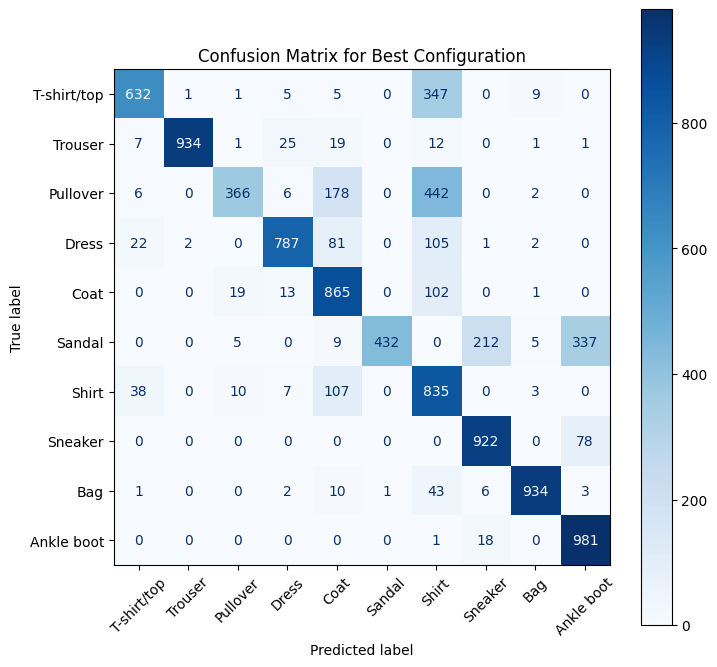

epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▇▇▇▇█▇█
val_loss,█▄▄▂▂▂▁▁▂▁
epoch,10
loss_type,cross_entropy
train_loss,0.27283
val_accuracy,0.8746
val_loss,0.3506


In [ ]:
import wandb
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Fetch the best run based on validation accuracy........................
api = wandb.Api()
sweep_runs = api.runs("ma23m021-iit-madras/MA23M021_A1")
best_run = max(sweep_runs, key=lambda run: run.summary.get("val_accuracy", 0))

print("Best Run ID:", best_run.id)
print("Best test Accuracy:", best_run.summary.get("val_accuracy"))

# Loading the best configuration.............................................
best_config = best_run.config
print("Best Configuration:", best_config)


run = wandb.init(project="MA23M021_A1", name="best_config_run", reinit=True)


# train model with best configuration.....................................
weights, biases = training_model(
    X_train=np.concatenate((X_train, X_valid)),
    Y_train=np.concatenate((y_train, y_valid)),
    X_valid=X_test,
    Y_valid=y_test,
    num_hidden_layers=best_config['num_hidden_layers'],
    num_neurons=best_config['hidden_layer_size'],
    num_epochs=best_config['epochs'],
    batch_size=best_config['batch_size'],
    learningg_rate_=best_config['learningg_rate_'],
    optimizer=best_config['optimizer'],
    init_method=best_config['weight_initialization'],
    activation_func=best_config['activation_function']
)

# Predict on the test set
test_probs, _, _, _, _ = forwardd_propagation_(
    X_test,
    best_config['num_hidden_layers'],
    best_config['hidden_layer_size'],
    weights,
    biases,
    activation_func=best_config['activation_function']
)

test_preds = np.argmax(test_probs, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Compute Confusion Matrix...........................
conf_matrix = confusion_matrix(true_labels, test_preds)
print("Confusion Matrix:\n", conf_matrix)
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix for Best Configuration")
plt.grid(False)


# Log Confusion Matrix to wandb.........................................
wandb.log({"confusion_matrix": wandb.Image(fig)})
plt.show()

wandb.finish()

# Ques 10

Based on your learnings above, give me 3 recommendations for what would work for the MNIST dataset (not Fashion-MNIST). Just to be clear, I am asking you to take your learnings based on extensive experimentation with one dataset and see if these learnings help on another dataset. If I give you a budget of running only 3 hyperparameter configurations as opposed to the large number of experiments you have run above then which 3 would you use and why. Report the accuracies that you obtain using these 3 configurations.

In [ ]:
def training_model(X_train, Y_train, X_test, Y_test, num_hidden_layers, num_neurons, num_epochs=20, batch_size=32,
                   learningg_rate_=0.01, optimizer='adam', init_method='xavier', activation_func='relu',
                   loss_type='cross_entropy'):
    if Y_train.ndim == 1:
        Y_train = one_hot_encode(Y_train)
    if Y_test.ndim == 1:
        Y_test = one_hot_encode(Y_test)

    # Initialize weights and biases
    input_size = X_train.shape[1]
    weights, biases = param_init(input_size, num_hidden_layers, num_neurons, init_method=init_method)

    # Optimizer parameters
    optimizer_params = {
        "learningg_rate_": learningg_rate_,
        "beta": 0.9,
        "beta1": 0.9,
        "beta2": 0.999,
        "eps": 1e-8
    }

    # Choose optimizer function
    optimizer_func = {
        'adam': adam, 'sgd': sgd, 'momentum': momentum,
        'nesterov': nesterov, 'rmsprop': rmsprop, 'nadam': nadam
    }.get(optimizer, adam)

    num_samples = X_train.shape[0]
    num_batches = num_samples // batch_size

    # Training loop
    for epoch in range(num_epochs):
        perm = np.random.permutation(num_samples)
        X_train, Y_train = X_train[perm], Y_train[perm]

        epoch_loss = 0
        for i in range(num_batches):
            batch_X = X_train[i * batch_size:(i + 1) * batch_size]
            batch_Y = Y_train[i * batch_size:(i + 1) * batch_size]

            # Forward pass
            probs, activations, z_values, weights, biases = forwardd_propagation_(
                batch_X, num_hidden_layers, num_neurons, weights, biases, activation_func
            )

            # Compute loss based on loss_type
            if loss_type == "cross_entropy":
                batch_loss = -np.mean(np.sum(batch_Y * np.log(probs + 1e-8), axis=1))
            elif loss_type == "mse":
                batch_loss = np.mean(np.sum((batch_Y - probs) ** 2, axis=1))
            else:
                raise ValueError(f"Unsupported loss type: {loss_type}")

            epoch_loss += batch_loss

            # Backward pass and update weights
            grads = backwardd_propagation_(batch_Y, activations, z_values, weights, activation_func)
            weights, biases = optimizer_func(weights, biases, grads, optimizer_params)

        # Validation phase
        test_probs, _, _, _, _ = forwardd_propagation_(
            X_test, num_hidden_layers, num_neurons, weights, biases, activation_func
        )


        test_accuracy_value = np.mean(np.argmax(test_probs, axis=1) == np.argmax(Y_test, axis=1))

        # Log to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": epoch_loss / num_batches,
            "test_accuracy": test_accuracy_value,
            "loss_type": loss_type
        })

        print(f"Epoch {epoch + 1}/{num_epochs}, {loss_type} - Train Loss: {epoch_loss / num_batches:.4f}, "
              f" test Accuracy: {test_accuracy_value:.4f}")

    return weights, biases


In [ ]:
import wandb
import numpy as np
from keras.datasets import mnist
from sklearn.model_selection import train_test_split

# Loading MNIST Dataset........................................
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0  # Normalize data

def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train = one_hot_encode(y_train)
y_test = one_hot_encode(y_test)

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# the Best Configurations...................................
best_configs = [
    {
        "name": "Best_Config_1",
        "epochs": 10,
        "optimizer": "nadam",
        "batch_size": 64,
        "weight_decay": 0.0005,
        "learning_rate": 0.001,
        "hidden_layer_size": 128,
        "num_hidden_layers": 4,
        "activation_function": "tanh",
        "weight_initialization": "xavier"
    },
    {
        "name": "Best_Config_2",
        "epochs": 10,
        "optimizer": "adam",
        "batch_size": 64,
        "weight_decay": 0,
        "learning_rate": 0.001,
        "hidden_layer_size": 128,
        "num_hidden_layers": 4,
        "activation_function": "sigmoid",
        "weight_initialization": "xavier"
    },
    {
        "name": "Best_Config_3",
        "epochs": 10,
        "optimizer": "nadam",
        "batch_size": 64,
        "weight_decay": 0,
        "learning_rate": 0.001,
        "hidden_layer_size": 16,
        "num_hidden_layers": 3,
        "activation_function": "tanh",
        "weight_initialization": "xavier"
    }
]

# Running Each Configuration.................................
for config in best_configs:
    print(f"\n🔹 Running {config['name']}...")
    wandb.init(project="MA23M021_A1", name=config['name'], reinit=True)
    wandb.config.update(config)

    # Training the Model with the Best Configuration...........................
    weights, biases = training_model(
        X_train=X_train,
        Y_train=y_train,
        X_test=X_test,
        Y_test=y_test,
        num_hidden_layers=config['num_hidden_layers'],
        num_neurons=config['hidden_layer_size'],
        num_epochs=config['epochs'],
        batch_size=config['batch_size'],
        learningg_rate_=config['learning_rate'],
        optimizer=config['optimizer'],
        init_method=config['weight_initialization'],
        activation_func=config['activation_function']
    )




🔹 Running Best_Config_1...


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁▆▇▇██████
train_loss,█▄▂▂▁▁▁▁▁▁
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
loss_type,cross_entropy
test_accuracy,0.9381
train_loss,0.20118
val_loss,0.22336


Epoch 1/10, cross_entropy - Train Loss: 0.6718,  test Accuracy: 0.9287
Epoch 2/10, cross_entropy - Train Loss: 0.2007,  test Accuracy: 0.9562
Epoch 3/10, cross_entropy - Train Loss: 0.1385,  test Accuracy: 0.9645
Epoch 4/10, cross_entropy - Train Loss: 0.1057,  test Accuracy: 0.9664
Epoch 5/10, cross_entropy - Train Loss: 0.0866,  test Accuracy: 0.9708
Epoch 6/10, cross_entropy - Train Loss: 0.0723,  test Accuracy: 0.9700
Epoch 7/10, cross_entropy - Train Loss: 0.0617,  test Accuracy: 0.9743
Epoch 8/10, cross_entropy - Train Loss: 0.0533,  test Accuracy: 0.9741
Epoch 9/10, cross_entropy - Train Loss: 0.0443,  test Accuracy: 0.9742
Epoch 10/10, cross_entropy - Train Loss: 0.0399,  test Accuracy: 0.9774

🔹 Running Best_Config_2...


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁▅▆▆▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
epoch,10
loss_type,cross_entropy
test_accuracy,0.9774
train_loss,0.03991


Epoch 1/10, cross_entropy - Train Loss: 0.6335,  test Accuracy: 0.9311
Epoch 2/10, cross_entropy - Train Loss: 0.1963,  test Accuracy: 0.9529
Epoch 3/10, cross_entropy - Train Loss: 0.1391,  test Accuracy: 0.9570
Epoch 4/10, cross_entropy - Train Loss: 0.1081,  test Accuracy: 0.9669
Epoch 5/10, cross_entropy - Train Loss: 0.0877,  test Accuracy: 0.9681
Epoch 6/10, cross_entropy - Train Loss: 0.0725,  test Accuracy: 0.9718
Epoch 7/10, cross_entropy - Train Loss: 0.0601,  test Accuracy: 0.9703
Epoch 8/10, cross_entropy - Train Loss: 0.0493,  test Accuracy: 0.9737
Epoch 9/10, cross_entropy - Train Loss: 0.0441,  test Accuracy: 0.9729
Epoch 10/10, cross_entropy - Train Loss: 0.0369,  test Accuracy: 0.9749

🔹 Running Best_Config_3...


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁▄▅▇▇█▇███
train_loss,█▃▂▂▂▁▁▁▁▁
epoch,10
loss_type,cross_entropy
test_accuracy,0.9749
train_loss,0.03692


Epoch 1/10, cross_entropy - Train Loss: 1.7253,  test Accuracy: 0.8446
Epoch 2/10, cross_entropy - Train Loss: 0.7699,  test Accuracy: 0.9064
Epoch 3/10, cross_entropy - Train Loss: 0.4270,  test Accuracy: 0.9209
Epoch 4/10, cross_entropy - Train Loss: 0.3211,  test Accuracy: 0.9284
Epoch 5/10, cross_entropy - Train Loss: 0.2732,  test Accuracy: 0.9328
Epoch 6/10, cross_entropy - Train Loss: 0.2448,  test Accuracy: 0.9357
Epoch 7/10, cross_entropy - Train Loss: 0.2246,  test Accuracy: 0.9390
Epoch 8/10, cross_entropy - Train Loss: 0.2091,  test Accuracy: 0.9428
Epoch 9/10, cross_entropy - Train Loss: 0.1979,  test Accuracy: 0.9420
Epoch 10/10, cross_entropy - Train Loss: 0.1882,  test Accuracy: 0.9440
